In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 40000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.2*abs_residual + 0.8*chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:40,  9.78it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 124.64it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 161.64it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 173.63it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 186.71it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 181.71it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 185.57it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 180.61it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 190.56it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 195.40it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 193.25it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 196.43it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 196.27it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 197.50it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 192.08it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 192.85it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 182.26it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 180.87it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 184.51it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 182.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 183.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.65it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.63it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.07it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 169.30it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 166.74it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 173.27it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.20it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 177.26it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 182.28it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 180.13it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 180.94it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 173.82it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 171.64it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 173.32it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 170.62it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 174.04it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 173.18it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 165.21it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 164.47it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 163.65it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 165.69it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.80it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.75it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.94it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 175.44it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 180.36it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 173.22it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 173.66it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 180.35it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 180.14it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 180.10it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 179.69it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 179.70it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 168.99it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 171.79it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 171.64it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 168.91it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 163.93it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 164.96it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 169.55it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 166.36it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 171.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.72it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.49it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.67it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 170.41it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 173.55it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 173.83it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 177.19it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 175.25it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 172.01it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 175.86it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 173.57it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 175.21it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 178.78it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 171.92it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 171.36it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 167.05it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 161.14it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 161.33it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 165.65it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 164.54it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 170.24it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 169.28it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.68it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 175.42it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 179.80it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 171.38it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 171.32it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 171.96it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 171.48it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 175.00it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 176.89it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 180.45it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 180.17it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 181.80it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 180.13it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 175.52it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 175.45it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 170.18it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 169.35it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 167.90it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 169.83it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 168.76it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 168.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 142.91it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 159.05it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.32it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 162.80it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 157.54it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 163.71it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 167.57it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 168.27it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 168.93it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 176.28it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 180.01it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 179.83it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 178.56it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 172.41it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 171.54it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 161.84it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 165.90it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 167.26it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 169.63it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 171.68it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 174.63it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 175.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.23it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 184.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 174.46it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 166.27it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 170.65it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 171.84it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 174.09it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 177.36it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 180.56it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 171.57it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 171.53it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 174.55it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 171.48it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 172.97it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 164.54it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 163.20it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 164.67it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 171.41it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 175.04it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 182.01it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 180.69it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.66it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 156.04it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 157.67it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 157.17it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 162.54it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 166.97it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 169.70it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 162.58it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 170.30it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 171.10it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 165.59it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 174.17it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 173.12it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 168.16it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 162.75it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 162.90it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 163.11it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 166.30it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 172.99it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 171.72it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 175.77it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 171.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.51it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.20it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 158.68it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 156.78it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 165.34it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 162.15it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 165.39it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 168.41it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 172.32it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 176.25it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 168.31it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 165.21it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 168.77it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 172.93it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 169.40it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 157.33it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 159.28it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 157.67it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 160.44it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 162.47it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 165.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.01it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.67it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 189.39it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 180.42it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 167.41it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 172.40it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 175.30it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 178.15it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 172.49it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 168.64it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 169.18it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 173.09it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 173.40it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 169.20it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 169.39it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 160.89it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 157.76it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 165.79it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 167.66it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 165.33it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 160.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.28it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 161.65it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 169.27it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 170.74it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 166.11it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 169.42it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 167.25it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 165.03it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 161.21it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 161.28it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 163.35it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 165.91it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 169.67it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 165.85it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 171.14it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 175.58it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 166.59it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 164.29it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 160.50it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 156.42it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 160.52it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 161.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.55it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 177.64it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 177.72it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 183.55it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 180.25it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 175.81it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 175.22it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 176.67it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 175.92it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 174.87it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 176.95it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 163.03it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 167.19it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 173.17it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 172.60it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 169.90it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 165.69it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 164.78it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 168.68it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 168.12it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 168.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.39it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 154.92it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 162.61it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 166.47it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 163.08it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 167.29it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 165.08it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 167.88it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 164.06it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 163.58it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 160.80it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 164.54it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 169.92it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 168.44it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 167.68it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 164.37it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 167.99it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 148.42it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 151.39it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 158.58it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 165.30it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 169.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.52it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.61it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.67it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 180.73it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 176.43it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.74it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 175.06it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 176.25it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 169.30it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 174.82it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 175.29it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 172.26it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 163.71it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 167.87it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 171.16it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 173.38it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 171.77it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 169.32it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 169.48it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 169.89it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 177.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.38it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.99it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 169.45it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 171.80it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 172.18it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 171.21it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 166.80it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.13it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 168.61it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 172.77it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 174.30it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 176.57it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 174.88it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 174.30it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 173.31it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 171.72it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 172.56it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 175.11it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 178.62it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 178.63it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 174.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.74it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 165.57it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 165.50it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.60it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 171.51it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 171.73it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 168.11it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 168.64it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 167.08it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 166.25it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 167.91it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 168.44it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 169.38it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 166.49it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 167.16it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 170.05it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 177.03it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 176.14it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 175.25it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 176.25it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 177.86it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 174.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.25it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 171.34it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 172.84it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 169.83it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 164.54it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 169.18it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 167.48it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 158.55it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 162.81it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 160.98it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 161.80it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 155.82it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 157.12it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 164.66it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 165.73it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 165.76it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 167.65it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 167.09it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 172.42it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 163.68it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 162.68it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 164.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.81it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.70it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 169.89it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.23it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 166.90it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 163.87it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 162.61it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 166.55it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 165.17it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 167.42it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 164.42it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 167.40it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 171.78it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 168.23it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 168.66it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 172.90it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 175.69it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 177.89it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 177.49it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 177.48it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 175.92it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 176.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.69it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 160.49it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 160.23it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 163.35it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 158.81it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 158.96it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 168.42it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 170.39it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 172.97it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 167.06it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 169.66it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 166.22it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 172.01it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 171.47it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 170.18it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.04it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 171.79it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 173.35it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 175.28it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 171.77it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 170.15it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 168.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.57it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 143.92it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 153.42it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 165.82it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 170.40it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 169.29it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 159.82it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 165.53it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 160.76it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 162.41it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 163.65it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 165.93it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 165.19it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 168.09it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 171.82it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 168.53it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 170.24it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 174.22it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 175.28it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 175.23it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 168.12it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 165.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.52it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 167.36it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 167.84it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 171.03it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 175.17it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.83it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 179.35it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 173.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.09it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 169.89it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 171.97it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 173.04it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 161.37it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 161.29it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 163.00it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 161.91it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 171.27it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 165.57it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 171.82it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 168.36it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 165.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.21it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.30it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 175.32it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 175.05it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 172.57it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.18it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 166.52it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 160.88it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 166.22it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 162.87it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 162.57it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 168.62it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 167.22it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 164.58it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 163.62it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 162.78it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 168.76it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 176.87it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 174.35it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 175.11it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 176.47it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 177.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.71it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.53it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.88it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 170.43it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 174.50it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 175.47it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 174.96it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 169.48it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 167.79it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 164.05it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 161.78it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 165.46it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 168.20it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 173.03it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 169.51it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 174.70it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 177.71it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 166.77it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 161.40it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 160.48it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 162.70it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 169.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 150.84it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.91it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 159.59it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 161.53it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 165.84it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 162.87it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 158.96it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 164.29it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 165.22it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 158.54it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 161.60it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 162.76it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 161.05it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 163.27it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 161.78it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 165.92it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 170.01it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 159.72it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 161.60it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 161.16it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 158.55it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 159.74it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 159.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.07it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 151.65it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 160.86it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 162.05it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 157.22it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 163.98it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 168.60it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 168.52it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 164.49it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 165.72it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 167.64it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 168.12it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 172.03it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 172.74it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 174.23it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 173.80it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 162.66it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 163.99it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 166.56it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 169.42it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 167.08it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 173.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.55it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 156.52it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.31it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 165.89it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 168.28it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 168.53it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 166.51it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 171.15it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 171.31it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 171.21it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 164.94it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 161.47it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 170.89it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 168.65it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 170.35it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 167.05it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 165.51it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 158.18it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 160.88it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 163.58it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 165.66it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 165.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.73it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 159.24it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 167.18it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 160.45it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 161.76it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 166.56it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 161.12it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 166.51it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 162.90it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 165.97it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 162.77it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 161.46it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 165.30it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 166.44it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 164.08it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 164.69it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 163.34it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 167.61it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 168.05it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 161.46it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 162.16it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 162.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.98it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 170.32it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 176.12it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 164.96it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 165.83it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 159.22it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 164.78it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 163.18it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 163.49it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 164.35it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 162.21it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 160.08it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 163.75it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 163.95it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 163.53it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 169.92it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 170.16it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 168.41it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 161.85it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 166.06it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 166.49it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 171.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.29it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 167.38it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 160.23it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 166.72it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.18it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 166.37it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 166.06it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 170.67it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 174.30it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 178.03it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 177.41it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 158.95it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 157.01it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.24it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 162.09it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 167.06it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 164.96it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 164.03it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 167.69it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 166.73it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 165.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.17it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.46it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.95it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 166.02it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 171.79it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 172.07it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 169.10it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 167.02it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 166.99it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 171.52it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 166.46it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 158.42it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 164.28it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 155.26it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 159.08it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 162.49it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 163.46it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 167.81it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 164.79it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 167.79it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 170.79it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 166.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.58it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 158.10it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 152.86it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 163.62it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 160.71it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 149.34it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 150.23it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 155.06it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 155.76it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 151.63it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 161.97it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 169.92it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 171.79it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 173.09it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 166.84it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 167.38it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 168.58it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 173.23it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 167.94it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 166.51it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 161.82it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 166.00it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.85it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.53it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 173.85it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 163.86it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 158.50it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 152.56it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 146.93it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 149.03it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 155.00it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 155.95it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 159.64it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 164.19it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 165.21it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 160.48it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 161.58it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 158.12it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 160.40it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 161.25it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 164.25it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 167.04it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 169.12it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 159.24it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 162.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.77it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.57it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.05it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.14it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 168.33it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 168.65it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 160.73it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 164.69it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 158.39it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 157.88it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 162.18it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 160.65it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 153.29it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 160.44it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 157.24it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 157.00it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 163.42it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 164.17it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 164.30it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 164.55it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 164.71it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 160.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 162.66it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 159.13it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 156.26it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 158.36it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 167.43it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 170.16it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 169.28it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 169.55it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 160.82it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 164.21it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 166.02it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 169.02it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 161.13it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 160.44it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 163.23it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 161.31it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 160.18it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 152.48it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 157.55it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 157.68it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 163.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.82it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 170.56it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.53it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 169.69it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 167.35it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 173.21it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 173.60it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 172.88it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 167.39it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 168.10it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 170.03it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 170.45it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 169.16it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 168.81it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 169.04it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 157.19it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 156.54it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 158.98it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 154.45it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 157.38it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 162.19it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 169.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.22it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 171.14it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 180.48it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 177.34it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 170.95it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 167.92it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 168.43it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 168.14it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 168.56it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 170.64it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 172.97it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 170.77it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 159.56it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 155.71it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 156.63it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 155.34it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 160.12it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 162.29it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 162.82it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 165.92it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 162.62it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 155.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.46it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 156.64it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 151.27it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 151.85it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 159.60it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 165.97it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 167.05it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 160.77it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 160.57it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 159.22it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 165.19it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 160.32it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 157.26it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 154.47it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 154.08it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 159.29it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 159.40it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 154.74it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 154.71it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 150.70it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 157.64it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 159.56it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 162.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 157.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.43it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.51it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.90it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 169.61it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 171.11it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 165.70it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 160.82it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 167.42it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 170.50it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 166.78it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 165.74it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 166.02it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 174.39it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 158.65it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 158.98it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 154.52it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 157.20it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 161.74it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 167.02it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 166.94it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 169.10it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 167.28it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.33it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 161.11it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 169.36it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 158.96it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 160.82it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 162.70it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 171.00it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 165.76it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 168.66it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 159.36it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 152.87it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 160.45it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 163.86it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 162.15it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 165.07it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 165.18it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 163.36it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 158.35it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 157.03it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 162.06it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 160.59it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.78it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.97it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.08it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 164.60it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 166.51it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 170.71it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.44it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 175.61it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 176.59it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 179.74it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 165.47it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 166.20it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 166.79it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 166.21it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.85it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 159.75it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 157.44it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 157.78it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 158.17it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 155.89it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 155.10it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 165.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.69it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.99it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 169.72it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 174.49it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.89it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.74it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 171.53it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 150.87it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 155.49it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 158.18it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 166.05it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 170.48it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 167.16it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 165.19it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 159.99it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 155.23it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 158.48it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 165.39it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 161.48it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 162.61it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 165.55it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 171.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.71it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 160.13it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 168.61it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 176.17it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 180.45it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 170.85it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 169.44it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.17it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 162.51it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 162.12it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 164.39it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 162.83it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 155.89it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 161.34it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 159.69it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 161.08it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 169.23it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 167.22it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 165.62it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 166.70it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 171.25it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 166.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.08it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 153.97it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 155.27it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 159.09it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 159.62it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 157.06it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 166.18it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 166.89it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 171.85it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 167.70it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 175.69it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 174.07it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 173.64it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 177.33it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 179.06it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 177.06it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 172.23it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 174.02it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 169.20it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 167.46it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 168.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.91it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 179.90it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 176.51it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 168.29it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 171.84it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 169.73it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 173.48it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 174.33it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 178.68it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 176.00it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 165.35it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 164.19it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 158.65it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 155.79it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 155.63it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 158.71it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 162.59it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 155.74it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 159.06it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 163.98it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 162.50it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 165.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.63it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 163.46it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 164.45it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 163.35it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 167.50it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 166.78it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 163.25it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 163.05it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 160.72it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 159.20it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 161.08it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 160.73it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 162.56it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 162.93it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 166.81it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 164.62it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 158.30it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 160.03it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 163.68it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 162.69it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 161.51it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 161.25it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 163.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.88it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.16it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 165.20it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.94it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 166.83it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 169.67it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 160.88it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 159.15it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 163.35it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 161.58it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 156.87it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 159.27it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 160.40it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 166.36it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 169.57it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 163.68it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 165.93it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 166.48it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 169.17it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.25it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 176.49it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.49it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.22it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.54it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 166.26it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 165.13it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 160.27it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 162.70it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 163.75it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 164.31it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 161.87it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 163.95it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 164.52it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 159.96it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 163.92it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 168.64it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 161.67it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 159.59it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 164.30it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 160.68it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 160.96it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 166.16it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 162.30it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 162.14it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 179.98it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 173.05it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 154.97it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 162.48it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 163.00it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 160.37it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 161.40it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.38it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 164.52it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 169.49it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 166.16it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 164.25it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 167.77it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 169.22it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 167.44it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 167.78it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 167.82it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 172.26it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 172.06it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 172.85it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 172.66it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 171.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.20it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.87it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 164.65it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.46it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 176.70it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.73it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 171.86it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 168.51it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 168.53it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 171.95it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 172.93it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 173.55it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 169.29it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 163.39it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 164.78it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 168.37it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 164.34it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 168.05it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 172.70it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 172.79it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 179.66it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 172.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.42it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 191.73it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 184.02it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 173.02it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 170.47it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 161.50it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 162.22it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 154.14it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 156.11it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 154.95it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 150.98it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 150.59it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 153.89it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 156.27it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 161.36it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 164.19it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 160.67it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 158.57it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 162.83it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 160.08it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 158.46it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 161.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.94it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.37it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.76it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 169.46it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 168.84it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 170.11it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.80it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 165.12it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 167.69it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 165.90it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 165.43it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 169.99it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 165.87it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 161.93it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 162.70it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 161.88it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 165.54it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 170.35it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 173.49it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 167.69it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 173.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.17it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 156.18it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 169.99it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 170.74it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 174.21it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 169.34it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 159.05it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 155.46it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 159.38it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 167.04it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 167.84it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 168.10it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 160.49it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 160.16it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 161.38it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 161.29it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 161.84it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 160.45it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 155.13it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 158.45it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 157.53it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 162.41it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 168.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.92it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.80it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.27it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 169.76it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 162.39it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 164.08it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 161.49it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 161.78it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 163.87it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 168.63it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 166.60it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 163.91it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 161.64it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 164.57it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 165.40it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 166.74it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 159.82it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 158.58it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 166.33it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 171.11it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 172.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.32it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 152.93it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 151.09it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 153.27it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 152.26it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 148.86it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 158.72it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 159.71it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 150.62it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 147.01it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 154.44it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 158.11it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 164.76it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 169.92it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 165.95it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 165.45it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 167.01it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 171.56it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 174.83it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 172.86it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 172.42it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 174.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.52it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.28it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 176.07it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 165.42it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 166.57it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 169.41it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 174.69it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 168.75it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 161.76it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 163.86it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 168.30it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 172.85it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 174.28it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 178.71it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 180.09it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 179.58it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 169.36it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 173.43it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 170.62it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 167.09it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 157.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.77it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 158.66it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.79it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 172.66it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 174.47it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 169.08it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 167.79it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 168.60it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 167.89it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 172.26it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 165.08it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 162.12it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 161.95it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 163.81it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 163.50it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 166.53it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 164.81it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 165.62it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 167.93it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 166.27it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 168.72it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 173.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.60it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.81it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.90it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 167.62it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 158.56it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 157.97it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 155.64it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 155.46it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 154.05it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 158.07it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 152.58it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 158.19it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 152.28it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 162.26it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 165.75it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 158.38it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 159.38it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 162.49it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 165.32it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 166.54it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 162.83it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 164.62it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 165.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.41it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 167.82it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.91it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 176.93it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 171.86it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 164.83it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 168.29it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 171.70it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 173.07it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 174.86it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 176.15it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 171.18it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 169.07it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 170.01it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 175.50it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 174.95it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 174.08it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 167.66it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 169.00it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 168.34it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 168.34it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 172.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.93it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.15it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 177.57it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 176.53it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 172.11it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 168.33it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 170.03it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 168.77it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 168.92it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 165.81it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 162.63it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 151.55it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 158.65it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 167.25it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 169.52it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 165.45it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 168.52it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 168.11it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 163.70it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 158.83it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 153.84it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 157.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.77it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.01it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 160.18it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 166.29it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 168.19it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 163.18it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 161.20it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 160.34it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 169.86it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 168.26it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 168.21it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 166.15it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 164.43it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 163.24it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 166.96it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 164.66it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 163.35it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 158.67it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 162.88it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 166.01it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 168.50it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 165.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.60it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.91it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.17it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 166.04it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.25it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 175.20it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 175.39it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 175.46it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 172.44it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 172.08it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 167.63it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 172.22it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 173.60it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 173.52it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 170.31it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 172.30it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 171.69it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 161.87it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 162.50it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 163.28it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 167.43it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 161.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.77it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 152.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 163.61it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 163.96it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 159.51it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 157.43it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 153.33it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 151.74it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 158.01it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 161.26it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 163.01it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 164.69it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 169.17it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 171.35it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 169.14it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 173.25it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 169.47it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 167.92it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 160.26it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 163.04it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 158.23it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 156.56it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 157.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.79it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 152.64it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.53it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 174.56it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 179.49it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 179.33it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 175.63it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 174.10it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 167.78it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 167.24it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 163.28it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 165.64it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 164.30it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 167.69it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 159.77it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 161.20it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 165.35it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 167.19it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 161.24it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 160.43it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 163.01it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 165.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.43it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 161.73it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 164.21it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 164.31it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 163.98it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 166.49it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 171.42it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 171.12it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 176.48it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 173.47it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 176.65it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 168.49it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 163.90it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 165.50it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 163.70it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 161.95it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 165.88it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 164.81it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 164.70it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 167.67it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 167.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.97it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.53it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 165.30it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 166.59it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 170.76it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 169.86it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 170.24it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 166.58it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 165.53it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 173.27it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 165.66it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 163.36it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 168.26it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 170.40it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 175.80it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 176.17it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 170.98it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 168.83it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 165.57it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 165.39it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 164.31it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 164.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.02it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.68it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 162.25it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 161.56it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 158.72it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 160.56it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 157.63it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 160.86it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 159.57it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 162.97it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 164.18it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 165.51it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 168.75it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 167.89it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 166.79it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 166.14it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 165.44it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 171.74it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 173.22it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 172.83it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 171.97it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 167.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.73it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 159.85it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 168.29it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 162.84it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 160.28it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 164.76it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 166.55it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 167.20it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 168.16it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 170.54it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 173.83it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 178.15it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 176.57it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 175.79it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 178.33it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 174.85it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 172.51it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 170.52it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 172.94it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 176.16it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 178.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.26it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.80it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.19it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 166.19it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 167.03it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 171.87it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 172.84it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 174.82it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 175.79it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 174.96it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 165.70it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 159.61it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 158.63it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 159.43it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 153.79it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 163.03it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 167.10it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 168.01it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 169.50it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 170.56it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 161.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.27it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.46it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 176.05it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 166.31it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 162.93it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 163.32it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 165.35it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.64it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 159.96it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 159.02it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 158.07it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 154.16it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 150.89it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 152.04it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 155.86it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 162.09it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 166.66it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 169.70it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 170.38it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 168.88it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 167.28it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 167.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.46it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 159.62it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.60it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 160.75it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 162.19it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 156.77it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 155.16it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 155.43it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 152.61it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 159.05it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 160.08it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 164.91it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 160.74it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 163.09it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 162.52it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 160.84it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 161.83it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 163.70it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 153.72it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 161.66it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 159.87it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 160.28it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 161.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.85it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 165.86it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 171.10it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 151.20it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 151.81it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 153.62it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 153.58it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 153.71it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 158.25it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 147.36it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 156.32it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 158.38it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 164.43it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 168.74it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 163.25it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 162.04it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 167.07it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 167.68it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 169.42it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 172.16it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 173.62it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 173.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.08it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.51it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.31it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 170.96it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 173.97it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 177.18it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 179.72it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 169.94it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 166.76it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 166.38it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 165.29it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 166.81it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 168.39it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 166.10it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.80it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 165.70it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 168.64it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 164.93it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 167.64it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 166.96it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 168.83it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 156.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.08it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.88it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.66it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 164.21it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 156.57it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 154.11it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 161.65it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 156.30it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 155.35it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 160.09it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 162.53it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 156.55it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 162.25it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 167.22it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 173.84it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.84it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 165.28it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 164.10it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 166.18it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 172.10it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 168.51it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 170.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.08it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.09it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 170.05it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.94it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 158.97it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 163.48it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 158.71it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 156.21it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 160.86it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 159.27it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 163.69it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 165.47it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 163.62it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 162.61it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 159.81it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 163.16it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 161.01it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 160.36it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 163.94it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 162.51it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 160.29it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 163.38it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 164.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.42it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 139.38it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 150.57it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 153.17it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 162.47it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 163.12it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 163.24it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 162.32it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 165.26it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 156.99it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 160.35it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 162.92it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 161.82it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 155.51it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 155.63it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 158.08it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 162.27it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 161.84it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 158.73it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 158.43it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 159.93it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 160.07it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 157.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 155.74it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 145.28it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 158.56it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 153.80it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 153.45it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 158.66it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 167.24it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 160.03it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 156.57it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 162.77it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 167.24it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 165.19it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 162.92it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 163.81it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 156.17it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 162.17it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 163.68it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 166.28it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 162.61it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 152.82it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 152.33it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 155.37it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 158.13it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.01it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.34it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 162.19it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 157.84it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 161.31it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 160.22it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 162.17it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 166.37it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 159.90it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 156.67it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 158.17it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 155.92it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 155.78it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 154.56it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 158.66it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 155.61it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 158.36it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 158.80it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 156.15it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 153.69it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 157.00it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 160.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.77it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.31it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.50it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 168.54it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 159.18it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 161.33it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 161.66it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 163.10it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 162.84it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 167.31it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 164.88it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 168.41it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 165.18it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 160.92it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 160.61it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 164.71it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 169.97it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 168.43it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 166.17it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 164.32it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 160.67it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 154.87it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 154.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.04it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 160.57it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.33it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 150.89it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 152.43it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 145.40it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 153.06it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 153.09it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 159.73it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 165.42it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 167.95it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 167.95it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 166.15it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 159.56it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 160.80it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 162.79it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 164.29it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 161.76it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 157.89it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 160.69it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 167.76it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 162.24it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 160.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.54it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 189.18it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 185.95it/s]

Adam:  20%|██        | 81/400 [00:00<00:01, 196.50it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 202.13it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 198.00it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 198.50it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 206.08it/s]

Adam:  47%|████▋     | 188/400 [00:00<00:01, 203.53it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:00, 210.39it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 195.32it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 198.61it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 203.05it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 199.92it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 206.59it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 198.84it/s]

Adam:  91%|█████████ | 363/400 [00:01<00:00, 203.11it/s]

Adam:  96%|█████████▋| 386/400 [00:01<00:00, 208.78it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 202.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 196.50it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 205.21it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:01, 209.86it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 216.11it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 209.54it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 208.55it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 191.24it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 179.13it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 167.91it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 170.97it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 170.35it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 173.61it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 170.28it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 168.17it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 165.95it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 165.74it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 166.20it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 169.72it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 174.36it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 171.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.24it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 157.66it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 164.95it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 174.67it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 168.35it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 171.89it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 172.11it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 167.74it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 164.41it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 165.87it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 169.60it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 169.30it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 169.38it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 168.57it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 170.46it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 168.58it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 163.69it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 164.74it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 168.28it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 166.01it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 165.36it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 166.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.91it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.82it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 177.55it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 167.01it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.93it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 174.09it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 167.45it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 170.52it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 172.70it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 173.12it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 170.26it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 174.07it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 176.98it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 178.64it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 178.16it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 168.78it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 173.06it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 165.11it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 164.11it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 157.46it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 152.65it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 159.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.20it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 141.74it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 157.02it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 158.13it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 156.81it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 157.34it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 164.90it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 168.19it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 166.13it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 166.29it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 163.79it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 167.76it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 164.93it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 159.88it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 160.96it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 160.16it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 161.38it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 158.06it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 162.85it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 168.43it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 175.41it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 177.65it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 175.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.11it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.08it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.55it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 168.01it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 171.77it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 159.64it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 161.41it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.59it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 168.58it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 163.97it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 160.06it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 166.03it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 169.44it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 168.29it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 169.34it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 172.02it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 173.07it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 172.52it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 176.09it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 178.72it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 177.75it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 178.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.56it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.29it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 157.81it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.10it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 171.11it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 172.75it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 163.74it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 159.03it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 161.70it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 163.33it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 167.41it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 166.20it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 168.99it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 171.26it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 167.76it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 171.03it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 172.73it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 175.90it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 170.21it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 159.43it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 163.86it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 168.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.25it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.62it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.41it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 169.84it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.03it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 161.58it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 156.93it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 160.68it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 162.83it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 165.20it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 165.96it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 163.76it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 166.40it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 171.63it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 170.31it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.07it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 172.79it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 170.88it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 165.73it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 163.14it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 167.42it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 165.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 178.61it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 180.77it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 183.97it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 179.05it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 174.94it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 167.76it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 166.18it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 168.91it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 173.14it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 175.47it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 172.33it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 173.98it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.82it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 178.65it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 179.03it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 178.57it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 181.51it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 177.40it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 170.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.71it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.37it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.68it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.54it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 162.54it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 158.79it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 167.70it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 165.67it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 165.37it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 165.31it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 164.35it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 159.92it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 158.04it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 149.16it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 160.30it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 159.09it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 162.33it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 168.30it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 165.23it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 158.45it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 163.26it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 160.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.01it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 153.97it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 152.64it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 164.39it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 165.07it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 163.88it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 168.55it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 170.81it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 175.80it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 178.52it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 176.97it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 173.90it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 171.58it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 168.95it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 169.97it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 155.29it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 157.09it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 157.78it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 158.23it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 158.11it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 156.14it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 152.65it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 155.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.62it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 162.33it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.95it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.83it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.06it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 160.45it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 152.24it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 157.23it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 155.45it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 151.37it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 155.57it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 161.90it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 165.42it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 165.56it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 167.33it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 155.11it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 158.54it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 158.77it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 155.65it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 162.97it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 168.68it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 169.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.45it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 159.85it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 172.16it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 169.50it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 172.38it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 170.95it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 168.10it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 167.36it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 169.38it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 161.22it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 162.74it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 157.69it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 150.97it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 162.71it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 170.17it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 174.11it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 169.20it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 173.77it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 171.96it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 171.75it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 175.64it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 173.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.08it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 153.71it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 154.47it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 163.83it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 165.65it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 169.18it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 163.39it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 167.41it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 161.87it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 167.93it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 172.61it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 173.77it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 168.75it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 166.17it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 171.11it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 171.49it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 175.00it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 176.03it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 175.59it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 171.99it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 174.13it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 166.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.84it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 174.75it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 167.34it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 163.52it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 170.41it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 177.48it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 179.50it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 173.10it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 169.16it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 170.11it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 174.06it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 166.86it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 169.13it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 165.47it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 170.83it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 172.63it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 179.13it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 173.98it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 177.39it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 177.65it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.29it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.14it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 161.64it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 171.15it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 167.94it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 171.74it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 166.72it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 165.07it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 163.63it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 164.61it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 167.58it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 172.99it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 171.11it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 160.82it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 165.37it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 166.49it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 168.87it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 163.03it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 160.59it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 155.12it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 154.07it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 161.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.61it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.17it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 165.89it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 162.06it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 166.37it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 149.04it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 160.64it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 163.90it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 162.02it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 160.91it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 163.19it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.00it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 169.33it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 166.46it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 159.63it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 163.40it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 167.83it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 170.36it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 170.81it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 175.54it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 171.26it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 170.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.78it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.07it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.42it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.89it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 170.97it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 170.01it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 171.65it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 166.04it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 165.26it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 168.25it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 163.79it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 167.34it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 170.42it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 166.32it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 170.81it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 165.77it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 163.11it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 167.25it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 165.48it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 171.80it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 173.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.74it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.54it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.85it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 177.56it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 178.98it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 173.19it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 168.20it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 168.12it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 169.23it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 167.49it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 169.98it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 171.29it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 171.17it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 165.23it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 168.10it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 168.36it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 168.66it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 167.33it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 164.68it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 166.04it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 161.71it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 163.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.98it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.73it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:01, 174.66it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 178.25it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 173.80it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 167.79it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 162.60it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 163.11it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 166.22it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 167.63it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 164.76it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 167.46it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 163.60it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 164.88it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 166.55it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 167.26it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 167.39it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 167.59it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 166.51it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 166.99it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 166.36it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 162.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.22it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.48it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.74it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 177.90it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 194.25it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 197.51it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 205.51it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 197.07it/s]

Adam:  45%|████▌     | 181/400 [00:00<00:01, 203.71it/s]

Adam:  50%|█████     | 202/400 [00:01<00:00, 204.18it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 207.40it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 212.86it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 216.59it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 219.18it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 203.71it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 199.62it/s]

Adam:  89%|████████▉ | 357/400 [00:01<00:00, 198.11it/s]

Adam:  95%|█████████▍| 379/400 [00:01<00:00, 202.53it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 200.81it/s]

Training time: 240.7590
当前为第1次循环，种子为0
Error y : 5.507888e-03
MAE: 4.659422e-04
MSE: 3.708153e-06
Chaos: 3.150012e+00
Residual: 4.725599e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<01:14,  5.39it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 75.57it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 121.51it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 145.35it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 159.92it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 158.54it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 165.74it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 171.59it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 169.80it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 158.54it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 162.98it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 169.74it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 172.57it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 173.95it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 169.33it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 169.49it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 174.38it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 174.27it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 173.27it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 170.03it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 173.25it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 168.63it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.81it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.49it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 177.83it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 173.18it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 177.34it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 177.45it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 167.49it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 177.19it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 182.59it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 186.02it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 187.52it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 189.84it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 185.27it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 184.48it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 185.39it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 181.32it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 173.24it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 177.12it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 169.13it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 175.27it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 173.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.90it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.80it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.04it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.14it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 163.92it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 170.71it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 174.92it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 174.99it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 178.39it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 181.00it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 179.71it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 180.69it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 179.48it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 175.07it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 172.40it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 170.58it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 166.82it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 166.70it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 165.09it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 171.84it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 174.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.77it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 183.99it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 182.83it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 179.50it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 177.19it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 178.01it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 178.57it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 165.20it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 165.28it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 170.92it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 167.16it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 170.02it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 166.12it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 162.27it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 160.93it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 167.14it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 167.15it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 173.62it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 179.27it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 177.31it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 178.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.01it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.01it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.24it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 166.59it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.19it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 175.39it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 183.15it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 185.10it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 180.90it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 177.94it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 172.31it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 172.72it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 172.94it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 168.48it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 166.04it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 166.93it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 165.29it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 166.86it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 165.88it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 164.65it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 168.09it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 172.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.52it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 174.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 178.49it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 183.80it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 183.00it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 184.98it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 182.60it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 183.49it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 185.27it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 190.21it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:00, 189.91it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 186.57it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 187.46it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 187.43it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 182.85it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 175.00it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 178.70it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 178.36it/s]

Adam:  91%|█████████▏| 365/400 [00:01<00:00, 178.28it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 180.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 180.03it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 182.58it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 174.68it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 179.00it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 168.85it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 171.60it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 169.79it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 172.61it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 178.07it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 177.97it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 180.86it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 177.25it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 177.65it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 179.36it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 176.49it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 181.22it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 178.14it/s]

Adam:  89%|████████▉ | 355/400 [00:01<00:00, 184.32it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 178.96it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 180.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.53it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 163.70it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:01, 174.65it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 181.55it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 182.93it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 182.09it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 176.31it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 175.53it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 176.65it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 181.38it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 177.37it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 180.84it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 185.38it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 184.07it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 182.56it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 179.17it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 181.38it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 183.56it/s]

Adam:  89%|████████▉ | 357/400 [00:01<00:00, 184.12it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 184.62it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 188.14it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.61it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 187.23it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 178.74it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 175.21it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 172.83it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 175.77it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 177.56it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 179.85it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 184.27it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 184.09it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 177.13it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 173.08it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 170.51it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 169.15it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.77it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 177.88it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 178.61it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 180.44it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 181.72it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 180.74it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 178.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.84it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 175.82it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 177.03it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 178.06it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 184.64it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 184.80it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 184.36it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 167.04it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 168.53it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 170.08it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 173.91it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 179.29it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 180.37it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 178.32it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 172.24it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 171.31it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 175.82it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 179.20it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 179.04it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 178.48it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 172.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.91it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 170.75it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 171.30it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 176.43it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 175.60it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.10it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 177.04it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 180.06it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 181.07it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 183.10it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 179.16it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 174.54it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 174.67it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 178.55it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 174.75it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 170.89it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 168.04it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 169.44it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 171.41it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 167.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.70it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.54it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.96it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 178.40it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 176.26it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 177.86it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 178.42it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 166.05it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 167.45it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 168.77it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 169.64it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 175.59it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 168.24it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 170.89it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 173.49it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 175.81it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 178.09it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 174.39it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 176.21it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 180.25it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 178.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 180.08it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.72it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.89it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 178.75it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 177.28it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 177.91it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 181.23it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 179.88it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 181.58it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 180.78it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 180.25it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 181.50it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 183.41it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 167.73it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 167.67it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 166.56it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 165.38it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 174.29it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 165.31it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 166.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.30it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 185.77it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 159.82it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 173.60it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 161.70it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 151.49it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 155.75it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 159.52it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 162.52it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 167.47it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 171.37it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 172.76it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 167.22it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 174.68it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 180.63it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 181.61it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 172.66it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 168.19it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 167.29it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 168.02it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 165.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.22it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.54it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 163.57it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 168.35it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 167.31it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 163.56it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 166.94it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 165.87it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 171.13it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 171.63it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 174.42it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 176.40it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 178.16it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 181.44it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 177.11it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 179.20it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 177.09it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 176.42it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 180.01it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 174.75it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 173.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 165.87it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 162.97it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 171.53it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 173.91it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.06it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 179.72it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 176.24it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 178.31it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 180.32it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 182.59it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 183.98it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 177.09it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 176.57it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 173.78it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 174.83it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 172.18it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 175.04it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 173.40it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 173.59it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 172.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.46it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.71it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.07it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 184.71it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 186.63it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 182.09it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 182.47it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 183.12it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 176.58it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 171.51it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 166.51it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 171.46it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 168.40it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 165.57it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 165.19it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 163.41it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 168.16it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 174.06it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 178.67it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 177.25it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 166.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.68it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 163.32it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 171.47it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 177.99it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 175.04it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.52it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 177.60it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 177.77it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 173.95it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 176.73it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 180.47it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 180.58it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 182.07it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 181.69it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 183.13it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 185.81it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 186.40it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 186.74it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 183.94it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 182.12it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 181.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.59it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.84it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 181.10it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 175.77it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 179.08it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 172.78it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 170.15it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 169.35it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 173.48it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 174.84it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 166.03it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 171.39it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 176.51it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 170.41it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 169.74it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 163.81it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 162.03it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 153.20it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 162.57it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 170.74it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 174.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.15it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.01it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.12it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 187.55it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 186.34it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 180.91it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 172.90it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 175.48it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 173.20it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 176.66it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 176.41it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 173.59it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 170.18it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 169.27it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 172.12it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 178.03it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 178.94it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 183.40it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 184.74it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 179.90it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 172.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.65it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 160.99it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 171.08it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 173.70it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 175.76it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 176.49it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 171.59it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 171.31it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 173.50it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 178.22it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 181.33it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:00, 184.66it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 185.93it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 185.37it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 184.00it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 180.62it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 172.94it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 179.56it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 173.63it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 171.66it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 168.69it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.73it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 189.25it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 178.35it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 180.47it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 176.29it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 171.42it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 168.73it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 171.75it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 173.39it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 169.06it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 171.81it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 171.70it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 173.37it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 177.90it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 173.31it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 157.45it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 163.48it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 166.60it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 164.16it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 167.86it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 165.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.92it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 161.68it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 169.31it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 172.22it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 174.73it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 174.10it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 175.29it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 167.12it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 168.57it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 175.09it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 179.13it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 177.67it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 174.26it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 177.85it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 180.80it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 174.21it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 174.68it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 176.94it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 178.44it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 180.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.10it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.75it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 177.17it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 172.98it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 168.86it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 168.57it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 170.46it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 168.63it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 167.18it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 167.87it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 165.85it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 168.21it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 163.04it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 168.32it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 170.91it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 167.09it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 172.40it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 173.92it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 175.00it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 174.08it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 175.52it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 181.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.35it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.77it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 173.42it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 174.80it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 177.71it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 184.48it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 184.42it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 185.41it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 173.38it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 171.22it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 169.87it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 171.54it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 174.32it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 176.26it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 180.05it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 180.40it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 176.42it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 177.65it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 173.63it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 177.93it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 172.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.22it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 164.50it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 177.41it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 176.99it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 163.46it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 167.46it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 156.76it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 161.35it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 160.15it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 168.22it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 170.64it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 166.56it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 172.51it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 169.63it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 168.11it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 169.24it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 165.96it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 170.40it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 175.99it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 181.10it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 180.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.04it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 170.56it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 170.98it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 166.29it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 168.88it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 168.88it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 171.05it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 165.42it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 171.03it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 175.67it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 165.16it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 159.59it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 162.20it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 165.87it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 167.62it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 170.47it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 172.62it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 173.62it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 175.87it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 174.89it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 176.05it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 170.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.57it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 176.14it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 176.36it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 182.40it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 179.53it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 169.86it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 171.75it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 173.60it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 170.19it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 168.89it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 168.86it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 172.87it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 175.85it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 178.78it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 180.46it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 178.09it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 169.92it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 172.28it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 170.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.09it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.22it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 160.85it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.98it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 169.98it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.63it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 174.86it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 164.07it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 163.96it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 168.56it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 175.63it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 174.86it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 174.39it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 173.94it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 171.51it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.42it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 172.38it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 175.80it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 178.45it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 177.07it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 176.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.54it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.07it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.63it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.55it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 182.49it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 176.83it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 177.11it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 168.39it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 168.75it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 172.78it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 174.12it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 175.64it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 173.39it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 173.71it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 167.27it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 171.80it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 171.78it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 162.17it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 170.54it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 172.31it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 172.65it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.98it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 152.48it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 158.79it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.71it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 159.56it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 159.34it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 150.92it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 158.96it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 166.80it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 166.05it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 164.67it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 167.06it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 171.87it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 173.07it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 176.14it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 178.07it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 184.00it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 187.08it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 185.44it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 186.07it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 182.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.14it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.61it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.38it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.19it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 170.75it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 167.85it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 174.82it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 172.36it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 174.27it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 176.44it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 175.06it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 178.79it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 172.53it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 172.90it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 171.71it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 174.20it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 166.48it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 171.02it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 171.58it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 170.92it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 167.38it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 167.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 175.84it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 172.19it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 173.24it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 159.06it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 164.72it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 160.24it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 162.55it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 163.08it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 166.89it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 160.21it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 166.74it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 165.80it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 170.08it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 172.32it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 173.30it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 173.96it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 172.45it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 170.79it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 164.92it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 162.57it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 166.49it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 171.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.96it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.60it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 160.76it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 167.53it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 174.19it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.65it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 176.04it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 173.65it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 170.67it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 173.18it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 177.32it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 181.03it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 176.20it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 178.31it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 182.77it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 184.49it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 178.04it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 174.91it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 173.64it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 168.91it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 163.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.90it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.16it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 169.04it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 174.31it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 178.23it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 179.61it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 182.64it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 183.31it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 179.80it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 173.49it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 174.15it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 176.80it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 176.68it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 167.23it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 164.63it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 167.40it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 172.36it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 175.01it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 175.89it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 174.63it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 183.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.77it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 177.22it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 176.77it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 178.56it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 181.53it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 180.47it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 170.12it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 165.70it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 174.39it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 172.98it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 163.95it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 172.46it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 169.47it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 167.24it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 172.44it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 173.31it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 165.71it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 172.05it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 166.59it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 158.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.21it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.36it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 169.57it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 154.45it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 154.40it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 159.27it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 167.21it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 168.43it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 172.06it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 166.46it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 168.76it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 166.09it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 166.33it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 166.18it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 166.03it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 162.48it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 168.17it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 162.05it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 164.66it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 168.45it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 164.07it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 161.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 164.26it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.07it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 161.22it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 154.17it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 151.90it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 153.56it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 161.36it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 168.58it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 173.37it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 175.22it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 178.89it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:00, 182.10it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 179.74it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 179.55it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 182.35it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 184.53it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 177.93it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 171.57it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 173.60it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 168.75it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 170.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.33it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.59it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.30it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 171.57it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 174.80it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 179.19it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 178.63it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.76it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 166.83it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 160.52it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 158.06it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 160.82it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 162.69it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 171.50it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 174.54it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 176.22it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 175.51it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 175.50it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 177.77it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 175.07it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 175.64it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 180.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.29it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.09it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.71it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 167.50it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.81it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 175.14it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 169.67it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 161.00it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 168.61it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 164.76it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 170.96it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 174.27it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 167.21it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 168.65it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 164.27it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 160.41it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 154.65it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 163.20it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 172.65it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 178.51it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 175.96it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 179.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.84it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 181.06it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 185.99it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 184.21it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 177.00it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 177.80it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 180.77it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 175.08it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 174.63it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 168.04it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 166.80it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 160.88it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 154.35it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 155.84it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 163.03it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 160.04it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 167.93it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 173.97it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 178.08it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 169.41it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 169.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.17it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 180.98it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 170.08it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.70it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 173.35it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 168.29it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 173.77it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 170.19it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 175.92it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.62it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 176.51it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 180.55it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 181.20it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 181.61it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 178.86it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 180.85it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 173.11it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 171.99it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 176.20it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 176.72it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 174.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.58it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 184.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 173.55it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 178.60it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 172.57it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 175.35it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 164.01it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 167.98it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 168.73it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 172.44it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 173.92it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 177.09it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 181.90it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 182.67it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 181.56it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 181.46it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 179.14it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 178.39it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 181.98it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 180.43it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 182.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.10it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 177.96it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 169.43it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 174.45it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 167.64it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 170.31it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 176.61it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 180.06it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 173.11it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 170.15it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 183.14it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 196.07it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 201.09it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 209.01it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 200.63it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 200.62it/s]

Adam:  89%|████████▉ | 357/400 [00:01<00:00, 195.59it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 195.36it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 196.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 186.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:37,  2.53it/s]

Adam:   2%|▏         | 9/400 [00:00<00:17, 22.60it/s]

Adam:   4%|▍         | 18/400 [00:00<00:09, 40.03it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 63.63it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.29it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 85.83it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:02, 112.39it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:02, 133.38it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 143.60it/s]

Adam:  31%|███       | 123/400 [00:01<00:01, 148.26it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:01, 146.64it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 149.94it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 148.71it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 144.49it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 151.17it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 160.90it/s]

Adam:  60%|██████    | 241/400 [00:02<00:00, 164.80it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:00, 168.94it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:00, 159.31it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 167.33it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 162.22it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 163.84it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 168.60it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 163.69it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 164.63it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 160.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.98it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.02it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.44it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 164.46it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 168.63it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.94it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 176.40it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 177.93it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 176.80it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 177.40it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 175.47it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 178.37it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 168.02it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 170.53it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 172.92it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 171.87it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 162.53it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 165.29it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 165.56it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 165.75it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 169.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.28it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.88it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.72it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 165.82it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 162.94it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 167.17it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 169.23it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 164.77it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 164.90it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 166.25it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 164.45it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 168.30it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 173.80it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 174.22it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 174.39it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 171.88it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 172.71it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 173.59it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 171.25it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 166.67it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 172.09it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 169.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.66it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.74it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.52it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.96it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 174.61it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 178.03it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 171.74it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 175.91it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 179.50it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 167.77it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 172.48it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 175.45it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 173.13it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 170.71it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 170.54it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 171.16it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 174.88it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 178.72it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 171.70it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 167.27it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.30it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.60it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.86it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.03it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 174.24it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 174.52it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 166.53it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 165.10it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 168.35it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 172.26it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 166.95it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 174.58it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 176.12it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 172.87it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 175.19it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 176.86it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 166.51it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 166.83it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 157.94it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 163.98it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 157.62it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 163.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.78it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 160.38it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 155.26it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 155.56it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 156.59it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 163.28it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 164.10it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 160.56it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 159.09it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 161.42it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 158.79it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 160.45it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 163.06it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 167.14it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 169.49it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 171.60it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 176.97it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 172.43it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 165.33it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 168.95it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 173.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 170.58it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 175.41it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 173.60it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 166.51it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 173.28it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.91it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 170.74it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 174.06it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 162.85it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 165.53it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 163.41it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 166.09it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 165.01it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 169.41it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 162.90it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 166.66it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 165.75it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 169.33it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 162.45it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 162.39it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 157.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.77it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.09it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 160.09it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 158.53it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 164.84it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 168.08it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 167.93it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 171.46it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 159.71it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 165.09it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 169.12it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 173.60it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 172.27it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 170.33it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 171.67it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 175.62it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 170.94it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 163.91it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 161.63it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 165.02it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 166.08it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 166.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.09it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.68it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 175.13it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 175.94it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 173.61it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 164.72it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 169.17it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 172.37it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 174.39it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 175.44it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 176.45it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 175.74it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 177.44it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 179.11it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 177.63it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 174.00it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 164.38it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 157.52it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 160.93it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 161.85it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 163.99it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 170.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.68it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 169.30it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.50it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 173.58it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 173.78it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 173.60it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 177.92it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 178.41it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 172.06it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 167.23it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 164.81it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 168.71it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 173.56it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 174.35it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 168.20it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 170.44it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 166.34it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 167.13it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 171.27it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 175.12it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 168.06it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 169.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.81it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.32it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.42it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 168.03it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 170.94it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 162.21it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 154.75it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 159.06it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 158.36it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 165.07it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 168.02it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 168.66it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 172.66it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 170.45it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 171.48it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 175.50it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 172.76it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 173.82it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 173.14it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 174.16it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 173.63it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 177.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.83it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.99it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 158.89it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 165.73it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 165.73it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 171.42it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 173.30it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 171.30it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 172.53it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 176.87it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 178.58it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 174.65it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 164.25it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 157.35it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 165.01it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 169.73it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 173.36it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 174.85it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 175.62it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 176.03it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 170.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.08it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 154.36it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 156.43it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 161.68it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 162.63it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 169.38it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 174.58it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 177.81it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 164.55it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 164.36it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 170.63it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 173.76it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 175.78it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 176.20it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 175.18it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 171.83it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 172.53it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 174.26it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 166.96it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 168.66it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 175.26it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 175.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.83it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.93it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 175.78it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 177.02it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 173.74it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.70it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 172.13it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 162.20it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 158.91it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 162.21it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 163.33it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 166.84it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 171.26it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 169.73it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 166.05it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 170.95it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 176.85it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 177.73it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 174.70it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 171.43it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 167.33it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 168.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.45it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.90it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.18it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.27it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.98it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 175.90it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.57it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 171.14it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 172.38it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.53it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 174.51it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 165.88it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 164.37it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 154.81it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 158.50it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 158.54it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 165.17it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 165.45it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 167.98it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 172.57it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 178.42it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 177.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.14it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.71it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 179.11it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.47it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 179.09it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 167.88it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 171.01it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 171.19it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 173.49it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 173.71it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 176.80it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 179.82it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 177.62it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 178.47it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 169.13it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 162.75it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 165.02it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 161.99it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 161.99it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 163.14it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 164.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.39it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.92it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.23it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 178.83it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 185.59it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 184.93it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 177.60it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 179.39it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 174.74it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 163.27it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 164.76it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 162.52it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 162.04it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 163.15it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 163.22it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 164.59it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 165.93it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 168.09it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 166.36it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 158.29it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 168.02it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 161.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.35it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.72it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.09it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 161.81it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 164.12it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 167.12it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 170.64it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 174.84it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 176.38it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 177.90it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 177.65it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 175.30it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 175.01it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 166.49it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 165.52it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 164.83it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 164.45it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 167.55it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 165.69it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 165.19it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 165.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.55it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.79it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 175.16it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 179.47it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 179.35it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 168.37it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 167.72it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.46it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 166.88it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 166.70it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 162.33it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 162.90it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 161.58it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 164.73it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 163.98it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 163.90it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 163.98it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 163.87it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 164.94it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 166.03it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 165.98it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 166.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.40it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.34it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.74it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 173.50it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 166.39it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 157.86it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 166.80it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 167.74it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 166.39it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 167.83it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 167.86it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 158.03it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 165.79it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 166.44it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 169.78it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 174.12it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 171.31it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 173.29it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 164.76it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 164.29it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 156.91it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 160.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.55it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.28it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 170.22it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 162.57it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 166.03it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 161.36it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 163.94it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 161.17it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 165.77it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 162.27it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 165.50it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 164.98it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 166.90it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 169.92it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 171.14it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 174.04it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 173.79it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 168.95it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 167.74it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 172.67it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 169.57it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 171.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 165.68it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 172.43it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 166.25it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 162.08it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 165.40it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 165.87it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 165.80it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 170.07it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 171.16it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 172.30it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 168.89it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 169.81it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 171.79it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 173.31it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 174.99it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 172.26it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 178.06it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 180.64it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 180.84it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 179.66it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 178.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.82it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.03it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.73it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 157.57it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 164.96it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 168.37it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 173.38it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 176.14it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 176.65it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.07it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 163.80it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 170.30it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 172.97it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 170.90it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 164.46it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 168.78it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 165.67it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 168.20it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 170.31it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 175.57it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 179.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.89it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 186.94it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 168.74it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 171.42it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 158.73it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 155.71it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 160.95it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 162.59it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 156.18it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 161.04it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 166.07it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 169.75it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 157.60it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 161.68it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 166.48it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 170.53it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 165.53it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 160.61it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 165.04it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 167.43it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 170.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.76it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.03it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.30it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 178.07it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.49it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.44it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 174.63it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 167.39it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 166.61it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 166.73it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 168.95it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 170.47it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 175.01it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 170.00it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 168.15it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 168.01it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 164.60it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 166.29it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 168.99it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 175.52it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 177.03it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 176.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.98it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 169.48it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 168.21it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 177.76it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 179.24it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 182.40it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 180.94it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 172.51it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 160.54it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 162.59it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 158.23it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 161.13it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 159.72it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 164.53it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 169.35it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 160.54it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 160.98it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 164.73it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 166.65it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 166.92it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 162.22it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 167.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.95it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 162.83it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 169.58it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 173.23it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 172.16it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 176.14it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 174.97it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 178.28it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 171.34it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 171.46it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 168.65it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 170.61it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 167.69it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 175.31it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 173.36it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 174.67it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 175.65it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 177.65it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 179.94it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 180.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.86it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 150.24it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 160.85it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 166.35it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 172.37it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 174.84it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 171.15it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 174.32it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 174.58it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 176.07it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 177.91it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 176.96it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 177.09it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 175.44it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 179.08it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 183.67it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 179.96it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 173.65it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 170.45it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 169.66it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 171.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.07it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 169.62it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.95it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 163.24it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 162.59it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 168.48it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 168.66it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 166.35it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 166.48it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 162.94it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 162.88it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 169.12it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 172.95it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 159.58it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 166.22it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 165.99it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 168.07it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 170.97it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 170.49it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 169.31it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 169.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.49it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.50it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 162.56it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 156.10it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 159.61it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 158.78it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 165.08it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 167.43it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 166.08it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 164.02it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 167.41it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 166.47it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 160.76it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 160.84it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 160.22it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 162.07it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 166.12it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 162.84it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 166.92it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 163.88it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 163.02it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 169.17it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 166.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 168.95it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 163.24it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 161.64it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 143.87it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 138.55it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 144.45it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 155.94it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 168.03it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 169.79it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 173.58it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 171.45it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 174.77it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 172.27it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 177.00it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 171.36it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 171.13it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 158.79it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 159.00it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 161.50it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 159.42it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 163.03it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 168.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 178.69it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 174.37it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 177.34it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 176.16it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 176.65it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 175.11it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 170.86it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 169.56it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 166.30it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 157.38it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 161.59it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 167.12it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 167.11it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 163.44it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 163.50it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 164.68it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 165.90it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 164.19it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 163.56it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 163.98it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 164.22it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 167.63it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.92it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 148.37it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 157.58it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 158.24it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 164.42it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 162.54it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 158.98it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 160.64it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 162.44it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 168.10it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 171.21it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 171.06it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 173.02it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 166.94it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 168.70it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 170.86it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 167.19it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 169.93it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 166.13it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 168.10it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 171.36it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 167.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.30it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.38it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.79it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 170.60it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 170.78it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 172.45it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 171.55it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 169.24it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 169.52it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 167.74it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 179.77it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 190.43it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 197.94it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 203.01it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 204.92it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 207.64it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 193.88it/s]

Adam:  88%|████████▊ | 353/400 [00:01<00:00, 196.28it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 201.63it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 205.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 188.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 196.92it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 187.26it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 202.40it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 208.45it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 207.37it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 200.84it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 206.04it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 208.60it/s]

Adam:  48%|████▊     | 193/400 [00:00<00:00, 210.51it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:00, 213.16it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 213.51it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 214.65it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 214.72it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 212.10it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 211.49it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 201.16it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 189.82it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 198.74it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 205.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 214.01it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 209.90it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:01, 208.51it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 178.46it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 187.34it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 185.16it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 182.48it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 174.46it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 171.75it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 167.34it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 170.88it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 171.27it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 174.87it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 173.78it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 171.76it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 169.83it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 166.17it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 169.62it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 162.85it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 162.67it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 162.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.54it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 141.94it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 160.81it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 171.91it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 172.63it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 162.19it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 160.13it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 152.15it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 153.70it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 152.54it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 149.58it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 153.99it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 156.49it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 155.35it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 153.66it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:01, 129.91it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 141.17it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 145.42it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 154.61it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 154.69it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 160.78it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 161.57it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 154.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 154.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.39it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.76it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.58it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 163.89it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 163.97it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 166.76it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 170.65it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 173.97it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 176.33it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 175.55it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 176.17it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 164.98it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 167.74it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 167.25it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 167.83it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.47it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 171.51it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 169.01it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 166.49it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 164.86it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 168.37it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 171.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 150.64it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 148.81it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 160.90it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 166.95it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 161.49it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 168.14it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 160.62it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 164.87it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 163.19it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 167.34it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 166.41it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 167.98it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 168.24it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 167.25it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 167.69it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 168.79it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 173.93it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 170.77it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 166.43it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 166.62it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 165.37it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 161.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.11it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 170.70it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.31it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 170.95it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 174.30it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 177.04it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 174.59it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 168.20it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 160.32it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 167.86it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 172.01it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 164.25it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 168.98it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 166.51it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 167.69it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 165.84it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 169.77it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.23it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 174.90it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 175.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.18it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.81it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 174.92it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 176.73it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 182.15it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 181.86it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 176.40it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 173.58it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 172.64it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 172.47it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 169.54it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 166.61it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 166.60it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 158.33it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 155.91it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 157.88it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 162.63it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 166.89it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 170.36it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 166.02it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 167.64it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 166.73it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.05it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.12it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.48it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 167.49it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.75it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.01it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 178.03it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 175.09it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 171.48it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 172.13it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 172.10it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.14it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 170.17it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 162.20it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.25it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 157.65it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 158.68it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 156.87it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 154.46it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 149.73it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 159.69it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 161.15it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.41it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.97it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.56it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 174.45it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 178.47it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 167.51it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 163.67it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 158.51it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 155.24it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 157.60it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 162.87it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 162.35it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 165.31it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 166.19it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 169.56it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 172.55it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 175.69it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 172.55it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 173.60it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 168.97it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 167.95it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 170.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 149.27it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.94it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 168.25it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 169.34it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 176.45it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 163.98it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 163.14it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 161.31it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 161.73it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 166.12it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 160.49it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 162.49it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 164.40it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 166.95it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 169.31it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 162.88it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 156.35it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 160.01it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 159.01it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 157.69it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 157.23it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 162.66it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.68it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 152.29it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 165.42it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.20it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 163.17it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 160.88it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 167.02it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 168.32it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 170.09it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 165.38it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 163.06it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 169.28it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 172.66it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 170.17it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 166.08it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 167.06it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 171.85it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 172.15it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 173.99it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 163.94it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 161.85it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 161.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.25it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 169.02it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.69it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 162.34it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 165.79it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 163.08it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 159.24it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 154.67it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 160.15it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 164.85it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 168.34it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 169.29it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 164.94it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 158.97it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 163.80it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 165.21it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 169.11it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 169.56it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 169.65it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 166.28it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 167.30it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 168.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.26it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.50it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 162.32it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 158.81it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 160.92it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 162.97it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 157.59it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 163.66it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 160.14it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 164.57it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 166.05it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 159.97it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 159.11it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 156.45it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 152.98it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 153.88it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 155.41it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 147.32it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 155.57it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 152.18it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 155.41it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 162.24it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 164.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.79it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 180.28it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 182.69it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 178.48it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 178.99it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 178.85it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 179.19it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 177.72it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 178.35it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 175.90it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 175.62it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 174.84it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 175.41it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 171.33it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 171.99it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 170.93it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 172.80it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 173.58it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 172.37it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 165.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.86it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.35it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 164.61it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 159.59it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 158.92it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 160.94it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 162.35it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 156.08it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 161.62it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 167.65it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 168.90it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 164.21it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 164.81it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 168.62it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 159.86it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 150.71it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 155.01it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 156.18it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 157.24it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 158.47it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 156.98it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 157.48it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 160.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.79it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.74it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.46it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 169.99it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.73it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 165.07it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.32it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 164.90it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 164.30it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 166.48it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 166.15it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 167.84it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 167.13it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.61it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 158.70it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 166.16it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 169.85it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 166.06it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 172.07it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 167.97it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 166.80it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 161.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 145.19it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 146.45it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 152.18it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 161.78it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 151.75it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 159.56it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 161.40it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 153.73it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 157.50it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 158.01it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 163.94it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 162.25it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 160.04it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 160.15it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 149.03it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 151.02it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 152.87it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 147.80it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 145.67it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 149.37it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 156.51it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 153.83it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 157.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 156.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 151.90it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 158.36it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 161.97it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 160.97it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 155.13it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 156.37it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 158.70it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 162.81it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 154.44it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 156.49it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 149.55it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 152.24it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 153.00it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 157.27it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 152.46it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 152.94it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 161.20it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 164.07it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 168.13it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 168.12it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 160.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.20it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 169.58it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 164.05it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 169.68it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 165.51it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 165.57it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 170.96it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 161.48it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 162.95it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 163.68it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 161.35it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 166.40it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 161.73it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 154.39it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 159.95it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 165.52it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 152.97it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 150.43it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 159.20it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 164.07it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 165.06it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 166.14it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.59it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.65it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 176.23it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 178.60it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 176.64it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 169.92it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 174.06it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 164.98it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 167.44it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 170.07it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 167.45it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 168.42it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 167.26it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 166.26it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.96it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 166.73it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 169.89it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 170.89it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 173.37it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 171.35it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 173.43it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 176.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.41it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.39it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.55it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 163.36it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 157.06it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 165.65it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 166.91it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 165.32it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 167.56it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 168.63it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 164.39it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 165.98it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 168.71it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 163.57it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 154.83it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 153.53it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 156.38it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 160.22it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 165.57it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 157.39it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 155.98it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 157.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.82it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.34it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 159.34it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 161.60it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 165.83it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 166.97it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 162.02it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 159.66it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 158.34it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 162.42it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 155.49it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 151.80it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 151.52it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 156.28it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 155.93it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 161.58it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 162.48it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 159.45it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 148.32it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 150.62it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 160.35it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 167.47it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 178.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.59it/s]

Training time: 236.6674
当前为第2次循环，种子为1
Error y : 4.386216e-03
MAE: 3.835870e-04
MSE: 2.352033e-06
Chaos: 2.756070e-04
Residual: 5.383497e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<04:03,  1.64it/s]

Adam:   4%|▍         | 18/400 [00:00<00:11, 33.60it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.54it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 96.23it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:02, 116.38it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:02, 133.71it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:01, 144.92it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:01, 155.91it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 160.24it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 169.15it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 175.76it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 171.43it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 178.38it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 175.96it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 178.75it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 184.86it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 186.73it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 187.48it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 192.66it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 187.72it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 188.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 143.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.13it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 175.94it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 184.16it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 178.04it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 172.74it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 180.54it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 182.03it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 180.38it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 171.91it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 179.25it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 179.81it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 184.44it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 185.13it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 178.90it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 181.32it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 183.74it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 184.94it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 176.45it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 175.54it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 176.53it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.01it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.73it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.75it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 184.23it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 185.68it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 182.50it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 182.57it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 183.45it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 186.72it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 187.13it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:00, 190.32it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 189.87it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 180.30it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 175.73it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 181.49it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 183.86it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 180.32it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 177.23it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 179.23it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 183.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 183.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.03it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.06it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 185.00it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 183.63it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 180.21it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 181.82it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 180.21it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 166.42it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 161.95it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 168.08it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 172.81it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 168.30it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 171.46it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 171.52it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 176.18it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 175.70it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 178.50it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 181.56it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 184.97it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 179.30it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 182.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.41it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 157.14it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 163.63it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 166.99it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.04it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 171.18it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 172.85it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 175.73it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 177.80it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 176.33it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 174.90it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 173.93it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 172.56it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 165.96it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 159.02it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 166.49it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 160.85it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 165.70it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 169.34it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 177.11it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 184.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.35it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 187.64it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 181.63it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 179.61it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 174.85it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 172.28it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 165.96it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 170.01it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 173.86it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 174.82it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 181.96it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 173.25it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 172.45it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 171.60it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 177.61it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 179.60it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 181.29it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 184.68it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 181.09it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 179.05it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 175.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.73it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.30it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 183.19it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 173.92it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 172.50it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 167.41it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 170.12it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 171.24it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 172.99it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 169.16it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 171.82it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 176.25it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 175.51it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 181.04it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 179.27it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 184.52it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 178.86it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 180.59it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 184.95it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 183.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 194.28it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 190.48it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 185.21it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 186.09it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 187.98it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 187.59it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 179.30it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 168.75it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 177.28it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 180.15it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 177.11it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 181.68it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 179.67it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 180.90it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 183.62it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 184.66it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 187.21it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 193.19it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 189.05it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 190.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 184.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.81it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.47it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 188.65it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 175.48it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 177.65it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 183.65it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 186.88it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 192.27it/s]

Adam:  44%|████▍     | 177/400 [00:00<00:01, 179.16it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 186.90it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 180.39it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 178.34it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 171.95it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 173.31it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 176.01it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 179.31it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 178.65it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 162.58it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 165.65it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 169.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 202.86it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 188.59it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:01, 183.83it/s]

Adam:  20%|██        | 80/400 [00:00<00:01, 170.62it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 171.28it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 170.82it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 177.45it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 182.78it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 183.59it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 176.24it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 170.47it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 174.62it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 177.93it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 174.86it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 181.33it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 177.55it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 178.19it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 181.35it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 177.02it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 172.54it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 163.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 177.63it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 174.89it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 174.56it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 179.29it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 181.93it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 183.89it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 180.62it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 180.08it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 178.70it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 179.82it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 180.47it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 178.96it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 172.42it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 178.14it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 175.06it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 176.43it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 179.88it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 173.87it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 176.72it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 171.29it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 176.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.77it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 180.18it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 181.62it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 159.96it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 162.08it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 163.17it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 163.19it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 164.10it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 170.37it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.42it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 167.61it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 174.71it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 178.85it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 177.76it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 181.96it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 185.84it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 185.76it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 184.89it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 185.47it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 188.00it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 182.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.10it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.79it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 175.50it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.39it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 171.74it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 177.92it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 175.76it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 175.25it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 177.57it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 179.68it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 172.57it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 175.46it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 176.33it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 166.73it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 170.91it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 177.35it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 178.60it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 181.33it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 181.42it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 183.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.55it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.97it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.01it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 166.73it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 172.36it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 175.80it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 172.95it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 176.36it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 167.30it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 172.10it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 173.71it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 175.47it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 182.05it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 183.12it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 183.51it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 185.84it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 185.26it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 183.32it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 183.01it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 175.82it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 181.86it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.90it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.27it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 171.16it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.25it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 167.08it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 173.36it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 170.38it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 171.59it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 176.43it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 179.90it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 182.59it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:00, 182.36it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 182.18it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 182.33it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 186.25it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 187.05it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 187.18it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 185.70it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 185.68it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 180.75it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 185.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.79it/s]

Adam:  10%|█         | 41/400 [00:00<00:01, 195.28it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:01, 192.42it/s]

Adam:  20%|██        | 81/400 [00:00<00:01, 184.96it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 185.12it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 174.02it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 177.11it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 173.75it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 180.65it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 183.41it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:00, 186.84it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 184.33it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 181.90it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 183.46it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 183.32it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 188.10it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 187.47it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 172.58it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 175.47it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 174.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.90it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.92it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.68it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.36it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 179.55it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 176.60it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 185.11it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 183.69it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 185.81it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 182.76it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 177.73it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 171.49it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 163.24it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 168.32it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 166.99it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 161.91it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 164.47it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 156.63it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 153.85it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 160.32it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 156.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.72it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.30it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.43it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 189.16it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 192.03it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 173.73it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 167.37it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 168.70it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 176.29it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 178.57it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 182.72it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 176.57it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 173.92it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 178.60it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 178.02it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 176.71it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 169.28it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 161.61it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 167.38it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 170.82it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 165.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 163.23it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 173.69it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 180.93it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 183.75it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 182.84it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 185.96it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 183.77it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 177.55it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 180.29it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 182.90it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 186.97it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 188.83it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 187.99it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 181.60it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 182.02it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 179.36it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 181.22it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 185.13it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 182.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.49it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.07it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 182.68it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 186.61it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 181.27it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 172.07it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 175.14it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 169.35it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 171.75it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 176.16it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 178.19it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 180.08it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 177.89it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 171.24it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 169.58it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 171.20it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 176.38it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 161.06it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 166.18it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 171.06it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 171.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.31it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.99it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 181.71it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 185.35it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 183.29it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 170.56it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 181.45it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 181.85it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 167.96it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 170.78it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 175.24it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 174.61it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 179.66it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 179.41it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 181.00it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 184.50it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 183.72it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 185.46it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 178.45it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 179.05it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 177.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.06it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.43it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.61it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 159.36it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 165.07it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 167.25it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 168.57it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 168.42it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 173.47it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 177.39it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 181.40it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 173.84it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 173.80it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 178.06it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 182.52it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 187.04it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 185.22it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 180.01it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 181.19it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 171.72it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 168.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.32it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 189.77it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 190.96it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 176.84it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 174.56it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 170.45it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 167.11it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 164.51it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 170.93it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 172.62it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 176.77it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 180.61it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 169.40it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 160.87it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 164.81it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 171.56it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 172.30it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 178.71it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 183.31it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 179.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.93it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.89it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.15it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 162.36it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 169.53it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 167.58it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 165.91it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 173.88it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 174.40it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 167.30it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 171.39it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 168.17it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 169.69it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 174.69it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 170.07it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 173.41it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 172.06it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 165.02it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 163.85it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 167.99it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 168.48it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 172.69it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.47it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 179.18it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 179.42it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.26it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 176.80it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 182.71it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 184.88it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 186.92it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 181.47it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 183.89it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 180.59it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 181.45it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 173.25it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 173.29it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 172.54it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 173.77it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 177.43it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 173.67it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 175.26it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 181.44it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 175.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.92it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.81it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 179.81it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.67it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 179.55it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 180.17it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 182.29it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 185.42it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 188.87it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 188.96it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 182.26it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 182.06it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 181.96it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 178.46it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 178.56it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 182.68it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 173.06it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 172.90it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 174.78it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 176.16it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 177.57it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.75it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 158.14it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.47it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 163.17it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 168.88it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 171.07it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 174.18it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 164.23it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 172.52it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 170.77it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 170.60it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 175.02it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 178.67it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 180.12it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 183.01it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 176.42it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 170.34it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 166.06it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 169.82it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 171.77it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 171.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.18it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.77it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 176.75it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.39it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.45it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 181.29it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 182.30it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 175.26it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 177.53it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 170.41it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 172.61it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 169.98it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 174.83it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 172.99it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 177.49it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 179.24it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 175.14it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 168.03it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 170.28it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 170.96it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 171.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.11it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 187.17it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 184.78it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 187.87it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 186.28it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 178.34it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 171.25it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 177.47it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 172.10it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 175.31it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 180.06it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 182.79it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 181.05it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 178.00it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 178.80it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 175.60it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 168.38it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 172.13it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 171.74it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 176.60it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 175.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.60it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 165.12it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.68it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.35it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 174.37it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 163.27it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 156.40it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 158.69it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 166.68it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 174.31it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 174.66it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 177.34it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 181.73it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 182.85it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 186.82it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 174.88it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 172.39it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 175.35it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 175.18it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 160.41it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 162.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.03it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 158.98it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.26it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.74it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 172.74it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.59it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 176.95it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 175.91it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 175.44it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 179.36it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 182.11it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:00, 182.75it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 179.88it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 171.40it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 165.09it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 170.27it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 173.19it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 173.97it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 172.32it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 167.13it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 172.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.08it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.41it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 164.29it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 173.14it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 167.21it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 164.47it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 168.43it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.23it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 165.41it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 165.81it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 166.70it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 170.84it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 166.68it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 169.55it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 169.67it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 174.50it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 174.62it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 177.91it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 178.30it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 180.56it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 177.07it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 177.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.57it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.10it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 184.03it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 182.35it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 186.39it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 185.91it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 180.37it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 176.39it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 175.74it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 180.60it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 186.87it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 187.45it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 184.98it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 186.83it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 186.56it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 179.13it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 176.80it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 180.25it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 178.40it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 180.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.17it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.25it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.36it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 173.84it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 181.10it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 180.52it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 178.51it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 181.10it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 182.58it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 177.73it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 175.50it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 180.89it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 182.83it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 183.05it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 180.17it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 173.54it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 174.21it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 171.39it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 177.75it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 174.71it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 173.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.83it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 180.42it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.27it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 182.05it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.63it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 176.56it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 174.58it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 174.46it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 174.04it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.42it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 177.04it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 172.56it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 167.71it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 165.92it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 169.39it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 170.73it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 175.21it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 177.94it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 169.17it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 172.97it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 178.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.52it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 175.94it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 175.59it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 180.96it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 183.96it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 171.22it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 173.10it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 168.88it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 168.94it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 173.30it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 167.58it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 163.86it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 156.82it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 160.34it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 165.30it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 167.18it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 160.83it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 169.92it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 172.45it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 159.99it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 167.04it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 171.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.99it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.13it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.03it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 180.10it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 169.21it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 179.61it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 182.49it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 182.37it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 180.39it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 173.54it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 178.95it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 173.58it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 178.19it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 179.74it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 180.61it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 183.22it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 183.51it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 180.96it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 180.16it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 174.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.53it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.16it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 166.50it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 168.80it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 176.79it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 175.24it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 173.05it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 176.86it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 178.85it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 176.04it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 172.24it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 173.07it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 163.13it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 167.21it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 170.33it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 166.51it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 166.87it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 168.81it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 167.82it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 172.80it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 169.48it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 172.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.14it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 166.10it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 165.87it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 163.99it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 170.85it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 171.26it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 175.97it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 174.53it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 165.38it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 161.10it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 155.25it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 151.75it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 157.32it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 160.66it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 162.03it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 164.44it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 170.96it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 173.37it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 171.18it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 172.39it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 166.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.36it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.10it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 176.90it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.21it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 181.67it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 181.13it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 174.25it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 170.04it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 172.93it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 175.20it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 171.34it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 169.64it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 170.31it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 174.91it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 177.32it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 177.95it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 177.76it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 179.69it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 182.67it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 185.80it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 186.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.30it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.77it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.40it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 175.06it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 167.08it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 168.67it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 160.60it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 166.29it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 169.07it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.97it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 176.45it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 161.97it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 160.02it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 166.63it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 165.40it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 168.47it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 161.50it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 166.44it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 161.00it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 161.48it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 164.19it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 164.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.71it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 186.01it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 189.64it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 189.68it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 189.75it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 188.82it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 187.07it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 185.18it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 185.01it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 172.73it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 174.72it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 160.51it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 165.56it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 168.87it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 167.57it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 170.45it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 170.82it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 168.80it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 174.17it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 175.40it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 174.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.41it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.40it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.53it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 175.23it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 174.80it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 174.07it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 171.15it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 172.77it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 171.94it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 168.27it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 175.48it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 179.10it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 180.99it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 180.05it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 179.34it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 178.71it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 180.61it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 173.77it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 177.70it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 178.08it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 176.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.69it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.55it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.74it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 178.58it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 178.44it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.05it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 176.68it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 176.06it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 171.18it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 175.03it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 172.64it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 171.26it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 169.68it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 169.92it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 177.28it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 175.70it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 175.29it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 173.15it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 173.10it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 177.19it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 168.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.46it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.12it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 171.72it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 171.02it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 170.40it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 175.21it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 173.42it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 177.70it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 179.61it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 180.01it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 178.07it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 183.88it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 184.16it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 181.70it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 175.76it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 179.00it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 182.11it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 179.08it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 178.03it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 181.77it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 174.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.50it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.15it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 182.75it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 180.10it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 182.46it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 168.78it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 166.15it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 172.18it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 175.35it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 168.18it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 165.02it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 172.47it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 175.22it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 175.22it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 171.57it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 173.17it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 172.95it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 178.36it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 179.33it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 167.57it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 170.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.41it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.50it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 177.78it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 180.04it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 167.02it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 176.46it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 176.84it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 180.02it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 178.71it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 177.44it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 180.03it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 181.48it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 181.33it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 182.18it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 184.25it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 181.06it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 173.21it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 173.27it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 178.19it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 178.45it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 180.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.88it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 154.57it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 153.99it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 157.88it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 162.69it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 161.37it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 167.19it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 177.77it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 177.83it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 176.73it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 173.92it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 175.23it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 175.79it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 176.03it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 182.60it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 180.74it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 180.52it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 187.79it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 188.06it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 186.11it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 183.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.91it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 187.27it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 165.00it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 171.34it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 176.73it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 180.26it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 181.71it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 186.08it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 191.01it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 181.71it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 173.74it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 166.35it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 167.22it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 169.94it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 176.61it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 174.30it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 165.78it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 173.16it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 174.18it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 171.89it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 173.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.35it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.14it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.17it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 176.99it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 180.31it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 171.00it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 178.40it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 179.78it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 176.19it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 173.70it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 173.38it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 167.48it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 169.82it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 174.23it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 174.58it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 164.93it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 160.19it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 160.42it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 163.22it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 168.30it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.99it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 169.85it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 169.30it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 165.65it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 172.59it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 179.29it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 177.32it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 170.96it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 173.36it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 178.67it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 184.34it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 172.95it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 174.56it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 178.03it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 182.67it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 180.84it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 175.43it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 170.98it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 174.15it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 173.13it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 174.15it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.98it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.73it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 168.70it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.06it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 169.41it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 172.02it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 166.58it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 172.23it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 161.00it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 159.25it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 167.79it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 165.64it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 174.44it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 179.89it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 176.28it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 177.52it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 178.44it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 180.90it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 179.47it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 180.61it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 179.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.58it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.62it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.96it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 168.89it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 173.96it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.46it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 173.75it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 172.49it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 172.85it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 163.10it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 165.86it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 166.90it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 171.29it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 174.95it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 175.42it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 165.84it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 167.24it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 170.39it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 171.99it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 172.71it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 176.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.02it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 175.47it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 180.52it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 176.64it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 173.83it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 171.68it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 177.21it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 172.25it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 175.21it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 165.86it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 172.74it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 178.64it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 177.52it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 172.43it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 167.77it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 162.51it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 168.35it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 168.73it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 172.37it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 176.35it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 170.14it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.22it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.88it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.84it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 182.87it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 184.56it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 183.10it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 181.07it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 184.09it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 177.02it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 179.87it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 173.34it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 165.96it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 169.38it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 161.84it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 168.45it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 171.21it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 174.22it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 177.09it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 174.41it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 177.75it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 180.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.79it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.91it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.22it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 177.02it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 175.86it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.17it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 176.86it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 179.69it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 173.19it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 164.97it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 162.34it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 168.42it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 176.59it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 178.77it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 180.91it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 179.47it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 177.39it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 177.89it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 177.93it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 178.66it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 178.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.97it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 182.62it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 184.44it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 183.73it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 178.55it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 171.28it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 163.41it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 164.94it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 161.52it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 166.35it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 169.98it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 176.52it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 170.83it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 169.04it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 161.48it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 162.04it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 163.08it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 167.24it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 161.67it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 157.45it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 154.52it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 161.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.11it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.10it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.01it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 168.97it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.14it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 176.58it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 180.61it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 178.72it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 178.14it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 176.55it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 177.07it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 177.07it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 179.32it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 175.93it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 179.25it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 175.18it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 174.60it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 176.77it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 179.61it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 180.16it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 181.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.43it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.18it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 182.14it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 180.06it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.43it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 170.19it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 164.73it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 164.12it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 162.63it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 173.24it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 175.18it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 183.36it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 181.94it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 183.38it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 175.27it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 172.53it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 170.99it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 172.61it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 172.27it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 163.07it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 158.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.84it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 155.79it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 155.64it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 166.07it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 169.97it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 171.26it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 177.48it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 172.59it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 179.54it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 181.93it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 180.57it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 178.52it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 180.13it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 180.60it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 183.12it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 181.13it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 173.06it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 171.92it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 172.83it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 176.89it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 174.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:02, 181.64it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 162.78it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 165.71it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 161.03it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 167.95it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 171.61it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 167.42it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 167.34it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 168.77it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 164.44it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 163.78it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 169.07it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 159.20it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 164.69it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 170.60it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 173.73it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 168.38it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 174.96it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 179.95it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 177.61it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 173.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.39it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 171.06it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.15it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 167.76it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 167.57it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 170.25it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 170.71it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 175.61it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 176.11it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 180.09it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 181.43it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 178.28it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 176.71it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 179.01it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 182.48it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 183.17it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 183.72it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 180.63it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 175.87it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 176.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.80it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.21it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.00it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.47it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 165.76it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 166.46it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 170.10it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.87it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 168.98it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 170.82it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 168.97it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 175.74it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 173.90it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 167.60it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 164.07it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 170.74it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 169.51it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 174.34it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 178.14it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 177.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 178.06it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 156.11it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 157.49it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 161.04it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 165.09it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 167.02it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 170.04it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 173.21it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 167.92it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 168.32it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 170.67it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 164.51it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 163.48it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 164.97it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 164.76it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 170.60it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 169.57it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 165.44it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 171.16it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 173.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 185.15it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 182.08it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 170.48it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 176.94it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 182.72it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 182.78it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 182.18it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 183.04it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 176.76it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 173.67it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 161.30it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 160.17it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 164.74it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 170.25it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 168.76it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 172.78it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 173.94it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 174.93it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 174.36it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 173.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.18it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.60it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.57it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 163.65it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 167.98it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 173.26it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 169.34it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 176.96it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 171.98it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 166.20it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 160.78it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 167.16it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 168.87it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 174.37it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 172.56it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 175.58it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 172.90it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 169.27it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 173.64it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 176.68it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 184.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.14it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.70it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 174.50it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 166.07it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 163.75it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 165.68it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 167.45it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 166.50it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 163.07it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 168.46it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 167.95it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 171.26it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 175.15it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 172.82it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 172.79it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 172.67it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 166.24it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 169.81it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 164.29it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 162.59it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 162.98it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 168.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.98it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.54it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.95it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 175.63it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.71it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 178.53it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 172.54it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 171.60it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 173.62it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 173.66it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 167.18it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 162.57it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 166.91it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 169.92it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 174.97it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 176.12it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 183.11it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 187.02it/s]

Adam:  88%|████████▊ | 353/400 [00:01<00:00, 188.21it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 181.19it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 179.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.99it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.79it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.21it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 186.35it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 184.94it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 187.09it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 176.66it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 174.73it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 182.20it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 172.52it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 170.72it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 172.77it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 173.62it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 164.70it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 168.50it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 171.94it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 174.15it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 167.42it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 157.82it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 164.78it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 156.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.27it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.95it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.34it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 164.55it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 176.37it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 175.08it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 174.47it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 168.02it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 166.70it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 166.44it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 159.35it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 161.20it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 166.29it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 164.53it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 165.68it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 163.68it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 168.40it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 164.11it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 168.47it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 166.14it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 162.20it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 162.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.73it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.28it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.07it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 173.07it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.85it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 162.77it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 161.52it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 154.55it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 155.53it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 159.58it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 155.85it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 163.18it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 169.34it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 167.09it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 167.41it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 162.51it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 164.89it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 162.99it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 165.83it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 170.77it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 175.97it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 179.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 178.43it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 180.75it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 186.25it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 184.47it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 184.51it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 177.35it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 179.99it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 169.12it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 169.60it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 173.68it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 170.28it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 169.18it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 171.25it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 163.53it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 166.31it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 175.11it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 176.58it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 170.27it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 168.95it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 169.26it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 162.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.02it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 166.04it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 165.28it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 171.39it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 176.48it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 176.05it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 175.31it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 162.48it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 167.46it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 170.91it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 164.17it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 159.19it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 160.32it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 165.67it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 175.27it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 177.66it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 177.16it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 174.59it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 176.00it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 180.37it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 171.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.05it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 189.29it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 169.72it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 166.58it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 170.21it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.83it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 178.04it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 178.78it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 172.29it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 173.77it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.73it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 178.69it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 179.79it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 181.99it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 184.82it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 180.98it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 183.96it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 181.14it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 183.97it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 180.34it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 174.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.06it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.45it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.66it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 172.39it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 169.09it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 172.59it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.43it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 175.26it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 179.89it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 181.69it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 181.51it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 181.37it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 179.76it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 180.71it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 185.11it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 177.67it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 164.31it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 163.63it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 159.33it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 159.97it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 159.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.34it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.42it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 164.50it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 165.17it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 171.52it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 173.93it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 172.94it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 174.52it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 173.34it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 169.03it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 174.96it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 186.85it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 197.35it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 200.91it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 200.16it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 188.32it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 189.02it/s]

Adam:  90%|█████████ | 361/400 [00:01<00:00, 192.10it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 192.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 183.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 195.58it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 206.46it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 201.07it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 204.13it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 210.79it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 190.27it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 196.86it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 202.39it/s]

Adam:  49%|████▉     | 196/400 [00:00<00:00, 209.29it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:00, 204.45it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 200.62it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 205.36it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 210.05it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 212.07it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 216.28it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 217.45it/s]

Adam:  94%|█████████▎| 374/400 [00:01<00:00, 211.04it/s]

Adam:  99%|█████████▉| 396/400 [00:01<00:00, 207.45it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 206.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.99it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 210.43it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:01, 216.25it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 221.02it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 220.16it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 214.87it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 198.98it/s]

Adam:  44%|████▍     | 177/400 [00:00<00:01, 196.37it/s]

Adam:  49%|████▉     | 197/400 [00:00<00:01, 184.70it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:00, 184.61it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 179.80it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 179.38it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 185.09it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 185.65it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 179.12it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 171.97it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 172.73it/s]

Adam:  92%|█████████▏| 366/400 [00:01<00:00, 173.21it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 171.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 186.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.63it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 177.35it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 177.50it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.21it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 174.64it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 175.30it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 169.31it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 169.71it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 170.78it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 174.58it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 171.85it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 175.25it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 171.29it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 174.08it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 175.78it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 180.81it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 181.12it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 181.90it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 174.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.85it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.39it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 177.65it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.42it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 171.39it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 170.01it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 172.22it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 167.41it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 162.26it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 153.39it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 161.53it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 171.60it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 174.87it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 177.02it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 179.02it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 178.97it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 181.27it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 180.87it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 181.84it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 180.23it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 171.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.95it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 165.40it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 171.61it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 178.32it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 183.18it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 184.19it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 167.60it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 169.24it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 164.89it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 165.03it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 171.09it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 174.66it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 169.69it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 171.72it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 170.42it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 170.04it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 171.91it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 174.62it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 172.97it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 169.15it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 174.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.51it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 164.34it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 164.69it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 169.67it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 165.01it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 167.88it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 162.36it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 166.12it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 166.67it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 172.32it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 172.46it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 165.60it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 167.36it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 173.09it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 175.26it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 173.58it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 170.40it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 172.97it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 167.32it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 170.06it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 166.90it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 168.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.70it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 179.29it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 176.11it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 174.40it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.69it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.19it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 172.64it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 174.13it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 178.08it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.24it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 175.15it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 170.43it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 170.05it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 173.78it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 170.70it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 171.45it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 169.25it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 168.64it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 165.85it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 165.00it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 166.26it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 164.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 165.25it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.00it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.32it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 162.00it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 172.26it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 175.37it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 166.97it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 168.24it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 167.27it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 168.44it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 166.23it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 173.06it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 177.04it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 174.87it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 176.35it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 167.12it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 168.84it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 170.48it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 176.96it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 177.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 169.85it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 166.77it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 161.64it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 161.28it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 160.70it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 166.49it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 165.49it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 166.22it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 165.92it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 164.45it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 166.01it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 164.97it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 158.97it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 154.97it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 152.84it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 160.55it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 161.03it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 160.28it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 165.14it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 167.56it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 171.60it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 163.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.13it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.89it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.66it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 175.46it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 169.99it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 161.63it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 166.24it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 164.87it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 171.67it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 172.00it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 172.08it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 171.39it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 171.31it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 164.82it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 163.30it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 153.90it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 159.99it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 160.96it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 165.75it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 172.04it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 173.41it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 166.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.84it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 163.67it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.31it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 163.68it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 173.36it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 174.45it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 179.24it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 177.43it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 175.99it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 171.13it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 166.71it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 170.85it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 176.07it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 181.06it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 180.95it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 179.02it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 178.54it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 183.44it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 175.98it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 170.87it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 168.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.27it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.56it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.04it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 182.98it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 170.89it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 169.14it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 171.11it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 177.59it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 168.88it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 168.33it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 168.68it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 174.43it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 179.43it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 180.79it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 177.71it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 173.48it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 172.49it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 168.09it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 161.39it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 164.94it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 161.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.27it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.54it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 179.91it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 173.53it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 170.18it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.88it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 168.85it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 154.64it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 152.23it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 154.47it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 158.25it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 158.84it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 153.06it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 156.40it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 153.44it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 157.26it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 161.32it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 164.09it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 164.96it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 167.25it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 177.28it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 178.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.71it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 154.27it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 156.12it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 164.28it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 167.74it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 165.76it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 170.32it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 169.85it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 163.10it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 165.40it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 168.65it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 170.30it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 172.55it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 177.03it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 177.13it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 180.62it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 174.47it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 170.17it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 170.12it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 170.59it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 171.93it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 175.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 158.30it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 157.15it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 156.64it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 168.98it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 171.26it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 170.86it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 172.04it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 177.27it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 178.34it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 178.09it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 179.90it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 181.47it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 180.07it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 182.65it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 181.05it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 182.20it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 181.14it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 173.57it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 170.67it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 171.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 151.31it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 148.82it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 154.58it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 161.14it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 161.88it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 161.36it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 163.43it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 167.10it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 169.45it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 169.22it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 171.62it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 176.28it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 170.01it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 173.09it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 167.20it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.26it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 169.64it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 169.70it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 168.93it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 167.61it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 167.38it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 162.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.38it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 159.18it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 152.05it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 151.14it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 148.74it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 153.84it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 156.42it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 156.79it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 158.21it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 163.36it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 166.45it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 169.04it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 170.72it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 172.97it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 170.21it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 170.23it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 160.09it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 156.28it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 161.11it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 166.67it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 169.53it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 170.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.32it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 155.19it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 165.81it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 165.19it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 170.12it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 172.16it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 173.09it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 171.45it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 171.22it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 162.98it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 158.53it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 156.80it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 157.42it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 157.80it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 167.84it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 168.18it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 170.19it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 171.46it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 171.82it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 173.27it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 162.77it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 164.66it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.51it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.10it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 170.39it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.42it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 176.59it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 177.35it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 167.51it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 170.91it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 164.58it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 163.98it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 164.95it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 157.56it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 160.79it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 162.59it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 169.18it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 165.81it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 166.30it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 163.15it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 167.78it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 169.51it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 173.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.74it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.80it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 156.60it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 160.56it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 159.26it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 163.77it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 170.02it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 175.47it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 175.48it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 173.34it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 171.98it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 159.61it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 161.73it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 163.50it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 162.22it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 164.88it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 163.21it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 162.54it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 166.51it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 170.40it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 174.11it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 168.15it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.66it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.83it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 158.13it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 151.21it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 146.80it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 150.65it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 149.98it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 159.00it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 167.97it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 169.67it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 172.49it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 174.12it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 177.09it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 178.21it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 176.66it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 171.48it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 169.39it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 171.40it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 175.02it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 176.46it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 166.03it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 165.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.10it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 151.18it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 161.20it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 165.50it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 171.60it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 177.25it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 176.86it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 175.98it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 165.99it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 168.40it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 174.59it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 167.01it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 169.26it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 169.21it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 170.18it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 167.40it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 170.10it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 171.16it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 170.63it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 171.73it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 169.55it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 174.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.57it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.02it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 181.74it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 177.19it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 171.80it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 176.77it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 181.31it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 177.67it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 173.86it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 166.76it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 171.26it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 173.33it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 175.45it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 172.03it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 162.26it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 160.73it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 164.37it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 169.92it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 172.45it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 173.12it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 173.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.95it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 168.36it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 166.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 164.01it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 157.81it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 161.15it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 165.31it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 168.57it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 173.94it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 175.19it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 167.08it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 166.55it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 163.47it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 164.65it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 159.81it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 162.83it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 167.21it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 161.68it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 162.00it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 155.09it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 163.28it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 163.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.88it/s]

Training time: 232.2116
当前为第3次循环，种子为12
Error y : 5.431796e-03
MAE: 6.080377e-04
MSE: 3.606129e-06
Chaos: 1.588039e+00
Residual: 4.365366e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 201.83it/s]

Adam:  11%|█         | 43/400 [00:00<00:01, 210.01it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:01, 218.30it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 200.94it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 208.44it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 209.66it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 207.06it/s]

Adam:  45%|████▍     | 179/400 [00:00<00:01, 216.86it/s]

Adam:  51%|█████     | 203/400 [00:00<00:00, 223.69it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 217.06it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 214.29it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 214.63it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 220.24it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 218.38it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 217.80it/s]

Adam:  90%|█████████ | 361/400 [00:01<00:00, 213.41it/s]

Adam:  96%|█████████▌| 383/400 [00:01<00:00, 209.72it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 212.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 179.41it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.97it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.05it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 172.97it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 170.60it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 176.78it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 178.35it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 175.99it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 183.81it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 184.83it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 185.83it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 187.20it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 183.82it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 178.53it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 180.94it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 184.24it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 183.57it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 186.66it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 187.39it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 180.71it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.27it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 187.41it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 176.67it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 172.44it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 161.38it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 167.80it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 166.28it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 167.76it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 172.35it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 169.25it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 161.52it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 171.27it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 175.77it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 180.70it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 177.91it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 177.13it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 179.49it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 180.07it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 175.98it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 176.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.35it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.40it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.75it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 187.63it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 179.31it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 181.46it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 177.80it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 182.49it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 185.50it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 182.00it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 185.64it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 183.18it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 183.06it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 186.06it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 179.73it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 175.41it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 173.77it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 176.31it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 181.04it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 180.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.60it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 166.98it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 172.65it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 174.04it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.98it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 170.51it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 172.91it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 177.82it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 179.42it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 168.76it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 171.14it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 176.33it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 183.22it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 185.09it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 184.35it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 186.87it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 176.17it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 183.78it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 186.41it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 181.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 185.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.83it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 167.20it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.80it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.35it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 179.21it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 181.24it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 186.43it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 187.45it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 184.55it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 178.45it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 180.43it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 178.61it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 175.83it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 177.02it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 178.68it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 182.90it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 186.47it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 182.43it/s]

Adam:  90%|████████▉ | 359/400 [00:01<00:00, 184.26it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 186.31it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 188.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 197.76it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 193.16it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 190.32it/s]

Adam:  20%|██        | 80/400 [00:00<00:01, 187.47it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 176.50it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 179.20it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 176.20it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 177.91it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 177.67it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 178.71it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 184.98it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 190.27it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 193.57it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 194.70it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 193.83it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 194.08it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 195.03it/s]

Adam:  88%|████████▊ | 354/400 [00:01<00:00, 182.09it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 183.04it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 184.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 185.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.04it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 177.50it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 186.42it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 183.36it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 179.97it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 183.86it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 182.35it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 176.94it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 179.24it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 184.07it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 170.43it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 167.36it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 172.93it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 168.88it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 170.04it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 172.82it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 166.30it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 164.17it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 172.37it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 172.83it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 176.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.18it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 184.89it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 179.69it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 176.37it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 155.43it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 163.21it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 163.78it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 166.08it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 160.95it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 166.13it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 164.56it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 170.64it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 171.99it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 172.60it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 171.72it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 174.56it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 178.23it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 185.02it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 187.31it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 186.88it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 188.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.99it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.83it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.52it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 173.79it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 177.89it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 174.33it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 164.58it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 167.74it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 174.73it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 178.48it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 181.02it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 171.60it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 174.18it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 172.40it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.31it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 179.13it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 183.86it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 185.74it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 186.57it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 186.48it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 178.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.82it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 169.23it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.61it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 175.63it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 179.31it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 167.34it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 177.30it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 179.30it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 180.22it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 181.42it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 175.68it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 181.68it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 188.84it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 182.28it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 183.49it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 184.73it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 185.41it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 188.55it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 187.02it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 178.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.70it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.24it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 163.38it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 172.26it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 173.25it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 168.69it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 170.84it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 168.63it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 164.07it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 172.54it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 170.62it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 178.02it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 181.11it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 182.20it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 183.84it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 188.03it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 188.68it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 189.02it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 188.60it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 187.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.31it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 191.97it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 192.84it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 191.34it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 193.43it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 188.85it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 178.69it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 181.08it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 177.58it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 176.42it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 179.46it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 166.63it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 166.68it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 167.21it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 164.62it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 169.64it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 168.77it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 166.24it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 172.01it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 175.75it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 176.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.51it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.93it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 162.15it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 160.67it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 163.46it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 168.29it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 174.28it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 178.74it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 182.18it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 170.34it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 174.30it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 174.92it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 180.67it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 184.01it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 176.95it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 173.95it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 170.02it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 177.42it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 182.13it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 180.74it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 174.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.12it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 161.36it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.83it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 161.69it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 158.73it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 164.10it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 164.79it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 170.28it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 178.53it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 183.05it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 186.60it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:00, 184.83it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 178.57it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 175.63it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 169.16it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 175.82it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 181.32it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 175.10it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 176.22it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 177.60it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 180.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.99it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 178.38it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 187.63it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 189.67it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 187.37it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 182.43it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 175.70it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 179.03it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 174.72it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 173.06it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 172.22it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 172.45it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 173.93it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 172.24it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 172.41it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 172.54it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 177.05it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 176.60it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 178.01it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 181.43it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 185.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.40it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 185.69it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 187.35it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 181.39it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 174.33it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 180.90it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 176.68it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 176.94it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 174.70it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 173.40it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 173.32it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 171.45it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 175.11it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 181.16it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 184.71it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 185.33it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 185.76it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 184.24it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 179.92it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 181.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 184.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.03it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 160.94it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 157.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 154.96it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 155.40it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 151.54it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 153.07it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 158.60it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 161.37it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 165.60it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 171.93it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 175.12it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 173.82it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 166.15it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 168.41it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 163.76it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 160.45it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 162.89it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 168.59it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 172.64it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 171.46it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 175.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 202.46it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 201.39it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 182.98it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 185.45it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 188.44it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 178.50it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 181.31it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 182.76it/s]

Adam:  44%|████▍     | 178/400 [00:00<00:01, 176.05it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 173.55it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 174.07it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 172.74it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 178.21it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 178.42it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 178.03it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 177.49it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 177.99it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 167.01it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 169.40it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 176.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.59it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 190.17it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 177.94it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 168.49it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 173.82it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 174.71it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 172.41it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 166.52it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 167.13it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 172.89it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 168.38it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 170.31it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 173.01it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 182.32it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 182.27it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 182.41it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 178.32it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 170.64it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 174.58it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 178.94it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 173.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.64it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.29it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.14it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 181.75it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 175.91it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 173.83it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 178.15it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 180.54it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 179.62it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 184.51it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 183.35it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 180.14it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 178.89it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 163.63it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 162.00it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 160.34it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 155.64it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 161.66it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 167.12it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 166.88it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 174.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.36it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.24it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 167.04it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 167.60it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 169.83it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 168.30it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 165.21it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 178.01it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 175.26it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 177.29it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 179.17it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 180.45it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 176.98it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 173.06it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 181.69it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 176.86it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 179.54it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 179.18it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 182.02it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 180.13it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 182.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:02, 189.14it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 174.76it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 177.46it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 179.29it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 181.82it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 183.16it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 181.35it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 180.33it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 177.67it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 176.92it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 173.79it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 172.25it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 175.38it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 176.45it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 179.05it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 174.77it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 170.82it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 168.73it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 173.11it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 176.03it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 172.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.05it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.77it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 167.02it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 170.39it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 169.49it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 172.66it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 182.15it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 185.55it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 176.57it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 175.88it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 181.02it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 182.43it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 185.72it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 185.19it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 183.70it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 179.86it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 168.58it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 168.01it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 172.83it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 174.86it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 178.66it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.96it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.17it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 186.19it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 185.31it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.62it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 175.26it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 178.22it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 174.83it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 178.09it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 172.33it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 168.52it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 168.35it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 169.95it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 170.44it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 166.96it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 175.09it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 174.16it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 175.23it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 181.61it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 185.25it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 182.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.51it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.21it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.62it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 183.28it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 171.77it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.18it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 172.48it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 170.66it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 169.74it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 174.55it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 170.82it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 171.51it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 173.76it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 177.59it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 175.10it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 171.06it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 172.18it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 180.20it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 183.50it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 185.03it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 184.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.78it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 189.01it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 186.42it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 175.61it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 174.99it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 174.34it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 181.09it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 181.41it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 171.04it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 173.43it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 177.56it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 172.41it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 179.33it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 179.78it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 181.05it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 182.91it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 178.85it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 181.93it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 183.40it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 184.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 187.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.14it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 175.52it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 175.42it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 170.87it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 171.46it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 173.99it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 177.73it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 182.22it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 183.48it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 180.65it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 183.37it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 173.82it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 176.38it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 177.90it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 171.64it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 171.68it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 171.42it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 163.75it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 170.44it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 170.60it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 175.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.97it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 157.67it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 163.08it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 171.64it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 169.44it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 165.52it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 165.83it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 167.02it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 170.86it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 164.30it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 162.94it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 167.83it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 165.77it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 169.82it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 174.60it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 176.05it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 174.10it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 173.45it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 168.18it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 167.06it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 170.41it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 167.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.08it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.38it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 183.41it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 182.58it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 181.43it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 179.16it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 176.08it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 179.00it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 171.02it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 170.13it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 169.48it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 172.41it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 173.59it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 171.30it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 174.96it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 178.11it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 178.08it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 180.12it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 179.02it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 172.57it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 170.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.26it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.44it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.46it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 163.87it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 155.79it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 166.26it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 175.22it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 180.37it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 179.09it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 182.03it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 182.31it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 177.94it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 173.88it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 170.82it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 171.38it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 172.63it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 177.42it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 180.27it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 171.39it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 176.35it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 179.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.89it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 155.63it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 169.53it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 162.75it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 167.44it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 166.25it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 172.76it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 167.19it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 168.86it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 168.98it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 174.36it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 175.30it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 175.58it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 175.05it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 165.28it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 170.04it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 167.44it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 172.45it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 171.04it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 168.47it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 173.56it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 168.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.62it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 180.83it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 183.62it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.44it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 179.53it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.22it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.73it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 170.73it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 169.50it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 173.81it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 176.23it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 177.60it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 180.64it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 182.52it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 183.12it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 182.85it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 181.25it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 179.55it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 173.94it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 175.32it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 178.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.99it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.93it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 173.57it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 157.74it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 166.08it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 174.46it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 171.90it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 176.40it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 171.96it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 173.47it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.29it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 174.95it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 169.53it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 169.43it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 173.61it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 173.77it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 176.14it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 178.37it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 183.81it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 173.17it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 175.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.24it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.82it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 181.14it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 180.09it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 170.01it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 160.62it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 164.38it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 162.92it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 162.87it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 153.39it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 158.92it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 159.60it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 153.06it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 152.60it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 155.23it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 161.66it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 167.90it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 171.49it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 170.26it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 167.39it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 165.79it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 168.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.20it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.75it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 174.66it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 166.94it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 169.07it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 166.31it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 168.30it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 170.35it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 164.83it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 163.67it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 170.06it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 170.30it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 172.44it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 175.90it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 178.57it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.98it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 171.38it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 173.01it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 176.55it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 176.07it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 174.21it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 171.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.01it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.23it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.83it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.28it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 163.33it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 161.77it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 171.26it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 177.26it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 165.44it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 162.40it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 168.52it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 173.82it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 176.69it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 172.51it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 167.57it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 170.83it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 174.47it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 174.93it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.97it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 173.65it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 178.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.28it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 154.06it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 162.86it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 161.02it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 163.65it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 168.66it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 157.12it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 155.82it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 161.70it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 162.74it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 166.56it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 169.40it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 169.93it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 169.39it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 174.43it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 173.66it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 177.03it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 175.65it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 176.66it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 174.90it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 180.45it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 175.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.54it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.81it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 164.36it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 168.57it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.71it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 167.04it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 172.81it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 177.92it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 179.37it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 177.28it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 174.45it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.05it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 163.39it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 159.52it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.82it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 164.07it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 172.38it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 172.24it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 171.20it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 171.03it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 164.89it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 166.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.36it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.41it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.26it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 176.67it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.41it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 183.41it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 186.29it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 179.71it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 180.72it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 177.31it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 173.50it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 171.35it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 171.54it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 167.95it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 166.89it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 165.52it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 164.96it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 164.04it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 167.36it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 169.79it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 171.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 155.90it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 164.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 169.17it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 176.18it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 178.81it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 175.68it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 176.07it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 166.00it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 171.62it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.02it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 179.06it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 170.72it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 172.53it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 176.01it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 171.61it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 171.50it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 177.45it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 177.18it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 175.47it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 179.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.78it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.16it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.34it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.42it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 169.05it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 162.57it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 162.71it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 162.89it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 164.91it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 172.33it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 161.21it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 169.90it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 171.96it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 167.00it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 167.16it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 168.62it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 174.19it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 181.33it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 171.81it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 169.18it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 169.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.31it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 175.25it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.22it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 166.98it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 171.10it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 178.81it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 179.20it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 180.02it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 183.88it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 181.14it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 179.38it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 180.68it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 181.26it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 175.05it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 181.04it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 183.95it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 178.56it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 174.13it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 174.95it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 171.60it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 166.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.34it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.29it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.25it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 173.69it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 170.87it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 173.37it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 166.12it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 172.89it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 175.56it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.66it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 177.75it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 173.97it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 165.10it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 160.65it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 161.33it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 168.95it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 173.21it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 176.12it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 178.26it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 183.29it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 182.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.90it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.42it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 183.69it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 186.03it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 182.41it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 178.89it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 161.50it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 157.02it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 160.34it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 160.65it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 159.18it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 165.07it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 168.44it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 166.40it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 166.08it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 174.47it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 172.84it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 176.73it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 178.24it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 178.76it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 170.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.56it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 183.74it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 177.32it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 167.10it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 168.72it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 171.98it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 171.36it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 175.42it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 171.11it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 168.21it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 169.32it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 171.31it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 168.03it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 171.85it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 173.33it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 174.96it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 175.43it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 180.13it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 177.82it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 169.96it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 169.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.45it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.19it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.76it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 172.96it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 167.31it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 165.82it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 163.54it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 158.43it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 163.00it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 172.29it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 175.45it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 162.55it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 153.20it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 162.88it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 168.97it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 167.04it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 163.21it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 167.39it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 165.28it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 173.01it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 167.56it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 177.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.19it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.78it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 176.85it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 183.52it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.82it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.69it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 169.88it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 166.58it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 170.93it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 167.75it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 170.25it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 172.88it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 174.85it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 175.11it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 173.57it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 169.76it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 173.90it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 167.40it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 173.07it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 174.75it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 174.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.42it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.39it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.45it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 173.29it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 175.85it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.71it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 175.71it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 179.45it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 168.98it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 163.81it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 168.85it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 170.50it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 165.88it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 167.69it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 163.05it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 169.22it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 167.34it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 170.09it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 175.52it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 181.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.96it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 170.48it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 173.82it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 168.99it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 173.81it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 160.11it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 163.89it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 170.56it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 171.65it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 173.12it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 165.11it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 163.26it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 164.39it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 167.98it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 164.88it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 160.68it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 166.13it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 166.91it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 171.60it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 173.42it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 169.56it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 166.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.88it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.98it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 183.33it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 174.18it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 178.64it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 168.55it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 164.94it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 166.73it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 165.55it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 164.30it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 165.73it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 170.45it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 172.26it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 177.96it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 182.02it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 178.25it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 176.48it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 175.71it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 171.87it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 171.06it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 172.69it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.64it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 168.23it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 178.85it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 180.89it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 168.43it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 173.86it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 173.13it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 175.72it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 174.68it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 179.20it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 180.22it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 173.42it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 177.02it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 173.58it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 177.67it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 180.34it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 180.17it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 181.67it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 179.58it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 177.14it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 174.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.58it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 175.29it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 169.31it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 160.35it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 156.57it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 161.70it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 151.84it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 156.06it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 164.93it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 167.95it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 166.35it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 170.00it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 173.33it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 169.68it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 174.20it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 175.44it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 176.22it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 176.79it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 167.47it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 163.78it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 167.64it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 159.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 178.77it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 175.08it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 172.72it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 170.64it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 164.83it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 170.72it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 170.57it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 172.16it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 172.58it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 179.53it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 176.81it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 179.99it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 181.75it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 186.14it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 184.92it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 180.79it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 169.52it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 164.83it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 165.75it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 164.47it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 166.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.63it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.65it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 181.79it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.88it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 172.44it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 182.26it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 184.39it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 182.63it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 181.73it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 182.32it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 183.55it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 182.49it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 177.43it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 170.55it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 175.78it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 172.50it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 159.80it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 165.24it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 159.04it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 162.98it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 162.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.01it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.72it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.96it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 180.81it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 180.32it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.57it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 183.43it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 179.24it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 178.65it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 176.32it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 171.22it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 169.37it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 168.89it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 173.42it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 173.89it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 175.27it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 175.12it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 174.65it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 171.50it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 160.70it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 161.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.99it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 175.81it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 167.74it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 167.65it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 171.68it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 174.14it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 176.07it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 171.84it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 174.31it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 175.65it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 175.35it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 173.22it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 176.47it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 179.28it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 180.33it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 176.07it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 169.97it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.27it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 170.99it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 173.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.65it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 177.08it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 180.10it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 180.60it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 181.92it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 183.29it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 185.20it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 185.34it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 175.70it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 171.88it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 169.58it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 171.53it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 171.69it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 173.65it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 177.41it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 175.16it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 168.92it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 169.08it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 170.66it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 170.25it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 172.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.66it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.14it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.89it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.14it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 176.30it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.59it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 176.72it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 176.56it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 175.76it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.99it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 171.74it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 174.00it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 175.49it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 174.93it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 175.51it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 177.63it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 176.77it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 177.75it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 178.68it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 177.44it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 179.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 155.26it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 167.35it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 171.57it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 169.55it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 166.37it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 167.76it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 170.15it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 167.63it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.70it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 174.48it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 176.47it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 175.33it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 179.87it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 179.63it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 177.46it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 169.00it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 170.55it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 170.96it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 169.09it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 162.46it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 156.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.35it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.24it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 188.05it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 188.00it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 188.70it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 187.94it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 181.98it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 170.77it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 171.28it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 168.22it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 169.93it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 168.21it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 163.69it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 171.01it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 168.06it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 169.58it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 173.58it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 178.73it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 180.35it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 178.84it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 177.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.27it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.92it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.01it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.30it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 175.94it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 181.81it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 184.74it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 182.91it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 185.76it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 180.97it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 173.11it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 171.70it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 173.61it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 172.02it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 171.41it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 174.27it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 180.90it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 177.79it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 178.10it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 176.56it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 169.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.50it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 158.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 168.05it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 175.52it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 160.61it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 167.70it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 173.27it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 177.35it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 174.15it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 172.37it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 170.03it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 169.05it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 169.52it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 163.97it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 164.79it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 168.98it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 171.51it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 164.40it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 163.21it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 166.27it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 167.67it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 175.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.71it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.92it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.27it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 177.76it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 177.28it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 177.41it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 173.76it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 175.76it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 177.68it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 172.26it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 172.92it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 178.31it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 181.06it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 176.93it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 177.08it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 180.07it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 179.61it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 179.05it/s]

Adam:  89%|████████▉ | 355/400 [00:01<00:00, 178.53it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 178.24it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 169.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.35it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.69it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.13it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 169.03it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.88it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 170.27it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 171.47it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 175.12it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 174.78it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 174.06it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 177.61it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 180.94it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 179.73it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 182.04it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 175.89it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 176.99it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 179.80it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 179.53it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 179.63it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 180.44it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 180.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.29it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 169.49it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 159.73it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 160.53it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 166.22it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 170.73it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 171.82it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 178.48it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 176.69it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 178.20it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 175.08it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 178.99it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 182.11it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 186.04it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 188.29it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 186.06it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 186.80it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 183.74it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 180.81it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 174.46it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 177.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.04it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.49it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.53it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 177.00it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 180.58it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 170.84it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 167.00it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 166.70it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 164.64it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 172.46it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 170.17it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 164.55it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 167.77it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 169.15it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 167.94it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 171.95it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 173.74it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 166.76it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 175.26it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 172.65it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 180.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.82it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 180.02it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 175.67it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 168.53it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 159.71it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 165.84it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 161.15it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.28it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 164.30it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 158.17it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 169.33it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 174.19it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 175.18it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 181.14it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 185.05it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 183.98it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 176.23it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 176.08it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 169.44it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 169.04it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 165.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.80it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 161.11it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 164.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 160.90it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 169.77it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 162.51it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 165.73it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 162.54it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 168.19it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 171.42it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 178.21it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 173.03it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 173.43it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 176.37it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 177.38it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 179.71it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 176.71it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 179.44it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 184.69it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 179.20it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 176.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.46it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.73it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 159.25it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 161.43it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 163.87it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.79it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 178.74it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 162.37it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 165.41it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 160.78it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 164.01it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 162.80it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 168.63it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 171.98it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 171.26it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.89it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 160.59it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 159.18it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 166.95it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 157.97it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 162.56it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 167.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.04it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 164.15it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 161.81it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 165.21it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 165.53it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 168.30it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 170.75it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 173.15it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 171.54it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 177.29it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 170.14it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 170.67it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 166.67it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 167.51it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 165.76it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 167.81it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 155.08it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 162.87it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 157.47it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 159.00it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 162.68it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 161.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.85it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 153.44it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 159.48it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 163.27it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 162.23it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 169.40it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 177.02it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 174.33it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 178.70it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 173.14it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 176.65it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 175.64it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 176.53it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 181.19it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 181.37it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 176.79it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 175.78it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 176.72it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 174.38it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 168.17it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 166.46it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 154.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.55it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 164.89it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.80it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 161.53it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 166.46it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 169.47it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 171.42it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 167.54it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 169.30it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 163.95it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 162.60it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 166.39it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 163.35it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 160.19it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 164.38it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 159.90it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 164.82it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 165.20it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 173.34it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 177.83it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 178.94it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 181.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.32it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 154.69it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 165.85it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 157.92it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 160.09it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 165.05it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 168.65it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 172.24it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 166.54it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 166.53it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 162.49it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 161.54it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 169.68it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 175.49it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 170.87it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 178.04it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 181.06it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 182.00it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 180.39it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 168.52it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 174.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.28it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.30it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 180.61it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 183.14it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.12it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 176.80it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 169.93it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 172.81it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 178.77it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 180.40it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 181.14it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 180.40it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 174.74it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 178.16it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 176.72it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 179.29it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 180.54it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 190.16it/s]

Adam:  91%|█████████ | 364/400 [00:01<00:00, 200.36it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 207.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 185.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 24/400 [00:00<00:01, 232.77it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:01, 224.54it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 218.10it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 217.76it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 217.57it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 219.35it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 222.55it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 220.70it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 223.30it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 224.83it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 226.33it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 226.37it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 223.08it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 217.55it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 216.04it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 200.29it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 208.97it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 217.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 221.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.79it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 197.16it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 194.78it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 202.75it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 210.73it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 216.07it/s]

Adam:  45%|████▌     | 181/400 [00:00<00:01, 218.37it/s]

Adam:  51%|█████     | 203/400 [00:00<00:00, 210.21it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 200.61it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 204.60it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 197.72it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 193.00it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 185.05it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 181.09it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 179.81it/s]

Adam:  91%|█████████▏| 365/400 [00:01<00:00, 180.62it/s]

Adam:  96%|█████████▌| 384/400 [00:01<00:00, 180.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 194.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.31it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.08it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 168.51it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.12it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 162.14it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 159.39it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 162.47it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 163.44it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 161.48it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 161.10it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 165.13it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 170.16it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 165.53it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 167.47it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 165.38it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 171.46it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 166.03it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 171.88it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 173.59it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 173.66it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 174.43it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 169.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.66it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.85it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.38it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 168.91it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 169.17it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 169.75it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 172.72it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 167.68it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 168.91it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 162.59it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 169.03it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 161.36it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 164.83it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 170.05it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 166.00it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 168.36it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 175.01it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 170.98it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 175.17it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 176.80it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 177.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.54it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.88it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.10it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 175.81it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 170.61it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 172.70it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 171.91it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 172.12it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.13it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.77it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 173.08it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 172.92it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 176.94it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 177.10it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 167.11it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 166.47it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 166.50it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 163.91it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 168.36it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 168.20it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 167.23it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 170.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.53it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 163.63it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.42it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 165.11it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.46it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 168.54it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 173.54it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 175.74it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 176.18it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 170.89it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 174.88it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 172.47it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 166.20it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 169.78it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 168.65it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 175.60it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 173.76it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 175.21it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 170.77it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 171.40it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 169.24it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 167.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.68it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.99it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.94it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 173.11it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 182.86it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 178.50it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.92it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 168.56it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 174.76it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 169.10it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 167.66it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 167.02it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 165.67it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 168.89it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 167.84it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 165.50it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 167.69it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 171.07it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 166.11it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 168.26it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 158.25it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 164.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.92it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.10it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.52it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 178.62it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 181.79it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 176.43it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 175.58it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 170.41it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 167.15it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 162.42it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 169.05it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 169.88it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 166.00it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 168.69it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 170.50it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 173.13it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 175.79it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.48it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 172.34it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 159.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.81it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 159.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 170.14it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.30it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.54it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.38it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 171.70it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 173.42it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 173.60it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.93it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 160.50it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 163.27it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 162.43it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 161.13it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 167.21it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 173.20it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 175.28it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 177.11it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 177.21it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 172.66it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 160.37it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 159.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.67it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.47it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.36it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.08it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 172.34it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 171.84it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 165.94it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 164.86it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 160.83it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 163.19it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 165.72it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 168.37it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 171.41it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 174.18it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 173.50it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 169.07it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 171.93it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 167.39it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 166.92it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 172.27it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 171.01it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 174.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.72it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.84it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 173.37it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 174.47it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 172.97it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 160.99it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 160.28it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 163.41it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 169.07it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 177.85it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 177.98it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 172.54it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 172.02it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 170.10it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 172.73it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 176.28it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 181.29it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 170.81it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 174.70it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 177.98it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 176.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.30it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 148.52it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 152.76it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 152.71it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 159.91it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 156.66it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 157.50it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 155.02it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 164.23it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 164.16it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 169.65it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 171.89it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 165.13it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 162.03it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 163.98it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 165.54it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 172.09it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 172.58it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 172.91it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 173.26it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 172.52it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 177.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.65it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.13it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.51it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 166.03it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.77it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 172.44it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 180.44it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 171.20it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 169.53it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 169.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 168.66it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 156.87it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 166.89it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 171.80it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 172.56it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 168.48it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 161.53it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 166.55it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 171.63it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 173.84it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 171.27it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 171.88it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 172.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.95it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 142.55it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 155.95it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 163.07it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 161.25it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 156.54it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 162.27it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 159.76it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 166.42it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 174.67it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 162.91it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 161.74it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 166.02it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 166.99it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 160.28it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 160.14it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 166.92it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 165.66it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 165.96it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 171.77it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 169.56it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.78it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.33it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 160.76it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 156.12it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 158.59it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 169.29it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 167.99it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 170.39it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 171.83it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 171.09it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 165.80it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 165.62it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 171.36it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 168.93it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 166.62it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 161.63it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 169.02it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 177.17it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 177.91it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 175.62it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 174.37it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 171.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.03it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.56it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.08it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 158.84it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 159.65it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 163.45it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 168.97it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 175.22it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 175.70it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 175.05it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 165.67it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 166.72it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 161.22it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 159.02it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 162.00it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 168.99it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 170.30it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 163.30it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 166.25it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 162.78it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 162.45it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 163.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.12it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.40it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.90it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 173.35it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 173.54it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 171.76it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 167.32it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 165.74it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 172.36it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 171.00it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 176.73it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:00, 180.22it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 179.90it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 179.08it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 181.44it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 185.61it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 183.15it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 176.26it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 161.57it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 164.01it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 164.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.85it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.30it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 162.53it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 155.82it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 158.77it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 164.06it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 168.63it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 171.27it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 169.70it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 166.41it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 165.78it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 170.28it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 173.33it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 171.95it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 168.46it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 171.94it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 168.77it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 172.84it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 166.27it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 167.64it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 170.61it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 166.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.12it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 170.16it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 176.48it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 161.01it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.14it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 166.57it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 169.65it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 171.43it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 175.64it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 172.36it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 167.35it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 164.26it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 165.57it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 165.82it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 172.06it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 169.70it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 168.56it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 171.76it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 168.06it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 164.26it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 161.00it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 161.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 158.10it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 164.82it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.03it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.68it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 167.89it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 161.16it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 171.17it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 176.52it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 178.58it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 176.46it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 176.42it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 175.97it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 176.63it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 171.78it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 174.13it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 175.43it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 179.96it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 174.48it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 167.05it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 171.51it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 161.65it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.46it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.91it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 178.33it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 174.09it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 171.76it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 176.18it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 175.24it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.46it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.08it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 179.24it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 179.44it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 178.16it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 176.37it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 178.62it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 177.04it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 176.39it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 175.12it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 178.02it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 182.03it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 170.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.95it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.98it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.13it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 169.91it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 169.69it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 168.91it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 167.24it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 172.04it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 173.74it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 176.57it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 176.34it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 173.34it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 167.43it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 159.93it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 164.42it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 166.67it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 168.68it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 172.89it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 170.61it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 165.13it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 162.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.99it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.90it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 170.41it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 173.99it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 166.47it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 169.02it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 172.80it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 176.06it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 178.35it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 174.99it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 179.97it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 179.48it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 179.59it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 177.07it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 176.00it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 174.54it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 170.91it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 172.82it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 177.89it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 173.91it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 170.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.82it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 155.06it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 163.62it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 169.21it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 173.46it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 171.72it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 177.89it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 178.83it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 178.56it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 175.60it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 173.19it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 175.52it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 170.01it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 169.47it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 177.27it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 175.51it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 182.02it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 174.59it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 174.25it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 170.29it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 167.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.87it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 175.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 166.50it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.15it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.00it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 175.67it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 169.95it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 170.01it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 168.91it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 158.01it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 157.06it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 166.21it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 169.04it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 172.47it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 165.16it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 163.28it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 166.96it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 167.12it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 163.63it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 154.02it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 154.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.34it/s]

Training time: 231.6578
当前为第4次循环，种子为33
Error y : 4.607131e-03
MAE: 3.967593e-04
MSE: 2.594661e-06
Chaos: 7.594075e+00
Residual: 5.135675e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 2/400 [00:00<00:53,  7.38it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 83.82it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 131.40it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 152.14it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 175.01it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 180.21it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 175.34it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 187.26it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 195.80it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 202.09it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:00, 208.95it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 214.13it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 215.93it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 212.99it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 216.19it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 217.51it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 210.10it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 206.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 185.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.48it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 202.87it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 200.20it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 192.79it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 200.23it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 182.05it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 192.37it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 200.34it/s]

Adam:  48%|████▊     | 193/400 [00:00<00:01, 204.69it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:00, 205.34it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 194.49it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 183.78it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 180.49it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 181.46it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 176.59it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 180.54it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 180.01it/s]

Adam:  92%|█████████▎| 370/400 [00:01<00:00, 174.13it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 176.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 187.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.86it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.55it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 180.55it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 189.04it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 175.86it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 182.88it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 187.32it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 185.91it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 187.62it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 188.01it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 185.17it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 183.43it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 173.49it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 176.07it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 172.96it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 176.23it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 179.29it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 184.12it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 185.77it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 190.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 183.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.41it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.46it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 168.26it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 165.04it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 170.74it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.86it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 161.67it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 164.50it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 170.88it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 170.93it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 176.74it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.82it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 170.25it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 177.10it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 180.46it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 183.39it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 185.83it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 184.05it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 171.27it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 171.68it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 171.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.34it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 165.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 173.05it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 177.13it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 172.76it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 176.58it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 171.75it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 171.19it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 174.96it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 179.91it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 172.73it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 171.09it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 177.10it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 181.02it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 183.32it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 178.92it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 178.30it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 180.36it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 181.49it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 185.33it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 185.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.17it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.96it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.05it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 172.67it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 168.80it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 174.93it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 176.02it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 180.08it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 183.79it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 179.92it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 176.05it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 175.49it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 177.20it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 174.33it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 176.68it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 174.43it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 169.92it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 173.39it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 172.56it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 169.99it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 172.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.47it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.90it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 175.75it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 170.12it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.48it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 174.58it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 169.55it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 172.93it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 176.00it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 177.77it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 171.52it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 172.32it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 170.91it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 167.14it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 174.18it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 174.46it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 179.96it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 183.77it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 184.35it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 178.46it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 180.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.28it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 189.95it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 179.89it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 181.54it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 180.64it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 176.38it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 167.36it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 167.21it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 167.24it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 166.79it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 163.33it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 164.86it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 171.03it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 170.85it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 175.27it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 177.30it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 169.01it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 166.24it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 167.11it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 173.11it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 177.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.08it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.28it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.82it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 170.88it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 179.36it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 180.90it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 182.90it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 183.11it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 178.90it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 179.46it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 179.53it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 171.99it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 165.55it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 166.10it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 172.77it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 172.66it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 176.19it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 173.17it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 177.77it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 182.05it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 173.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 195.57it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 184.16it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 163.71it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 165.91it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 163.40it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 168.98it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 162.31it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 156.84it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 159.50it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 157.83it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 157.73it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 165.91it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 170.54it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 169.20it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 165.78it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 165.40it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 165.11it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 173.13it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 174.21it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 178.02it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 170.33it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 172.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.67it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.70it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 179.18it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 183.49it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 185.35it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 188.50it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 177.89it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 177.64it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 175.14it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 171.09it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 170.09it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 172.90it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 171.61it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 176.36it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 175.08it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 175.24it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 173.50it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 169.23it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 176.22it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 179.53it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 177.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.58it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.09it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 166.28it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 165.91it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 172.06it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.46it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 169.55it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 174.99it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 183.69it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 183.68it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 180.41it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 179.05it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 175.27it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 168.11it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 170.66it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 176.66it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 182.57it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 177.48it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 174.85it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 169.05it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 163.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.29it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.30it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 187.39it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 179.47it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 180.54it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 183.60it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 176.49it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 169.46it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 175.97it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 164.55it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 162.34it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 167.98it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 174.44it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 176.86it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 175.51it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 176.28it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 174.22it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 177.03it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 179.78it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 178.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.44it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.17it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.54it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.91it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 184.55it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.67it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.16it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 171.23it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 176.98it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.58it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.47it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 171.75it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 177.57it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 179.79it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 182.12it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 174.56it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 172.73it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 171.34it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 175.34it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 176.06it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 179.29it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.26it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.93it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.84it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.41it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 181.15it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 178.11it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 169.36it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 171.62it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 176.69it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 178.23it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 179.66it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 176.32it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 175.80it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 167.56it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 171.69it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 176.89it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 176.06it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 168.68it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 175.21it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 173.43it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 171.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.20it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 148.80it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 146.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 159.12it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 168.70it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 170.30it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 173.34it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 175.73it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 179.67it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 182.30it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 185.74it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:00, 189.48it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 188.49it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 172.89it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 171.05it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 173.83it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 162.16it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 163.69it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 165.96it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 169.55it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 174.94it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 170.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.78it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.62it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.16it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 156.47it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 168.05it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 173.93it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 174.23it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 176.87it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 172.87it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 175.62it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 177.61it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 183.73it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 183.57it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 178.64it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 171.81it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 168.30it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 172.61it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 170.72it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 174.78it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 174.13it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 169.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.44it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 183.11it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 182.52it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 188.79it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 174.47it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 176.41it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 168.02it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 169.23it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 176.14it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 168.78it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 176.10it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 174.94it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 178.61it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 175.47it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 173.29it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 178.57it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 178.17it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 158.26it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 165.52it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 165.84it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 164.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.66it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.51it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 191.28it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 182.36it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 184.39it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 185.72it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 186.22it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 185.79it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 187.76it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 187.57it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:00, 188.54it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 184.02it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 184.64it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 169.82it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 169.39it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 170.97it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 172.20it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 176.74it/s]

Adam:  90%|█████████ | 362/400 [00:01<00:00, 180.48it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 171.61it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 165.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.45it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.66it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 182.55it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 162.95it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 170.47it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 164.17it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 162.91it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 160.10it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 170.85it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 172.58it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 172.26it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 176.06it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 186.55it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 181.58it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 180.22it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 177.96it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 180.52it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 180.96it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 183.35it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 178.17it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 182.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.10it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 186.55it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 185.45it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 190.56it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 192.69it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 174.20it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 169.57it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 172.15it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 175.49it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 172.90it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 175.76it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 170.94it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 169.97it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 160.19it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 164.99it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 167.71it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 170.55it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 167.25it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 166.62it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 171.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 198.90it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 185.68it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 186.99it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 186.45it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 188.44it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 183.04it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 183.94it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 183.83it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 184.28it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 183.87it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 184.75it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 177.52it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 174.46it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 170.76it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 160.12it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 167.24it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 172.44it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 175.53it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 176.54it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 175.61it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 169.71it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.03it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.43it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 186.48it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 186.09it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 182.27it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 170.16it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 167.68it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 161.26it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 168.23it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 165.92it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 169.20it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 176.04it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 180.38it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 182.92it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 178.39it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 175.73it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 178.66it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 181.38it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 179.90it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 181.02it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 179.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.51it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.42it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 186.97it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.29it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 173.49it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.22it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 175.53it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 180.26it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 183.59it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 188.68it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 176.23it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 175.30it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 179.17it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 180.65it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 182.90it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 173.04it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 177.34it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 169.79it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 164.79it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 167.20it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 161.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.71it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 157.73it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 144.43it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 154.96it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 153.83it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 164.44it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 168.85it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 173.37it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 175.81it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 179.98it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 180.87it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 168.61it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 170.69it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 169.83it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 174.79it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 179.07it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 168.81it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 173.67it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 178.61it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 184.60it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 185.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.77it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.88it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.05it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.72it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 169.61it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 158.95it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 164.52it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 170.50it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 171.22it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 172.42it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 171.18it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 173.02it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 168.34it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 169.35it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 167.97it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 173.04it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 167.91it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 175.82it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 176.53it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 174.63it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 171.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 163.75it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 159.93it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 166.88it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.50it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 165.19it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.95it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 173.40it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 173.18it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 173.57it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 173.47it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 175.00it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 177.27it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 180.04it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 181.17it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 180.87it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 180.95it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 175.60it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 174.29it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 167.63it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 168.64it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 172.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.51it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.18it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 170.52it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 165.37it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 164.37it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 168.75it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 168.97it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 171.93it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 178.20it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 175.13it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 177.25it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 180.39it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 182.09it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 178.25it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 180.22it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 180.66it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 180.30it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 180.03it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 179.63it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 177.31it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 180.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.99it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 145.63it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 148.79it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 157.87it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 157.15it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 161.18it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 166.66it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 174.08it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 175.30it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 172.95it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 173.38it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 172.16it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 172.59it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 166.78it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 169.91it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 167.92it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 165.95it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 159.60it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 164.47it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 167.92it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 168.65it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 165.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.66it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.43it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.78it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 174.66it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 176.93it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.07it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 161.06it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 166.14it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 174.72it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 177.89it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 182.25it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 180.02it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 180.17it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 181.67it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 175.62it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 170.56it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 169.80it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 174.03it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 171.42it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 172.66it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 166.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.71it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 188.60it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 176.07it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 171.73it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 173.13it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 173.99it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 171.85it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 171.82it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 172.23it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 176.83it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 177.29it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 179.31it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 177.26it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 176.32it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 179.16it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 183.26it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 184.52it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 183.27it/s]

Adam:  89%|████████▉ | 355/400 [00:01<00:00, 181.77it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 174.53it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 175.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.89it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 148.47it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 161.67it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 166.60it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 156.67it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 159.26it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 165.68it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 170.08it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 170.75it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 176.26it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 178.82it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 184.58it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 187.24it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 183.53it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 182.27it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 179.47it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 176.73it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 179.92it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 180.55it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 173.88it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 169.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.01it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.76it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 166.82it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 169.94it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 164.89it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 157.28it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 157.58it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 161.78it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 159.21it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 165.49it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 166.56it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 171.47it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 166.48it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 163.56it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 169.73it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 174.51it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 178.95it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 179.15it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 182.10it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 174.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.78it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 158.41it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 164.81it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.89it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 164.20it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 167.33it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 166.25it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 168.89it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 166.36it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 171.52it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 169.13it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 171.07it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 175.49it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 176.16it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 179.98it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 177.75it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 169.83it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 172.29it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 176.27it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 176.57it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 178.75it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 173.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.54it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.64it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 159.01it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.00it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 166.84it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 164.36it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 165.40it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 171.46it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 174.71it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 179.73it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 179.41it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 171.95it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 169.10it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 168.12it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 174.37it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 168.80it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 170.89it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 174.10it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 175.40it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 171.36it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 172.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.63it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.72it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 184.21it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 179.79it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 180.44it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 182.00it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 182.28it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 184.33it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 177.34it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 170.91it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 161.65it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 165.92it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 174.04it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 169.74it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 170.37it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 165.53it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 169.59it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 164.48it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 165.24it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 171.17it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 176.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.98it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 163.61it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 168.98it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 162.69it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 164.08it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 157.18it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 158.25it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 161.40it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 162.58it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 162.67it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 167.07it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 164.72it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 170.37it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 162.79it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 167.19it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 170.58it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 169.43it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 170.75it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 172.77it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 170.96it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 174.26it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 175.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.09it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 179.80it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 169.41it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 176.83it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 183.99it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 184.01it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 183.97it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 184.65it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 182.42it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 185.87it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:00, 187.02it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 176.88it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 177.58it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 171.02it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 174.83it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 180.03it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 176.20it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 179.70it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 177.16it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 179.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.68it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.18it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 161.35it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 169.88it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 157.98it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 167.35it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 172.19it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 163.12it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 161.24it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 164.26it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 167.12it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 170.74it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 175.45it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 178.34it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 142.42it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 153.66it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 161.50it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 151.63it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 158.20it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 161.83it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 165.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 159.97it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 166.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 168.78it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 168.79it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 177.15it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 182.68it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 185.68it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 184.92it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 185.31it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 180.56it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 167.97it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 173.01it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 174.06it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 169.12it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 173.84it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 172.22it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 170.34it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 167.80it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 166.39it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 162.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.57it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.23it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 169.05it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 165.44it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 171.49it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.42it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 175.26it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 179.91it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 176.63it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 175.45it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 181.27it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 178.63it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 181.45it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 174.71it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 177.34it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 180.03it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 183.58it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 180.34it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 178.46it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 183.46it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 181.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.38it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 175.26it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 173.54it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 169.43it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 171.37it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 167.88it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 172.05it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.05it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 177.60it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 178.99it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 179.96it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 177.87it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 180.29it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 181.61it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 182.59it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 183.27it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 172.36it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 174.90it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 179.78it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 183.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.78it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.95it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 169.19it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.06it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.22it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 167.47it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 168.02it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 172.44it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 173.76it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 168.63it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 166.14it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 169.38it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 164.82it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 163.85it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 169.39it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 167.51it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 166.56it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 170.30it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 172.36it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 171.37it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 171.63it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 175.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.39it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 180.28it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 183.62it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 184.31it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 185.22it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 178.99it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 179.67it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 179.70it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 177.78it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 174.22it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 177.26it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 169.43it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 174.74it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 180.57it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 177.19it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 180.76it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 183.20it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 184.70it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 180.39it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 180.31it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 179.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:47,  2.38it/s]

Adam:   1%|          | 4/400 [00:00<00:43,  9.14it/s]

Adam:   4%|▍         | 17/400 [00:00<00:10, 37.54it/s]

Adam:   6%|▌         | 24/400 [00:00<00:08, 45.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 72.69it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 92.92it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:03, 94.73it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 105.07it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:02, 124.55it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 141.13it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:01, 145.67it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 158.85it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 157.70it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 163.54it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 161.63it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 166.18it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:00, 161.65it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:00, 162.65it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 169.95it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 161.13it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 168.39it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 170.19it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 171.52it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 172.53it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 174.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 129.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.97it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.89it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 161.01it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 153.90it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 164.76it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 169.34it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 184.21it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 194.08it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 199.80it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 204.32it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:00, 203.51it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 196.16it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 191.25it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 193.93it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 180.22it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 182.03it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 185.61it/s]

Adam:  88%|████████▊ | 354/400 [00:01<00:00, 179.93it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 176.45it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 172.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.24it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.43it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.20it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.03it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 172.09it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 174.25it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 177.28it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 174.34it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 164.35it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 157.37it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 161.72it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 156.19it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 164.52it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 158.93it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 166.85it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 166.69it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 155.00it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 158.83it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 161.68it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 165.79it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 161.73it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 166.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 169.06it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 164.28it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 168.67it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 160.89it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 165.32it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 168.14it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 172.92it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.68it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.01it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 168.20it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 158.03it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 158.38it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 162.12it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 164.68it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 169.27it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 169.16it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 160.91it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 156.15it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 161.51it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 164.71it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 162.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.43it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.22it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 155.59it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 158.14it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 161.97it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 158.09it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 161.18it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 158.78it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 160.82it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 160.41it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 164.15it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 165.36it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 168.52it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 167.00it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 172.95it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 177.14it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 175.95it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 170.91it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 165.93it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 165.49it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 168.91it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 164.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.63it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.20it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 169.64it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 167.27it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 161.69it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 165.64it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 168.83it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 172.67it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 176.56it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 178.75it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 177.06it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 178.08it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 168.69it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 172.28it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 164.60it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 169.76it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 166.34it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 169.82it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 171.23it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 173.29it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 174.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.24it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 170.22it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 163.89it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 169.71it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 166.14it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 165.48it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 158.07it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 158.39it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 163.34it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 157.94it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 163.58it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 166.61it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 169.58it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 169.48it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 170.76it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 174.05it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 175.74it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 163.74it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 166.70it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 159.90it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 161.35it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 163.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.88it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.19it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 164.31it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 152.39it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 156.55it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 158.85it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 157.76it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 159.36it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 168.29it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 166.06it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 153.94it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 154.90it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 161.88it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 166.22it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 169.40it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 166.17it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 170.69it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 174.11it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 174.96it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 177.97it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 180.15it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.39it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.34it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.06it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 162.48it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 164.19it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 166.32it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 165.56it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 158.00it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 162.20it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 167.79it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 171.69it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 173.03it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 177.71it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 173.82it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 165.23it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 164.81it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 168.24it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 175.01it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 177.57it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 179.57it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 181.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.49it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.61it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 189.28it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 184.72it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 185.33it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 181.67it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 176.58it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 175.71it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 172.81it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 168.70it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 170.53it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 174.19it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 174.86it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 175.63it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 174.36it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 181.52it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 183.99it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 182.26it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 180.16it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 175.18it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 176.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.63it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 164.62it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 166.37it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 172.95it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 172.06it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 160.04it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 160.99it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 165.98it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 165.72it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 166.13it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 163.74it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 169.13it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 168.37it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 164.46it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 171.61it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.43it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 178.21it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 178.05it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 176.06it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 176.23it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 178.86it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 179.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.48it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.95it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.41it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 168.10it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 166.24it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 168.47it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 159.99it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 163.49it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 168.11it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 157.52it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 162.90it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 160.32it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 168.41it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 170.94it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 169.99it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 168.22it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 169.13it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 165.67it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 173.95it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 177.48it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 176.74it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 177.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.18it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 145.03it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 152.25it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 162.49it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 159.91it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 169.03it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 173.32it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 174.94it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 175.10it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 178.52it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 176.35it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 165.81it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 172.74it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 175.52it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 176.28it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 171.93it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 169.13it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 165.86it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 164.77it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 165.92it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 161.67it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 153.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 158.08it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 152.55it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 162.29it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 171.16it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 171.18it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 170.72it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 172.55it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 177.10it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 175.40it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 176.13it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 173.41it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 174.77it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 176.22it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 174.95it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 171.89it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 172.52it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 162.29it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 165.74it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 164.98it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 170.98it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 168.60it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 173.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.43it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.00it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 155.58it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 161.53it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 157.91it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 154.30it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 155.42it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 157.20it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 156.67it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 158.58it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 163.88it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 170.20it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 174.01it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 170.03it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 166.18it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 167.41it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 161.46it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 155.94it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 161.77it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 162.75it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 163.73it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 159.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.97it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.19it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 174.57it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 169.59it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 166.48it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 169.04it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 167.28it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 168.55it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 169.21it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 172.29it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 174.89it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 177.15it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 174.81it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 168.99it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 171.77it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 175.61it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 165.75it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 168.44it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 163.06it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 159.76it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 160.18it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 160.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.81it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 163.46it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.67it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 168.74it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 173.20it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 166.87it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 169.22it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 170.15it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 173.11it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 168.68it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 163.71it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 169.56it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 166.24it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 175.52it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 167.85it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 170.22it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 173.67it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 170.28it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 171.88it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 172.48it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 164.81it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 163.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.24it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.91it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 175.24it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 176.90it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 176.07it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.38it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 165.77it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 170.59it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 170.84it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 172.01it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 162.01it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 161.54it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 156.45it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 164.59it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 171.44it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 169.57it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 173.22it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 175.32it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 176.46it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 172.52it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 175.94it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 171.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.59it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.32it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.79it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 175.53it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 170.04it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 172.00it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 156.14it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 163.70it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 159.13it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 158.40it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 164.89it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 168.77it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 171.68it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 173.68it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 177.27it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 180.48it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 175.91it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 175.94it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 180.81it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 184.85it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 184.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.33it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.59it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 175.74it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 176.17it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 167.92it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 171.57it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 170.47it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 172.36it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 172.12it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.53it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 172.52it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 172.93it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 173.06it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 169.46it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 171.69it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 167.48it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 175.67it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 173.17it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 168.36it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 171.94it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 175.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.52it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 148.93it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 160.79it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 161.75it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 160.14it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 164.12it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 170.64it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 169.43it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 171.69it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 170.74it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 163.68it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 169.51it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 168.01it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 168.91it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 173.64it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 176.68it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 178.16it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 179.46it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 177.91it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 176.41it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 173.15it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 161.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.25it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.18it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 172.46it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.73it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 171.05it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 162.90it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 166.15it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 169.08it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 170.40it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 168.31it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 165.08it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 163.96it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 169.28it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 168.43it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 165.45it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 160.14it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 160.32it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 162.90it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 160.03it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 157.15it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 163.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.15it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 162.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.54it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.64it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 174.27it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 167.90it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 169.02it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 164.58it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 165.81it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 168.93it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 176.99it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 177.19it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 171.68it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 176.86it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 177.50it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 179.51it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 176.63it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 175.08it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 171.74it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 161.24it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 159.76it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 162.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.30it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.45it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 179.39it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 180.61it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 176.59it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.90it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 178.71it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 171.89it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 173.10it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 171.06it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.26it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 177.14it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 172.21it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 172.18it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 173.21it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 168.73it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 160.85it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 160.51it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 155.63it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 159.87it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 152.22it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 147.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.76it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.29it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 149.40it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 149.94it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 159.88it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 165.08it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 163.94it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 162.98it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 166.77it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 172.30it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 174.33it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 175.42it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 174.85it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 174.85it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 162.03it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 160.04it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 157.44it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 165.89it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 170.69it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 174.45it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 172.31it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 172.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.25it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.50it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.44it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 165.72it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 169.88it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 167.74it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 171.33it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 168.16it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 176.28it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 174.82it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 172.70it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 172.93it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 176.41it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 172.26it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 175.52it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 177.06it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 179.50it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 175.48it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 166.02it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 165.04it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 156.59it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.64it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.32it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 160.04it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 166.24it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 166.97it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 166.01it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 171.86it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 170.17it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 171.27it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 166.30it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 168.85it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 172.89it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 170.48it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 172.30it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 172.99it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 173.57it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 172.33it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 175.83it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 170.86it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 173.71it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 168.30it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 166.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.52it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 172.60it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 164.88it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 172.76it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 173.81it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 170.67it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 167.89it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 172.37it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 168.11it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 170.50it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 173.20it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 169.76it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 171.91it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 171.90it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 166.84it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 169.31it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 171.22it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 173.58it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 174.70it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 173.59it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 168.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.49it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.98it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.16it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.29it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 164.45it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 167.13it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 167.98it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 162.75it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 159.03it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 162.14it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 169.50it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 172.06it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 175.27it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.06it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 168.20it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 173.91it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 175.85it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 172.47it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 185.24it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 193.85it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 198.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 218.77it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 217.68it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 218.99it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 215.43it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 216.69it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 208.53it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 203.48it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 207.35it/s]

Adam:  50%|████▉     | 199/400 [00:00<00:00, 210.98it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 205.16it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 207.25it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 206.81it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 207.98it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 201.78it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 196.76it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 172.24it/s]

Adam:  92%|█████████▎| 370/400 [00:01<00:00, 183.04it/s]

Adam:  98%|█████████▊| 393/400 [00:01<00:00, 193.31it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 201.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 197.24it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 183.57it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 183.88it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 180.22it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 164.69it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 180.07it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 191.15it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 187.92it/s]

Adam:  46%|████▌     | 183/400 [00:00<00:01, 195.01it/s]

Adam:  51%|█████     | 204/400 [00:01<00:00, 196.72it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 197.83it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 188.33it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 183.12it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 179.57it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 175.44it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 174.55it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 168.69it/s]

Adam:  89%|████████▉ | 355/400 [00:01<00:00, 167.45it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 167.14it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 163.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.42it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 155.42it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 159.20it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 165.54it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 159.26it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 163.90it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 160.61it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 151.65it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 153.22it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 161.87it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 166.07it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 161.82it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 166.21it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 168.54it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 163.24it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 163.93it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 164.54it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 167.75it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 169.40it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 171.07it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 169.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 169.70it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 159.61it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 162.02it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 163.62it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 167.56it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 171.52it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 165.58it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 166.50it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 168.61it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 168.54it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 171.69it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 170.54it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 168.45it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 171.21it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 166.54it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 169.32it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 166.72it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 157.26it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 160.63it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 165.51it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 170.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.19it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.97it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 181.63it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 181.20it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 179.13it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 175.15it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 175.51it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 173.84it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 174.90it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 167.81it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 163.31it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 169.95it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 174.14it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 171.57it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 174.32it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 166.77it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 167.98it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 166.71it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 166.00it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 167.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.77it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.53it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 177.97it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.48it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 182.26it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 179.62it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 176.97it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 175.46it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 168.96it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 170.18it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 169.59it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 168.58it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 166.17it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 167.86it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 167.41it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 166.74it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 172.11it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 167.82it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 158.17it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 161.55it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 167.75it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 170.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.65it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.02it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 149.58it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 154.95it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 158.81it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 164.67it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 157.53it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 159.77it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 153.82it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 146.78it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 148.13it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 155.37it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 164.87it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 163.31it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 168.10it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 174.01it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 169.51it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 172.37it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 175.34it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 175.82it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 176.46it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 163.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 156.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.34it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 143.43it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 122.39it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 103.33it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 101.43it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 108.05it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 118.70it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 121.36it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 118.80it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 111.02it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 118.72it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 133.74it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 148.46it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 140.18it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 150.53it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 160.25it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 169.54it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 171.42it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 173.69it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 174.95it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 176.37it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 169.97it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 173.81it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 169.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 145.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 195.07it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 176.39it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 180.15it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 184.52it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 177.24it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 174.00it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 168.41it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 167.97it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 172.06it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 178.54it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 174.45it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 171.64it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 169.63it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 164.30it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.60it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 176.30it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 178.52it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 181.67it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 175.08it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 175.63it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 177.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.43it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.10it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 159.42it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 167.08it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 150.05it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 152.07it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 155.36it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 155.45it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 163.97it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 169.28it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 168.20it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 168.58it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 170.09it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 175.76it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 160.12it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 166.90it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 171.62it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 173.35it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 176.00it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 179.03it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 177.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.09it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.29it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.43it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 175.11it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 163.74it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 163.52it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 164.26it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 158.58it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 165.25it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 168.78it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 171.44it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 174.83it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 170.34it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 171.81it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.65it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 161.85it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 164.50it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 160.12it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 160.39it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 164.83it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 170.36it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 169.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.39it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.36it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 169.39it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 166.45it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 166.96it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 171.43it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 176.03it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 173.04it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 174.63it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 175.97it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 174.30it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 174.18it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 167.66it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 172.60it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 172.54it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 174.40it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 173.10it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 177.30it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 174.88it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 174.75it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 177.37it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 178.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.34it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 164.21it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 157.27it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 160.89it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 158.73it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 163.19it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 166.44it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 166.22it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 159.62it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 163.98it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 158.57it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 160.73it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 156.01it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 162.48it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 164.20it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 158.07it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 153.59it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 151.99it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 148.70it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 146.13it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 155.27it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 154.57it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 159.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.49it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.64it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.77it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 176.27it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 176.41it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.68it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 176.87it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 170.91it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 174.66it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 174.14it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 171.47it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 165.63it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 166.24it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 167.08it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 165.36it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 163.92it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 162.23it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 168.56it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 173.16it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 171.08it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 163.30it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 160.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.81it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 143.10it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 144.15it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 149.37it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 155.53it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 153.65it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 154.79it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 157.71it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 162.93it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 155.97it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 160.68it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 162.95it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 156.47it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 163.10it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 161.50it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 156.62it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 165.03it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 168.41it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 160.77it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 157.93it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 159.74it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 154.05it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 159.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.21it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.68it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.24it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 169.59it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 159.89it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 166.90it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 159.38it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 158.48it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 160.95it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 166.11it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 172.25it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 175.70it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 176.57it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 177.13it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 177.04it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 176.22it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 169.63it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 166.27it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 170.68it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 159.96it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 163.97it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 169.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.56it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.63it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.12it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 181.08it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 180.48it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 177.17it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 175.37it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 172.26it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 169.25it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 172.60it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 172.92it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 170.44it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 172.46it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.34it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 174.58it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 173.77it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 173.23it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 173.32it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 174.82it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 174.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 160.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 161.16it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 165.38it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 159.11it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 167.54it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 171.01it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 175.39it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 177.70it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 174.56it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 174.48it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 173.37it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 177.50it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 170.71it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 158.38it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 161.20it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 158.35it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 160.13it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 160.84it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 162.49it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 169.00it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 170.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.23it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.74it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.96it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 172.06it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 162.67it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 167.79it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 159.12it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.09it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 167.21it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 169.31it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 167.13it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 165.22it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 167.45it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 167.56it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 167.51it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 160.57it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 161.77it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 163.23it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 166.00it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 164.34it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 167.43it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 165.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 168.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.22it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 167.81it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 169.75it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 168.00it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 171.36it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 170.04it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 165.19it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 171.06it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 171.36it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 163.84it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 166.28it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 168.32it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 171.01it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 168.30it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 173.79it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 172.98it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 171.42it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 163.65it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 165.22it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 167.46it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 164.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 158.60it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 143.81it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 145.90it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 150.40it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 150.50it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 154.42it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 162.15it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 150.92it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 158.33it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 166.84it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 170.03it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 158.74it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 158.75it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 162.56it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 162.90it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 164.88it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 169.09it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 171.06it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 149.66it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 156.47it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 161.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.08it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.70it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 171.61it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 173.68it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 168.79it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 155.80it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 154.79it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 166.69it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 169.93it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 165.74it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 168.10it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 169.82it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 174.43it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 171.78it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 175.38it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 172.33it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 171.21it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 169.56it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 161.33it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 162.77it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 166.00it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 168.66it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.80it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 148.04it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 160.16it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 161.13it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 166.83it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 164.47it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 161.34it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 166.14it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 161.17it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 165.59it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 171.31it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 174.35it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 172.08it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 168.46it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 164.33it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 160.97it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 155.52it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 154.58it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 149.42it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 157.66it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 162.23it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 165.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 149.04it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 156.30it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 155.39it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 153.82it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 153.38it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 158.45it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 160.19it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 163.64it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 163.82it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 164.67it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 168.19it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 172.14it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 173.19it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 173.32it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 168.27it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 156.68it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 161.68it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 160.53it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 164.37it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 169.14it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 169.75it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 171.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.05it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 162.27it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 154.78it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 161.58it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 165.99it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.74it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 164.77it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 157.49it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 151.27it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 158.20it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 150.79it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 154.14it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 157.55it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 160.61it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 160.33it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 163.11it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 166.41it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 167.85it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 168.09it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 170.37it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 171.86it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 172.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.79it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.97it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 171.43it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 173.95it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 175.24it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 153.11it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 158.67it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 155.57it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 157.26it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 158.22it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 163.53it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 165.48it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 166.03it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 171.60it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 171.84it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 172.36it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 165.47it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 167.41it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 163.92it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 167.49it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 168.14it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 164.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.41it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 155.04it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.28it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 165.78it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 160.78it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 167.55it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 166.45it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 167.41it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 164.49it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 163.91it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 165.77it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 163.98it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 156.85it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 162.59it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 168.55it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 161.08it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 160.10it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 152.61it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 156.80it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 153.56it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 154.74it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 156.42it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 158.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.00it/s]

Training time: 236.1374
当前为第5次循环，种子为123
Error y : 5.962776e-03
MAE: 6.188436e-04
MSE: 4.345805e-06
Chaos: 2.267198e+00
Residual: 4.378549e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<04:26,  1.50it/s]

Adam:   6%|▌         | 22/400 [00:00<00:09, 38.03it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.44it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 98.09it/s]

Adam:  20%|██        | 80/400 [00:01<00:02, 117.61it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:02, 140.87it/s]

Adam:  31%|███       | 123/400 [00:01<00:01, 159.53it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 174.57it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 186.19it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 177.24it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 185.78it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 175.90it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 181.27it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 187.28it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 196.83it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 204.91it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 198.20it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 197.79it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 204.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 150.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 201.82it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 187.23it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 191.88it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 185.84it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 197.06it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 195.04it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 206.47it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 214.36it/s]

Adam:  49%|████▉     | 196/400 [00:00<00:00, 216.97it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:00, 209.79it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 215.23it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 216.41it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 219.05it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 207.32it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 203.06it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 191.91it/s]

Adam:  92%|█████████▎| 370/400 [00:01<00:00, 189.58it/s]

Adam:  98%|█████████▊| 390/400 [00:01<00:00, 186.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 199.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.43it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 157.09it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 164.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 167.87it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 165.17it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 159.53it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 173.41it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 172.06it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 169.91it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 171.05it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 175.69it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 173.65it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 177.55it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 181.53it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 184.96it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 182.92it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 183.60it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 189.30it/s]

Adam:  88%|████████▊ | 353/400 [00:01<00:00, 195.00it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 186.36it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 175.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.38it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.68it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 183.24it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 187.58it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 183.23it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 183.85it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 185.38it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 183.35it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 183.50it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 184.34it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 185.41it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 186.33it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 181.58it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 182.20it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 184.15it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 180.44it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 181.94it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 173.55it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 171.17it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 175.09it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 180.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.67it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.84it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.23it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 174.08it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 180.66it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 183.00it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 184.69it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 175.26it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 184.59it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 188.59it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 188.47it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 189.63it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 189.27it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 191.55it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 187.97it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 187.25it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 186.54it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 178.72it/s]

Adam:  91%|█████████ | 364/400 [00:01<00:00, 180.07it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 171.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.36it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.72it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 181.44it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 176.03it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 164.92it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 167.79it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 173.45it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 172.82it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 174.69it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 177.08it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 175.27it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 176.09it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 178.53it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 177.42it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 180.81it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 178.52it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 180.02it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 182.80it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 180.29it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 177.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 179.18it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 177.46it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.26it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 183.20it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 171.53it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 170.56it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 172.85it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 174.95it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 181.10it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 181.77it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 174.97it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 171.57it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 172.98it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 172.89it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 174.39it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 172.76it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 179.29it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 179.82it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 172.95it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 178.59it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 178.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.63it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 185.70it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 181.01it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 184.27it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 179.22it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 180.69it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 180.01it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 175.65it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 178.97it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 183.25it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:00, 187.25it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 182.92it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 181.90it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 176.86it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 179.48it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 167.27it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 167.16it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 170.69it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 172.77it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 180.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 188.07it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 188.75it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 195.76it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 188.82it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 189.49it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 177.19it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 177.69it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 180.38it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 184.12it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 182.81it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 181.95it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 182.95it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 173.76it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 180.70it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 182.37it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 171.56it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 171.72it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 172.87it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 183.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.16it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 162.31it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 169.03it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 171.39it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 180.90it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 185.05it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 185.61it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 188.59it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 191.82it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:00, 190.41it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 190.38it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 179.32it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 169.74it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 169.26it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 174.33it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 171.06it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 175.84it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 181.00it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 181.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.03it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 165.75it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 160.19it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 161.63it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 159.91it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 163.01it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 168.27it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 173.34it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 165.23it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 172.18it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 168.10it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 170.38it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 178.88it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 174.66it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 174.70it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 178.85it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 181.69it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 174.35it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 173.47it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 174.48it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 177.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.74it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.95it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.90it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 180.05it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 184.47it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 185.89it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 180.79it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 173.55it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 175.02it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 170.24it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 174.23it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 180.19it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 182.85it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 186.53it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 189.30it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 181.75it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 178.90it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 174.56it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 178.47it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 178.74it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 180.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.67it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 176.45it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 174.74it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 177.87it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 182.70it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 184.80it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 182.68it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 184.55it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 181.37it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 170.44it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 169.92it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 173.21it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 172.54it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 172.88it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 175.18it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 181.90it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 184.66it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 185.65it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 184.09it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 185.71it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.51it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 181.17it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 179.43it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 178.80it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 183.12it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 175.59it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 175.08it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 175.57it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 181.10it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 182.79it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 182.30it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 179.59it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 180.99it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 179.85it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 180.37it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 176.65it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 180.16it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 185.74it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 185.90it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 172.89it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 172.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 178.35it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 161.38it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 167.78it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 173.39it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 175.12it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 180.46it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 175.95it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 176.20it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 179.85it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 182.17it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 184.72it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 184.83it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 183.84it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 177.20it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 177.17it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 173.52it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 174.96it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 179.06it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 176.76it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 176.70it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 176.73it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.37it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 174.86it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 171.02it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 172.57it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 182.57it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 181.99it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 184.02it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 184.80it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 182.92it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 179.21it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 177.50it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 176.91it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 177.78it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 178.51it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.74it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 174.66it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 172.87it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 175.27it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 169.85it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 162.29it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 160.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.50it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.25it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 179.40it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.07it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 180.21it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 180.12it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 159.11it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 166.95it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 175.36it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 173.95it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 179.29it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 178.64it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 178.20it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 179.56it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 177.56it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 179.25it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 184.19it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 185.76it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 183.95it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 187.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.32it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.07it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.30it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.20it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 182.11it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 179.73it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 178.37it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 164.95it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 165.73it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 169.49it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 171.35it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 169.95it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 171.78it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 178.11it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 176.10it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 180.45it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 183.12it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 175.43it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 175.72it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 169.12it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 175.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.43it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 180.01it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 177.79it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 174.09it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 165.85it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 162.97it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 173.95it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 178.03it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 180.77it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 183.51it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 182.76it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 184.29it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 182.15it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 181.49it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 180.40it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 182.09it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 182.05it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 180.99it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 180.56it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 176.46it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 172.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.38it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.94it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 179.96it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 171.64it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 172.40it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 169.02it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 176.54it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 172.03it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 174.21it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 178.19it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 178.75it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 179.26it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 183.58it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 183.14it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 184.25it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 184.23it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 184.81it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 178.13it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 174.51it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 163.89it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 164.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.33it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.16it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.21it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 178.58it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 180.36it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 185.40it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 186.61it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 177.40it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 175.17it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 178.27it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 175.50it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 176.26it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 173.38it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 177.56it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 179.32it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 179.75it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 181.26it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 185.16it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 185.72it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 182.68it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 186.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 162.17it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.99it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 174.00it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 176.90it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.37it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 179.50it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 181.06it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 173.43it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 178.68it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 173.36it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 178.88it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 186.43it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 177.19it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 178.84it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 173.35it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 177.29it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 175.64it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 173.16it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 177.18it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 176.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 159.90it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 165.16it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 167.51it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 168.21it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 163.96it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 170.47it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 174.76it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 175.00it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 180.47it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 180.87it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 176.68it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 179.43it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 174.92it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 178.04it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 180.14it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 181.12it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 180.17it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 181.81it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 179.70it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 183.59it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.53it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.33it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 161.34it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 174.63it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 181.36it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 183.74it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 188.92it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 181.59it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 176.55it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 167.96it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 168.97it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 175.68it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 176.14it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 179.91it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 174.56it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 167.23it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 171.46it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 172.83it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 167.88it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 164.36it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 168.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.53it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.67it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 185.97it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 186.64it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 181.83it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 182.02it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 175.77it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 176.74it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 176.84it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 182.12it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 171.87it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 178.18it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 176.23it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 169.87it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.38it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 166.85it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 169.04it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 171.05it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 170.76it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 173.86it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 170.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.72it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.44it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 154.82it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 169.01it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 168.88it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 173.92it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 176.99it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 174.22it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 179.23it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 174.53it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 175.58it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 171.28it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 178.30it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 176.93it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 175.97it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 167.92it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 166.60it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 166.76it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 170.16it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 174.68it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 176.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.45it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 159.71it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 164.90it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 167.60it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 165.78it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 175.74it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 173.52it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 174.91it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 171.31it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 169.08it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 167.12it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 162.09it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 166.38it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 165.17it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 168.00it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 172.00it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 172.84it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 169.89it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 170.56it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 174.92it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 178.90it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 180.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.83it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.12it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 179.08it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 173.14it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 182.21it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 185.90it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 175.28it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 182.11it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 174.65it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 176.50it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 180.84it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 178.28it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 180.60it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 173.13it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.70it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 169.87it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 174.66it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 173.86it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 163.26it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 164.00it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 170.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.22it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.71it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 186.90it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 187.87it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 184.79it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 186.12it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 186.80it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 189.33it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 189.15it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 189.01it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 177.01it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 168.87it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 171.37it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 175.68it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 179.80it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 184.65it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 180.33it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 178.87it/s]

Adam:  90%|█████████ | 362/400 [00:01<00:00, 179.81it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 172.36it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 171.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.89it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.81it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 179.60it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 178.22it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 175.64it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 172.17it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 166.25it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 161.30it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 168.31it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 169.64it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 174.83it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 173.25it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 162.18it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 158.92it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 159.53it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 159.16it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 168.39it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 170.92it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 168.68it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 168.11it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 165.04it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 161.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.53it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.61it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 168.94it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 175.56it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 178.17it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 181.33it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 186.30it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 185.51it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 181.21it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 182.72it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 173.27it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 175.90it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 177.68it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 175.35it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 176.32it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 178.58it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 169.17it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 168.51it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 172.83it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 176.52it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 175.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 197.61it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 190.76it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 188.07it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 177.61it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 177.46it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 167.68it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 170.48it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 171.96it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 166.04it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 169.24it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 170.95it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 174.15it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 166.33it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 166.23it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 168.62it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 170.67it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 175.58it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 181.76it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 178.28it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 178.29it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 175.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.69it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.32it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 176.09it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 178.25it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.07it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 172.12it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 175.87it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 181.83it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 182.39it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 181.16it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 186.52it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 189.00it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 182.69it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 184.96it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 185.43it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 182.96it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 183.01it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 188.29it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 182.77it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 172.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.29it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 164.79it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:01, 174.78it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 172.27it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 168.14it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 175.97it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.86it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 179.32it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 170.11it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 175.82it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 179.63it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 175.85it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 179.51it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 175.90it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.69it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 175.74it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 167.37it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 166.29it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 164.54it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 165.20it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 167.61it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 164.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.95it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.32it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 180.50it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 167.09it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 167.81it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 170.64it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 177.43it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 180.75it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 183.30it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 181.45it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 176.74it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 176.96it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 173.98it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 169.32it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 175.63it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 179.68it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 178.76it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 179.77it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 176.47it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 178.50it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 178.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.93it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.35it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 162.83it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 165.15it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 168.65it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 170.40it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 165.22it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 163.06it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 162.74it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 169.85it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 162.85it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 161.86it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 170.78it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 173.25it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 173.07it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 171.52it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 173.51it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 172.99it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 166.77it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 172.33it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 168.71it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 174.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.54it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.47it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 181.23it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 184.21it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 181.88it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 181.15it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 180.62it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 187.17it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 180.32it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 179.18it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 176.98it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 178.67it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 166.82it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 166.19it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 167.91it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 168.97it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 169.39it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 168.91it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 173.98it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 171.84it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 168.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.04it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.87it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.62it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 171.99it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 171.60it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 172.89it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 171.25it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 175.54it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 176.33it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 174.81it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 173.12it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 174.84it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 173.93it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 174.69it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 174.77it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 182.67it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 179.98it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 173.11it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 170.39it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 168.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.90it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.38it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 181.95it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 180.98it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 185.31it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 175.03it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 171.19it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 165.89it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 169.01it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 175.66it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 178.01it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 178.25it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 183.21it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 175.85it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 172.65it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 177.13it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 179.52it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 183.86it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 186.15it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 185.39it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 182.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.96it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 178.73it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.76it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 180.37it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 183.42it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 182.33it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 179.07it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 162.67it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 161.17it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 165.15it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 170.12it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 176.70it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 177.50it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 177.90it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 182.86it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 173.99it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 174.89it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 160.90it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 168.47it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 168.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.46it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 157.58it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 151.94it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 157.00it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 157.92it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 166.57it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 173.51it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 179.43it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 181.95it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 183.51it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 185.41it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 180.57it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 183.16it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 183.74it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 183.31it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 186.43it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 181.82it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 183.18it/s]

Adam:  88%|████████▊ | 353/400 [00:01<00:00, 184.16it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 184.97it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 186.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.70it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.90it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.89it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 173.94it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 179.22it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 183.79it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 180.12it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 172.81it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 170.13it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 162.54it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 159.88it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 166.65it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 171.33it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 173.41it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 176.25it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 178.63it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 179.66it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 170.26it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 170.40it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 174.85it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 173.29it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.86it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.82it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 180.29it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 182.32it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 170.37it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 170.77it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 161.24it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 162.24it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 168.53it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 167.38it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 163.77it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 165.42it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 157.28it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 159.86it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 159.38it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 162.67it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 156.11it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 159.05it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 163.94it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 167.49it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 168.75it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 175.53it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.64it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 179.70it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 175.45it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 170.10it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 173.73it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 173.80it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 164.92it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 165.41it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 166.68it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 171.19it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 176.36it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 174.58it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 178.82it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 176.42it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 170.81it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 172.74it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 175.78it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 178.13it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 180.35it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 175.42it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 164.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.96it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.38it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 161.93it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 163.67it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 161.57it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 170.17it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 165.74it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 173.77it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 180.12it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 180.50it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 174.23it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 159.08it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 160.34it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 160.47it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 164.99it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 169.19it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 161.94it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 161.32it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 164.25it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 150.83it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 155.48it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 157.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.51it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 165.95it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 167.13it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.54it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 164.89it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 168.64it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 172.31it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 174.41it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 173.33it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 177.16it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 181.72it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 180.29it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 182.94it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 180.07it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 169.71it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 174.08it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 176.40it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 178.27it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 175.95it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 174.87it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 168.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.32it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.89it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.10it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.18it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 181.98it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 186.97it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 183.35it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 176.26it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 176.27it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 174.05it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 169.37it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 164.29it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 172.91it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 172.04it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 163.85it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 162.51it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 166.16it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 171.24it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 176.07it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 175.15it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 173.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.03it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.17it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.46it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 168.63it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 174.86it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 175.47it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 177.64it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 177.27it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 174.43it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 174.71it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 164.63it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 163.89it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 167.71it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 168.95it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 170.67it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 178.60it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 176.56it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 173.52it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 172.20it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 174.87it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 177.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.00it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 189.01it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 177.67it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 180.23it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 180.32it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 170.20it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 171.59it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 182.08it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 186.01it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 174.99it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 176.31it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 180.37it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 170.42it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 170.58it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 169.58it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 169.78it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 173.63it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 175.56it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 176.60it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 170.14it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 167.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.41it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.47it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 164.33it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 160.59it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 152.62it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 162.75it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 162.36it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 160.76it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 161.17it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 166.67it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 162.32it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 172.43it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 169.45it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 173.60it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 160.34it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 158.99it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 164.09it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 165.59it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 166.98it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 167.88it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 174.88it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 177.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.80it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 171.05it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 149.32it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 151.98it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 150.83it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 161.50it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 166.00it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 169.47it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 172.79it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 174.62it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 174.26it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 170.76it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 172.15it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 169.04it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 169.63it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 169.41it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 165.92it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 169.75it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 168.38it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 166.49it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 174.34it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 157.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.69it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.65it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 168.06it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 173.59it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 173.75it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 173.05it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 170.08it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 167.22it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 168.45it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.34it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 171.75it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 172.28it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 168.88it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.29it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 169.61it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 161.54it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 162.34it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 159.28it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 154.89it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 154.61it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 158.66it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.25it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 182.91it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 180.84it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 171.03it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 174.63it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 161.52it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 165.06it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 167.22it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 157.52it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 163.20it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 169.16it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 169.01it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 170.62it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 174.11it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 178.77it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 178.37it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 181.39it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 181.73it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 182.19it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 184.31it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 185.86it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.81it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 187.91it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 185.26it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 183.56it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 183.85it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 182.58it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 168.42it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 164.16it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 161.88it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 165.31it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 168.76it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 171.86it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 172.93it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 178.94it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 180.83it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 177.35it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 171.08it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 171.43it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 176.24it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 178.30it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 171.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.96it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.62it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.55it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 185.15it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 187.99it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 188.58it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 187.43it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 185.70it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 179.06it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 176.89it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 178.30it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 183.35it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 183.54it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 181.26it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 174.86it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 177.49it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 179.18it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 176.94it/s]

Adam:  90%|█████████ | 361/400 [00:01<00:00, 176.86it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 172.98it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 176.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 194.11it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 187.60it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 181.07it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 180.30it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 178.13it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 180.14it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 186.46it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 184.16it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 177.10it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 181.77it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 174.47it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 174.11it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.65it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 173.33it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 179.10it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 177.70it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 180.61it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 169.78it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 172.14it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 173.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.53it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.80it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 161.17it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 167.19it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.85it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 178.87it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.73it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 177.58it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 179.93it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 180.21it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 175.25it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 175.68it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 174.22it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 167.29it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 164.85it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 168.64it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 171.06it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 171.29it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 176.31it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 177.54it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 172.71it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 168.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.21it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.31it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 178.33it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 174.64it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 177.53it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 165.81it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 168.88it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 177.14it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 179.52it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 171.97it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 171.86it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 174.98it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 170.28it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 161.21it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 166.74it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 167.20it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 162.14it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 161.87it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 162.23it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 164.11it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 158.77it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.15it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.33it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 178.55it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 175.13it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 172.23it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 171.02it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 167.00it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 171.89it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 176.10it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.83it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 178.34it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 166.23it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 167.77it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 166.62it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 170.11it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 173.15it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 175.06it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 177.30it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 174.04it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 164.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 180.72it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 178.07it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.37it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 178.37it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 169.42it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 167.85it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 161.79it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 165.75it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 167.56it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 168.05it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 169.09it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 171.95it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 171.41it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 163.26it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 164.69it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 168.83it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 174.58it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 176.75it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 175.19it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 176.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.88it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.75it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 171.59it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 176.78it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 177.28it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 177.51it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 179.32it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 181.09it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 180.85it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 183.45it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 181.46it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 178.89it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 172.53it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 171.42it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 168.17it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 168.43it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 176.19it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 179.06it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 179.28it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 173.95it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 168.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.03it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.88it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 181.08it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 179.10it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 180.07it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 178.87it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 180.39it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 172.40it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 176.97it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 178.32it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 180.69it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 179.48it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 180.44it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 182.00it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 178.88it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 177.48it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 177.32it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 173.87it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 168.04it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 165.69it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 164.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.84it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.62it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.60it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 158.05it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 165.26it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 167.27it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 166.32it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 170.83it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 173.43it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 169.05it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 172.62it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 173.68it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 171.71it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.48it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 168.40it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 167.16it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 160.75it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 164.34it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 164.19it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 164.46it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 159.80it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 160.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.02it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.77it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 181.79it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 180.47it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 180.12it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 184.87it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 182.93it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 178.42it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 179.77it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 180.29it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 162.61it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 166.16it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 169.77it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 171.82it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.60it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 169.07it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 161.67it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 160.30it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 162.59it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 172.26it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 174.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 179.01it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 174.34it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 169.51it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.45it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 170.00it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 173.69it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 172.89it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 177.01it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 180.64it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 179.43it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 176.55it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 175.28it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 176.82it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 176.76it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 172.80it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 169.47it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 171.28it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 168.99it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 174.01it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 175.55it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 175.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.76it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.98it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 180.45it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 185.91it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.90it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 165.87it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 169.53it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 168.11it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 172.78it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 179.29it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 178.48it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 175.53it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 169.61it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 175.46it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 177.33it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 177.20it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 174.53it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 176.88it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 168.70it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 162.71it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 168.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.32it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 181.11it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 185.02it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.53it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 180.50it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 181.32it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 182.43it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 179.91it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 175.99it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 173.20it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 173.67it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 174.03it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 173.76it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 173.72it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 174.43it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 175.57it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 168.48it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 173.78it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 177.77it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 178.49it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 173.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.02it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 171.32it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 176.58it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.09it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 179.10it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 176.42it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 170.88it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 174.57it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 167.80it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 164.51it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 157.25it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 154.75it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 156.68it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 162.22it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 162.81it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 164.46it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 169.22it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 173.95it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 177.76it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 177.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.80it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 175.44it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 184.37it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 185.39it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 183.08it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 184.82it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 180.61it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 178.20it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 177.56it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 180.66it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 181.19it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 170.04it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 170.28it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 174.81it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 178.55it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 176.85it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 180.16it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 174.59it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 174.17it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 167.72it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 167.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.65it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.91it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 186.02it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 180.76it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 180.82it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 181.68it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 179.21it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 181.51it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 175.08it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 173.05it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 178.69it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 178.58it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 176.95it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 171.53it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 170.97it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 173.45it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 170.24it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 169.69it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 166.07it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 173.59it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 177.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 197.07it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 172.64it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 178.14it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 179.74it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 176.27it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 176.27it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 179.70it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 170.42it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 168.62it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 169.67it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 168.64it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 171.43it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 175.76it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 173.20it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 167.42it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 172.98it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 174.15it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 176.52it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 176.83it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 174.94it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 177.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.11it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 175.63it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.18it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 177.47it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.04it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.37it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 175.00it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 175.60it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 168.96it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 171.79it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 173.41it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 167.35it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 175.32it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 185.20it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 194.76it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 187.66it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 181.55it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 189.54it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 200.99it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 199.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 184.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 202.86it/s]

Adam:  11%|█         | 43/400 [00:00<00:01, 209.03it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:01, 215.69it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 218.95it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 201.85it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 205.80it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 208.82it/s]

Adam:  44%|████▍     | 178/400 [00:00<00:01, 212.33it/s]

Adam:  50%|█████     | 201/400 [00:00<00:00, 216.41it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 219.53it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 220.16it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 219.82it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 216.46it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 208.64it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 210.87it/s]

Adam:  90%|████████▉ | 359/400 [00:01<00:00, 209.26it/s]

Adam:  95%|█████████▌| 380/400 [00:01<00:00, 205.73it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 212.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 227.44it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 211.97it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 213.20it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 200.63it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 205.37it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 199.57it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 204.59it/s]

Adam:  44%|████▍     | 178/400 [00:00<00:01, 210.38it/s]

Adam:  50%|█████     | 200/400 [00:00<00:00, 200.81it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 189.15it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 184.34it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 172.55it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 171.92it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 171.51it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 167.26it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 159.59it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 161.16it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 171.68it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 173.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 183.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.26it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 168.40it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 173.27it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 177.69it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 180.17it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 174.92it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 166.81it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 169.36it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 171.36it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 163.80it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 167.89it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 168.89it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 168.45it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 170.25it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 168.61it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 166.76it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 167.10it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 169.86it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 166.31it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 171.93it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 173.51it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 170.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.31it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 156.15it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 159.31it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 167.43it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 173.74it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 164.86it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 170.12it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 171.15it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 176.58it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.11it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 170.74it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.76it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 173.51it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 175.34it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 172.86it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 174.56it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 179.89it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 162.83it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 166.73it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 167.05it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 167.85it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 167.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.20it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.55it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.88it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 180.59it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 177.93it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 164.76it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 164.27it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 169.55it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 164.73it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 163.75it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 171.19it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 176.40it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 173.03it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 175.22it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 176.47it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 172.99it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 170.42it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 167.81it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 171.08it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 169.69it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 169.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.53it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.39it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.92it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 185.84it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 181.60it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 183.87it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 187.24it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 175.48it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 181.45it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 182.91it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 173.78it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 175.75it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 178.21it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 178.04it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 173.09it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.75it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 167.93it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 162.30it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 166.35it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 165.17it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 158.57it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 152.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.77it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 171.33it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 177.71it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 172.76it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 170.70it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.36it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 174.65it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 174.68it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 175.56it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 169.32it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 161.71it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 161.47it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 168.51it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 171.06it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 166.60it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 169.81it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 165.30it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 164.70it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 169.74it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 170.86it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 175.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.48it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.34it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.00it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.62it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 169.93it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 167.09it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 169.17it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 175.63it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 171.80it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 173.68it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 174.59it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 173.79it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 170.54it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 167.80it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 168.91it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 162.76it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 161.73it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 161.28it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 164.15it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 162.18it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 164.40it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 162.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.53it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.87it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.22it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 180.50it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 183.54it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 179.67it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 178.04it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 175.44it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 176.57it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 178.31it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 182.70it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 184.27it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 179.82it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 177.51it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 173.50it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 173.41it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 174.36it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 173.54it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 165.41it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 164.53it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 160.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.78it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.58it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 170.13it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 172.19it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 177.26it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 177.35it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 164.32it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 169.49it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.23it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.41it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 172.19it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 173.23it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 173.18it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 171.57it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 172.80it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 168.28it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 170.89it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 170.46it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 164.33it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 169.69it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 163.35it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 166.73it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.63it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 146.75it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 155.12it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 161.70it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 168.82it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 161.25it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 163.94it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 172.92it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 176.71it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 172.91it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 174.95it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 168.53it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 171.54it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 172.92it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 176.89it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 170.50it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 171.61it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 173.25it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 174.38it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 170.65it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 170.59it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 170.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.13it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.72it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 174.07it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.71it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 168.50it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.01it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 161.10it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 161.69it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 161.42it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 163.01it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 166.97it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 167.44it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 166.88it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 164.25it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 164.73it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 163.83it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 164.40it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 162.40it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 161.56it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 161.92it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 163.46it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 168.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.70it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.63it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.52it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 175.17it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 179.59it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 179.25it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 181.23it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 173.60it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 174.32it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 174.01it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 161.88it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 163.48it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 160.94it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 165.80it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 168.15it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 168.43it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 170.50it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 174.21it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 172.18it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 173.78it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 172.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.89it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 169.45it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 171.86it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 159.97it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 166.56it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 166.25it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 168.68it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 173.31it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 177.39it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 174.75it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 172.79it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 178.74it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 179.67it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 184.77it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 172.76it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 170.81it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 171.68it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 170.54it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 167.85it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 162.59it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 156.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.62it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.04it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.56it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 173.69it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 170.60it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 181.06it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 176.23it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 172.15it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 176.37it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 178.19it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 180.95it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 180.25it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 175.74it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 170.49it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 172.54it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 173.66it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 168.84it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 171.18it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 175.88it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 170.07it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 175.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.64it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 175.78it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 177.21it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.85it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 175.76it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 181.70it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 181.25it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 177.03it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 168.47it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 166.89it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 167.24it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 167.01it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 169.55it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 171.01it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 174.94it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 176.63it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 178.31it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 179.42it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 178.51it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 179.46it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 177.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.93it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.36it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 161.45it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 157.09it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 166.86it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 164.82it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 170.92it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 159.43it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 157.34it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 163.63it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 168.07it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 167.03it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 169.39it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 162.36it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 167.19it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 158.03it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 159.60it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 164.03it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 165.31it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 168.74it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 173.45it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 176.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.15it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 168.29it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 166.91it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 161.91it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 170.42it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 175.32it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 165.46it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.85it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 161.56it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 166.23it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 169.51it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 170.14it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 174.18it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 164.58it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 161.67it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 156.24it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 161.67it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 161.79it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 167.19it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 165.99it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 163.79it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 165.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.32it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 173.22it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.61it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 164.08it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 167.57it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 168.48it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 170.00it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 170.29it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 170.06it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 167.86it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 163.89it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 164.58it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 167.66it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 162.70it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 160.29it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 161.92it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 161.13it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 166.98it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 169.75it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 174.10it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 175.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.29it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.98it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.71it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.19it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 175.55it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.33it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 171.43it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 173.36it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 175.05it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 176.41it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 170.07it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 174.90it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 176.70it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 176.47it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.10it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 169.86it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 174.23it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 177.13it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 171.22it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 175.77it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 174.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.71it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 156.26it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 153.32it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 160.27it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 161.43it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 160.99it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 165.06it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 163.78it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 166.97it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 161.44it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 164.46it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 167.72it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 169.18it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 173.41it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 165.68it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 166.48it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 165.72it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 164.62it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 161.80it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 159.84it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 160.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.98it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.25it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 179.98it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 176.42it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 170.80it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 174.17it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 178.30it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 181.67it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 172.53it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 173.97it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 174.45it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 177.57it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 167.80it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 157.77it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 163.79it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 167.14it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 164.31it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 165.52it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 161.27it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 160.82it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 165.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.20it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 173.53it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.46it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 170.10it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 175.05it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 166.91it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 167.00it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 166.32it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 171.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 171.18it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 172.18it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 178.31it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 167.26it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 161.18it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 159.75it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 158.26it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 158.63it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 159.50it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 168.86it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 176.80it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 176.77it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 176.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.75it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.54it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.33it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 181.29it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 183.34it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 183.54it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 179.94it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 174.96it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 179.29it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 179.21it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 174.51it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 173.36it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 175.62it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 173.17it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 168.80it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 164.41it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 168.12it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 172.38it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 175.52it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 174.52it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 166.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.38it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 158.16it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 160.09it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 170.12it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.62it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 166.58it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 159.57it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 151.12it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 156.85it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 160.03it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 153.08it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 151.80it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 149.27it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 151.94it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 149.20it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 160.72it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 163.37it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 167.20it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 167.14it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 162.53it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 150.26it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 156.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 154.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.15it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 153.08it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.48it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 171.33it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 172.17it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 177.51it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 168.72it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 167.21it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 169.62it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 172.68it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 173.10it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 167.74it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 169.10it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 163.92it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 157.74it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 157.57it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 162.01it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 158.55it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 161.05it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 160.46it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 158.24it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 163.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.56it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.62it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.79it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.80it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.99it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 170.73it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 164.26it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 164.39it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 163.09it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 165.26it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 159.98it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 165.83it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 164.97it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 160.48it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 157.28it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 163.93it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 165.57it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 171.58it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 172.28it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 168.37it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 167.21it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 170.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.84it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 174.37it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 169.61it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 175.57it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 171.64it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 171.64it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 171.12it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 175.26it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 169.14it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 168.31it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 168.58it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 172.51it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 173.44it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 176.70it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 168.13it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 169.73it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 162.13it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 166.06it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 167.98it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 161.13it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 160.78it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 158.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.88it/s]

Training time: 231.9314
当前为第6次循环，种子为321
Error y : 6.187066e-03
MAE: 5.381431e-04
MSE: 4.678701e-06
Chaos: 1.658222e+01
Residual: 4.231252e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 162.15it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.84it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 165.73it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 172.23it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 180.15it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 182.57it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 183.25it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 177.05it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 175.07it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 171.93it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 167.32it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 169.67it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 169.89it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 175.31it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 189.60it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 198.68it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 199.82it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 203.63it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 209.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 185.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 197.23it/s]

Adam:  11%|█         | 43/400 [00:00<00:01, 206.92it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:01, 215.76it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 220.37it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 223.65it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 225.24it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 226.65it/s]

Adam:  45%|████▌     | 181/400 [00:00<00:00, 221.19it/s]

Adam:  51%|█████     | 204/400 [00:00<00:00, 201.92it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 206.48it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 212.89it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 217.17it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 216.46it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 221.38it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 221.92it/s]

Adam:  91%|█████████ | 364/400 [00:01<00:00, 220.23it/s]

Adam:  97%|█████████▋| 387/400 [00:01<00:00, 210.44it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 215.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 197.13it/s]

Adam:  11%|█         | 43/400 [00:00<00:01, 212.51it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 220.98it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 219.78it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 223.28it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 223.25it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 221.42it/s]

Adam:  46%|████▌     | 182/400 [00:00<00:00, 220.23it/s]

Adam:  51%|█████▏    | 205/400 [00:00<00:00, 213.87it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 201.49it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 192.60it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 188.64it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 182.17it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 182.69it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 183.72it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 185.28it/s]

Adam:  91%|█████████ | 363/400 [00:01<00:00, 185.52it/s]

Adam:  96%|█████████▌| 383/400 [00:01<00:00, 187.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 198.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.87it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 147.73it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 165.26it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 167.60it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 168.04it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 179.19it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 179.85it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 182.11it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 178.67it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 177.54it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 174.26it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 172.86it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 170.87it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 163.13it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 169.79it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 167.94it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 171.59it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 172.44it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 177.31it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 181.92it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 181.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 201.51it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 184.71it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:01, 173.41it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 169.33it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 159.30it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 168.26it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 170.44it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 174.94it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 174.17it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 173.90it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 174.17it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 170.33it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 167.37it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 169.37it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 170.99it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 177.49it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 178.11it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 173.43it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 175.28it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 174.89it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 181.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.74it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 189.47it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 188.94it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 186.20it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 184.97it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 181.66it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 185.56it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 177.16it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 177.25it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 176.05it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 173.35it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 177.44it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 165.00it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 165.12it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 167.91it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 167.07it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 166.03it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 167.19it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 163.24it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 169.21it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 168.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.29it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 181.77it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 183.53it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 183.11it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 183.56it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 174.51it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 169.71it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 161.95it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 159.20it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 167.87it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 169.98it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 174.92it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 175.00it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 180.21it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 184.76it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 187.23it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 187.48it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 186.79it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 181.53it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 172.49it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 174.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.48it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.13it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 172.99it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.98it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 172.33it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.83it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 176.67it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 178.47it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 179.92it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 175.10it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.03it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 174.63it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 173.98it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 176.02it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 177.71it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 177.69it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 175.31it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 176.41it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 170.44it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 176.62it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 181.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.93it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 181.46it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 181.53it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 175.20it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 182.60it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 180.47it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 181.73it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 179.69it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 184.32it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 178.85it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 175.77it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 177.20it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 178.60it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 179.38it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 168.17it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 172.80it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 172.72it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 177.09it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 177.02it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 183.63it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 187.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.21it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.94it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 186.18it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 169.46it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 174.50it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.27it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 176.06it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 171.69it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 176.13it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 169.46it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 172.34it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 172.26it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 174.33it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 178.07it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 181.96it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 186.38it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 175.72it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 170.91it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 175.03it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 171.79it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 178.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.92it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.41it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 172.60it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.95it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 173.55it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 173.09it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 163.39it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 169.13it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 178.22it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 182.79it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 185.86it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 188.58it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 170.09it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 173.45it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.72it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 179.39it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 177.35it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 181.34it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 179.81it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 177.69it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 167.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.44it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 169.36it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 179.91it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 176.90it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 176.17it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 168.14it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 176.76it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 176.08it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 176.42it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 178.68it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 170.84it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 177.45it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 178.61it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 176.18it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 179.12it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 178.05it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 184.98it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 185.96it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 187.86it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 190.17it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 184.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.70it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 187.87it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 185.88it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 182.92it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 172.99it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 163.38it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 150.04it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 155.42it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 162.85it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 167.39it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 167.69it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 166.89it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 168.58it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 176.57it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 180.69it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 175.98it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 172.74it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 174.17it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 178.24it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 183.95it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 188.63it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.50it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 111.24it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 137.98it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 141.02it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 134.75it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 135.00it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 116.87it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 135.27it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 144.28it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 149.02it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 156.37it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 153.38it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 151.80it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 153.63it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 157.97it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 168.89it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 163.33it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 161.76it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 158.88it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 158.89it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 161.53it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 153.64it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 160.70it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 162.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 150.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.90it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 176.53it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 178.67it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 184.56it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 179.61it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 173.85it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 172.86it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 174.93it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 175.14it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 165.08it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 174.09it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 166.34it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 171.48it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 168.63it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 172.99it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 177.23it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 180.55it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 181.70it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 184.06it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 181.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.74it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.77it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 175.39it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 176.00it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 166.80it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 165.37it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 169.99it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 166.94it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 169.51it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 172.45it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 173.74it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 173.78it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 178.72it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 182.22it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 179.31it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 178.93it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 178.85it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 178.78it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 176.28it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 180.10it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 182.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.67it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 167.70it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 174.99it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 177.78it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 176.82it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 179.70it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 181.93it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 180.64it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 181.88it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 182.74it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 181.76it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 182.83it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 188.17it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 190.23it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 183.47it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 186.75it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 185.22it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 179.30it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 174.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.75it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.80it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.24it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 186.42it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 187.36it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 183.17it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 184.37it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 185.22it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 182.75it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 182.37it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 183.75it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 182.11it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 183.53it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 178.14it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 175.11it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 172.67it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 171.65it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 168.45it/s]

Adam:  89%|████████▉ | 357/400 [00:01<00:00, 174.13it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 178.62it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 181.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.45it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.84it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.74it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.37it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 181.11it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 171.86it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 176.78it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 175.94it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 170.69it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 170.60it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 170.85it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 167.26it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 168.98it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 164.60it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 161.58it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 171.71it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 177.71it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 179.44it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 180.44it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 185.55it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 188.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 195.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 171.05it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 180.10it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 181.59it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 184.47it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 181.82it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 180.40it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 181.31it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 180.39it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 168.80it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 169.90it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 163.33it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 168.49it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 172.39it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 175.79it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 173.12it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 176.87it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 168.64it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 171.19it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 178.25it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 178.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.22it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.79it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 183.06it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 184.50it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 181.57it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 182.96it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 174.52it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 166.48it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 169.63it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 173.95it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 177.42it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 180.10it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 181.88it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 181.49it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 181.79it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 178.98it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 182.82it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 180.63it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 171.82it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 173.43it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 179.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.54it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 166.03it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 166.79it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 169.25it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 170.75it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.85it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 180.50it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 178.05it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 174.77it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 178.65it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 183.58it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 182.39it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 185.26it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 187.87it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 184.96it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 185.84it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 176.92it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 178.92it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 177.11it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 167.32it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 172.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.57it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.52it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 160.71it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 167.89it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.24it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.99it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 180.46it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 182.48it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 184.64it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 171.54it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 175.88it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 184.07it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 173.54it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 169.05it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 171.20it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 173.88it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 172.56it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 175.54it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 179.12it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 173.87it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 178.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.79it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.95it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.96it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 185.03it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.84it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 175.03it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 178.22it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 177.29it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 182.31it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 180.77it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 184.87it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 182.27it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 167.69it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 166.70it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 171.92it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 169.04it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 165.94it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 166.31it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 158.51it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 153.86it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 163.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.03it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.26it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 155.63it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 159.39it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 165.81it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 171.87it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 167.72it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 171.05it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 170.28it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 166.43it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 165.08it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 169.86it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 172.76it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 173.95it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 171.10it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 172.52it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 174.65it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 177.25it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 182.34it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 182.01it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 178.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.97it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 165.74it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 178.48it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 182.60it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 181.94it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 169.29it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 172.36it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 173.39it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 174.42it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 176.42it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 173.40it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 162.50it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 168.80it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 171.17it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 172.56it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 176.96it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 175.08it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 157.81it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 161.09it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 156.83it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 163.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.10it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.40it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.79it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.07it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 167.00it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.01it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 167.66it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 168.58it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 171.26it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 177.94it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 182.54it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 188.24it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 186.81it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 186.78it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 179.43it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 175.61it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 179.67it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 184.40it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 173.78it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 172.01it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 176.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.54it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 151.26it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 153.80it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 169.01it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 176.92it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 174.84it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 169.66it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 177.83it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 181.24it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 176.05it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 175.78it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:00, 181.06it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 174.92it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 174.25it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 175.67it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 175.02it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 172.44it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 177.43it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 179.97it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 183.10it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 174.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.03it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 186.91it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 177.53it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 168.39it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 166.35it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 166.01it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 168.66it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 174.43it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 177.44it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 180.77it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 184.37it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 187.24it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 188.54it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 187.45it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 186.30it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 180.72it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 179.60it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 179.03it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 175.59it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 177.12it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 179.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.60it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.56it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.48it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 181.93it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 182.52it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 177.05it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 177.16it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 183.37it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 186.92it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 181.97it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 178.70it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 178.43it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 172.96it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 174.88it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 180.77it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 182.00it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 184.52it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 182.79it/s]

Adam:  90%|████████▉ | 359/400 [00:01<00:00, 182.60it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 184.28it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 183.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.89it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 184.04it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 178.63it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 178.00it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 182.29it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 183.95it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 185.60it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 171.24it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 175.84it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 177.97it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 173.39it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 174.20it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 175.58it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 166.20it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 162.09it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 164.29it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 165.13it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 168.94it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 171.80it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 162.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.69it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.65it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 176.38it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 174.46it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 175.59it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.16it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 168.84it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 169.70it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 169.86it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 172.75it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 174.26it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 177.46it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 179.73it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 178.49it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 176.89it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 174.08it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 172.08it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 169.19it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 165.85it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 168.69it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 172.96it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 165.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.55it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.85it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 164.21it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 169.62it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 164.13it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 172.31it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 176.63it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 177.11it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 175.82it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 178.03it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 179.70it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 181.70it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 179.06it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 170.29it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 176.36it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 172.32it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 173.20it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 176.45it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 181.17it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 179.46it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 178.66it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.29it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 173.38it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 172.21it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 177.04it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 180.32it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 170.94it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 168.47it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 167.49it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 172.72it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.81it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 169.40it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 170.76it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 169.15it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 173.44it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 173.55it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 169.99it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 157.54it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 160.08it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 166.19it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 168.13it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.78it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.77it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.47it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 171.61it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 172.73it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 173.51it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 161.47it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 160.94it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 167.45it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 170.54it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 175.85it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 179.04it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 173.16it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 171.16it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 169.84it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 165.00it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 164.16it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 171.21it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.18it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 174.70it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 178.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.22it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.49it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 178.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.77it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 179.05it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.88it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 159.61it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 163.97it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 167.44it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 169.30it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 171.79it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 174.34it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 168.25it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 172.56it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 175.49it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 177.73it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 177.73it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 172.23it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 176.54it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 180.41it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 179.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 188.17it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 188.89it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 185.20it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.39it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 174.18it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 174.92it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 167.86it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 171.06it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 166.03it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 163.13it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 164.26it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 162.55it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 170.11it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 164.49it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 172.78it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 175.70it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 174.36it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 176.23it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 175.16it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 171.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.00it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 180.12it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 175.83it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 173.49it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 176.73it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 165.89it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 167.85it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 169.90it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 175.58it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 177.84it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 178.28it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 176.66it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 179.65it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 171.74it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 175.49it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 177.81it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 180.37it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 179.72it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 177.72it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 181.62it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 180.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.41it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 180.41it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 174.19it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 180.44it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 175.63it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 179.15it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 178.09it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 181.06it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 179.65it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 173.55it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 175.36it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 180.59it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 180.10it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 175.24it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 175.10it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 177.28it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 177.00it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 179.01it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 178.93it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 179.14it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 179.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.17it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 170.03it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 171.05it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 175.67it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 177.97it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 175.33it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 175.34it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 180.92it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 179.68it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 175.67it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 171.19it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 174.30it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 171.34it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 178.09it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 179.41it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 180.47it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 176.20it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 175.85it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 175.52it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 168.29it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 167.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.14it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.85it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 169.09it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 175.50it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 176.78it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 173.09it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.76it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 170.52it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 170.54it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 171.89it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 174.46it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 164.02it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 165.51it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 168.07it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 169.17it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 170.45it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 176.63it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 170.36it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 171.45it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 171.62it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 171.10it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 175.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.00it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 163.84it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 170.31it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 176.47it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 180.78it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 179.95it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.14it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 181.90it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 183.59it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 185.96it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 185.86it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 188.75it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 186.78it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 184.19it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 187.48it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 182.42it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 176.59it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 176.44it/s]

Adam:  89%|████████▉ | 357/400 [00:01<00:00, 178.79it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 184.00it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 174.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.91it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.81it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 177.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 176.91it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 176.13it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 176.29it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 173.53it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 175.33it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 173.96it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.58it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 171.66it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 178.33it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 179.41it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 181.45it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 184.09it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 177.35it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 176.92it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 172.94it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 176.11it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 173.53it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 164.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.59it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 175.98it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 158.29it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 164.13it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.62it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 174.34it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 169.82it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 171.87it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 180.26it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 177.77it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 169.22it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 169.40it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 174.62it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 170.61it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 161.60it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 161.79it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 169.52it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 173.99it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 175.50it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 176.05it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 176.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.10it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.60it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.50it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 190.45it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 180.99it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 184.92it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 184.76it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 179.84it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 185.31it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 182.41it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 181.20it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 178.84it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 180.22it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 175.77it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 174.48it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 170.16it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 170.01it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 169.51it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 173.63it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 173.24it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 177.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.62it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 168.16it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 162.84it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.03it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 176.01it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 178.90it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 175.91it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 173.07it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 164.64it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 168.45it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 169.42it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 163.25it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 163.51it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 168.71it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 163.46it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 166.26it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 173.45it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 180.22it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 177.08it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 180.98it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 183.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.14it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.04it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.54it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.18it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 176.03it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 177.28it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 183.04it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 186.13it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 184.51it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 178.26it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 179.75it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 173.10it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 173.98it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 175.00it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 174.74it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 170.66it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 167.12it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 167.38it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 164.67it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 163.47it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 167.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.11it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 168.80it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 166.73it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.30it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 179.28it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 181.87it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 173.47it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 171.75it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 176.45it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 173.33it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 176.80it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 180.22it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 180.04it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 180.66it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 178.36it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 176.66it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 181.05it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 181.38it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 176.23it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 178.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.15it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.49it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.38it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 177.52it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 175.63it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 173.35it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 172.51it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 176.11it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 180.30it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 181.34it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 173.30it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 164.20it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 164.90it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 167.64it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 168.12it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 167.29it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 166.27it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 161.68it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 159.94it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 165.47it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 159.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.89it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.05it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.26it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 175.28it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.37it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 178.74it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 166.74it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 170.11it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 171.31it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 169.65it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.88it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 175.85it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 176.96it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 180.16it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.84it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 172.50it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 163.44it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 166.30it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 169.36it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 173.91it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 171.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 169.97it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.17it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.15it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.31it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 175.26it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 177.50it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 176.45it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 181.05it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 167.24it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 174.34it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 174.99it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 177.25it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 180.19it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 182.29it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 182.95it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 175.03it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 177.03it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 173.34it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 172.48it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 175.88it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 175.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.64it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 153.61it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 144.05it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 160.96it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 165.48it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 165.43it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 176.32it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 181.10it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 181.10it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 179.72it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 178.45it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 174.92it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 173.93it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 172.96it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 176.13it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 175.80it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 175.51it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 177.52it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 177.28it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 174.65it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 164.39it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 166.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.05it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.56it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 178.77it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 181.56it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 182.26it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 150.59it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 153.08it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 149.72it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 138.80it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 148.57it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 145.42it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 155.84it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 157.77it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 162.34it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 161.78it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 155.70it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 161.18it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 160.69it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 162.00it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 166.93it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 168.74it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 164.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.79it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 146.49it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 136.46it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 128.16it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 136.34it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 126.37it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 130.04it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 147.42it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 155.36it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 161.13it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 162.59it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 154.93it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 155.03it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 156.79it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:01, 151.85it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 153.31it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 148.32it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 150.54it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 157.49it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 160.56it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 163.94it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 157.56it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 158.22it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 163.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 152.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.88it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.82it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 160.24it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 159.10it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 167.75it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 166.72it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 173.13it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 171.64it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 168.66it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 170.37it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 174.00it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 168.73it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 169.03it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 165.53it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 169.49it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 176.25it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 176.63it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 178.03it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 173.55it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 172.71it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 175.73it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 175.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.72it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 153.07it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 164.93it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 170.42it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 157.85it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 166.94it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 172.41it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 173.27it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 172.45it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 166.96it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 165.68it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 167.88it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 170.26it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 173.47it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 177.26it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 173.53it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 172.92it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 168.82it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 164.96it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 163.09it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 159.92it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 165.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.38it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 148.82it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 156.35it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 161.20it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 155.99it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 167.72it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 170.39it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 168.17it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 161.40it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 162.62it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 166.97it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 164.43it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 163.17it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 166.04it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 171.93it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 175.59it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 162.96it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 158.47it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 160.70it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 167.93it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 174.86it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 170.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.04it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.08it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.15it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 173.89it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 170.07it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 172.00it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 174.26it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 177.11it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 180.12it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 178.23it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 177.37it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 179.83it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 177.61it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 178.94it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 170.89it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 173.63it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 173.93it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 174.98it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 176.08it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 176.19it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 176.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.53it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 194.23it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 190.23it/s]

Adam:  20%|██        | 80/400 [00:00<00:01, 174.86it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 170.20it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 167.96it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 165.54it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 167.35it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 162.19it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 169.96it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 173.92it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 166.51it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 159.10it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 164.23it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 167.63it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 175.34it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 175.78it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 178.97it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 181.71it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 180.44it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 182.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.61it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.15it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.51it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 186.31it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 184.89it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 175.26it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 178.80it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 165.13it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 170.19it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 174.60it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 178.25it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 179.04it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 173.54it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 177.83it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 169.97it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 167.67it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 175.52it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 174.75it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 175.90it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 177.35it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 179.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.20it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 187.64it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 170.58it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 170.11it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 170.93it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 171.23it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 171.08it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 169.65it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 173.88it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.68it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 179.80it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 179.49it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 181.99it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 177.54it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 181.99it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 179.60it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 180.72it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 180.40it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 180.55it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 180.48it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 187.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 151.74it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 165.60it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 160.97it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 158.33it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 159.24it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 161.71it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 166.10it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 160.89it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 164.88it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 167.47it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 169.71it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 175.98it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 175.19it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 180.89it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 177.47it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 176.27it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 178.74it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 177.60it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 178.23it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 178.91it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 171.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.62it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 179.99it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 183.58it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 181.36it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 183.45it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 179.02it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 174.44it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 173.70it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 178.49it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 171.21it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 174.19it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 170.48it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 168.04it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 170.56it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 173.14it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 172.23it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 173.02it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 176.51it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 175.45it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 178.87it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 178.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.05it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.27it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 187.83it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 183.56it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 179.61it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 180.60it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 169.28it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 165.07it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 165.57it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 168.83it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 164.67it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 158.12it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 164.71it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 167.02it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 157.93it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 164.88it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 168.62it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 174.65it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 175.99it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 178.23it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 170.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.18it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 159.82it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 158.14it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.41it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 162.54it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 162.99it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 170.32it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 173.43it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 172.93it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 169.34it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 164.66it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 165.22it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 163.08it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 158.77it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 162.54it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 158.24it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 156.88it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 162.86it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 160.64it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 168.51it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 167.93it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 174.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.77it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.39it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 177.78it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 183.34it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 183.53it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 179.51it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 178.63it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 180.51it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 176.32it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 165.84it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 161.59it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 158.26it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 159.64it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 160.78it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 165.48it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 157.76it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 157.39it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 157.73it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 162.97it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 165.95it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 170.48it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 165.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.51it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.14it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.24it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 180.27it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 175.09it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 176.42it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 179.00it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 177.46it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 173.46it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 176.98it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 178.35it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 173.61it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 172.54it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 170.43it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 167.68it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 163.13it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 167.65it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 170.45it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 165.90it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 161.47it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 160.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.44it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 163.97it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 156.46it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 167.67it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 173.23it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 181.53it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 179.88it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 181.50it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 178.85it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 170.72it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 167.21it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 170.75it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 170.57it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 172.06it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 164.47it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 168.00it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 171.22it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 166.57it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 170.19it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 175.62it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 183.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.44it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 184.24it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 173.70it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 168.91it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 164.76it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 159.08it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 169.50it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 175.23it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 176.04it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 169.55it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 169.14it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 171.22it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 167.98it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 171.63it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 171.22it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 167.74it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 163.66it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 165.96it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 168.49it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 175.56it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 175.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 178.66it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 173.58it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 162.21it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 168.20it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 174.10it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.46it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 175.09it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 177.90it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 182.86it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 180.86it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 170.23it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 172.70it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 179.11it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 175.71it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 180.30it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 177.45it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 169.48it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 159.57it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 166.61it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 174.05it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 174.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.39it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.20it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 158.98it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 167.91it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.04it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.58it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 180.08it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 175.90it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 167.81it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 166.29it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 165.04it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 168.74it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 166.44it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 165.79it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 170.05it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 169.09it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 172.28it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 176.81it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 175.45it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 175.99it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 177.98it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.23it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 179.12it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 180.18it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 179.67it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 186.06it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 198.46it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 202.68it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 198.76it/s]

Adam:  46%|████▋     | 185/400 [00:00<00:01, 198.54it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:00, 195.07it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 204.06it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 204.20it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 208.03it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 212.40it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 216.94it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 218.73it/s]

Adam:  91%|█████████ | 363/400 [00:01<00:00, 221.07it/s]

Adam:  96%|█████████▋| 386/400 [00:01<00:00, 215.97it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 204.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 24/400 [00:00<00:01, 231.22it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:01, 189.68it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 204.50it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 198.42it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 199.96it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 191.43it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 182.87it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 188.31it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 198.56it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 206.25it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 212.56it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 217.11it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 220.11it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 222.65it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 214.60it/s]

Adam:  90%|████████▉ | 358/400 [00:01<00:00, 212.09it/s]

Adam:  95%|█████████▌| 380/400 [00:01<00:00, 211.31it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 205.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 218.77it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 191.53it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:01, 187.00it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 175.19it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 178.57it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 176.06it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 178.42it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 171.13it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 168.17it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 164.20it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 155.80it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 154.39it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 152.83it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 156.40it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 162.26it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 165.46it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 168.85it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 165.03it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 161.16it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 164.81it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 169.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 158.18it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 152.85it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 160.88it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 162.06it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 171.54it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 169.08it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 176.88it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 176.67it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.68it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 175.53it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 165.04it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 170.98it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 165.02it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 168.68it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.76it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 172.13it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 171.60it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 175.07it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 178.81it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 174.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.51it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.40it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.99it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 184.28it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 184.90it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 179.71it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 176.74it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 182.81it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 183.77it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 178.22it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 175.40it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 164.64it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 170.62it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 168.32it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 171.38it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 174.56it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 173.25it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 171.43it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 175.11it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 176.92it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 178.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 168.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 164.06it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 167.91it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.18it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 160.59it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 166.76it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 165.65it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 168.78it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 165.80it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 166.81it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 161.64it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 167.77it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 171.09it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 167.91it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 156.66it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 163.84it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 168.36it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 174.54it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 178.58it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 178.35it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 176.08it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 174.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.23it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 158.88it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 165.45it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 164.60it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 166.86it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 168.52it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 171.15it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 173.68it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 171.92it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 176.24it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 179.98it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 172.15it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 166.77it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 168.68it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 167.51it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 166.80it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 163.30it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 166.34it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 169.68it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 174.13it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 173.82it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 175.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.34it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 180.23it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.57it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 176.19it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 171.83it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.07it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 172.36it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 170.70it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 168.23it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 170.46it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 172.95it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 168.96it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 162.79it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 163.97it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 169.24it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 162.31it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 165.86it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 167.30it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 170.92it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 169.87it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 173.29it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 173.86it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.71it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.22it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.29it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 179.24it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 183.73it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.59it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 173.05it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 179.16it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 178.01it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 174.53it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 171.53it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 172.78it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 177.33it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 179.13it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 179.43it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 174.92it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 178.84it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 170.66it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 172.18it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 169.92it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 162.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.31it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 167.25it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 174.14it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 175.79it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 168.64it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 161.62it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 164.27it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 163.58it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 166.57it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 168.95it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 167.75it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 170.67it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 164.66it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 167.97it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 167.41it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 165.48it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 166.78it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 162.76it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 168.17it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 170.37it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 170.93it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 170.14it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 155.06it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.87it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.47it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.89it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 167.17it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 167.62it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 158.33it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 153.10it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 156.19it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 161.20it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 160.49it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 167.28it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 173.46it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 178.90it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 178.78it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 174.84it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 174.84it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 181.23it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 182.85it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 185.56it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 178.83it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 176.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.60it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.02it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 154.61it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 156.46it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 154.26it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 154.21it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 162.61it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 157.35it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 156.74it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 161.45it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 157.43it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 165.16it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 171.36it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 172.11it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 178.53it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 169.36it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 167.77it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 171.85it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 163.52it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 167.70it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 169.51it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 171.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.41it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 180.35it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 173.48it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 175.53it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 179.80it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 185.85it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 180.28it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 173.15it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 176.09it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 176.75it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 177.57it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 173.57it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 168.26it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 169.49it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 172.93it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 171.96it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 159.17it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 163.14it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 160.91it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 164.73it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 160.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 161.11it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 157.05it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 155.32it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 164.24it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 161.61it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 169.45it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 172.31it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 175.44it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 165.37it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 159.97it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 167.60it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 172.25it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 170.56it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 166.44it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 164.67it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 167.02it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 169.71it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 173.93it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 176.50it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 173.52it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 168.59it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.92it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.19it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.09it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 167.96it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 171.07it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 167.91it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 171.17it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 174.74it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 171.37it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 172.05it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 171.33it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 176.54it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 179.44it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 180.01it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 179.89it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 172.81it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 168.68it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 172.78it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 170.27it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 172.67it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 172.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.41it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.87it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 162.17it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.34it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 162.97it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 162.64it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 169.73it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 173.99it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 170.41it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 160.63it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 162.48it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 167.37it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 170.38it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 164.13it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 160.22it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 163.68it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 165.75it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 166.79it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 168.31it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 171.32it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 172.60it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 175.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.06it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.93it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.53it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 171.46it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 159.67it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 163.99it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.29it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 170.75it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 173.00it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.02it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 168.02it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 161.51it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 167.15it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 171.65it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 176.09it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 178.25it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 175.16it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 174.01it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 174.07it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 175.71it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 176.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 169.29it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.21it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 175.05it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 180.10it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 172.44it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 169.34it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 170.39it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 166.48it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 168.65it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 166.35it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 169.01it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 166.34it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 168.24it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.98it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 167.37it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 169.69it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 167.63it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 169.19it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 169.67it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 159.40it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 164.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.41it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.58it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 161.81it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 162.05it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 165.43it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 167.69it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 158.14it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 167.97it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 169.36it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 176.16it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 175.55it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 178.11it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 177.49it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 176.38it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.49it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 173.28it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 170.34it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 168.27it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 174.17it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 177.74it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 181.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.48it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 138.80it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 154.06it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 162.88it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 171.86it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 175.83it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 174.94it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 165.24it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 168.89it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 165.75it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 166.20it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 169.80it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 166.05it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 165.08it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 170.94it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 167.67it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 171.12it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 179.80it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 184.67it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 186.01it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 184.34it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 183.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.70it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.14it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.53it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 170.61it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 176.69it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 180.46it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 174.88it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 173.23it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 177.35it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 170.36it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 170.47it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 169.50it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 167.55it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 162.54it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 164.40it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 169.62it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 171.88it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 173.62it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 172.22it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 171.94it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 173.08it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 168.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.38it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 163.04it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 169.03it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 170.28it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 164.59it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 169.45it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 163.92it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 168.07it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 165.40it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 171.43it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 168.93it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 171.04it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 164.59it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 159.37it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 154.30it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 157.12it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 163.08it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 167.08it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 169.83it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 172.62it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 176.54it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 173.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.63it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.78it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.02it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 168.27it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 174.54it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.36it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 173.56it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 170.31it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 162.08it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 164.68it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 163.65it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 165.45it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 170.59it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 178.61it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 172.41it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 173.23it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 175.31it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 172.26it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 171.89it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 173.61it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 179.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.53it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.49it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.35it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 177.58it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 171.51it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 155.40it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 158.39it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 157.47it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 157.30it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 157.35it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 162.65it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 161.67it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 163.65it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 164.01it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 166.62it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 172.84it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 177.08it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 177.29it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 178.11it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 177.11it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 174.99it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 175.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 144.79it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 154.07it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 159.50it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 165.06it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 173.25it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 172.08it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 168.81it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 173.00it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 173.74it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 172.39it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 175.08it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 171.30it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 172.49it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 169.77it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 173.64it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 173.48it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 174.78it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 175.21it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 173.40it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 173.56it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 175.38it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 175.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.77it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 165.51it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.47it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 160.76it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 155.89it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 167.64it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 175.66it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 178.13it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 176.01it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 174.30it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 169.22it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 172.97it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 159.91it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 160.23it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 161.83it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 165.91it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 168.80it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 170.01it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 175.10it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 175.96it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 168.69it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 161.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.51it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 183.53it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 177.77it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 175.84it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 175.08it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 174.75it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 174.36it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 168.24it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 169.18it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 166.12it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 171.47it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 169.75it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 170.22it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 168.05it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 170.03it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 138.65it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 148.23it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 152.20it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 158.12it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 161.79it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 163.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.66it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 150.28it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 160.10it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 156.01it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 165.96it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 168.49it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 166.67it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 167.56it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 167.79it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 173.24it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 174.59it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 176.69it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 178.23it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.17it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 167.44it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 172.10it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 172.80it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 172.56it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 175.26it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 170.69it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 166.24it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 163.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.68it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.48it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 160.03it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 169.76it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 174.35it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 161.26it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 162.46it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 168.35it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 158.59it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 154.05it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 154.26it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 163.62it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 164.34it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.32it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 171.74it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 173.56it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 165.57it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 165.71it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 167.83it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 157.66it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 157.66it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 160.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.20it/s]

Training time: 231.9444
当前为第7次循环，种子为1234
Error y : 6.479116e-03
MAE: 1.004386e-03
MSE: 5.133114e-06
Chaos: 1.534459e-04
Residual: 4.362640e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:50,  7.98it/s]

Adam:   0%|          | 2/400 [00:00<00:55,  7.15it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 75.13it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 110.54it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 125.58it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 141.62it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 154.90it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 152.59it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 154.57it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:01, 156.66it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 156.32it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 162.39it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 161.39it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 156.57it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 166.40it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 168.71it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 168.92it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 161.75it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 166.69it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 168.55it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 173.18it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 176.09it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 174.59it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 164.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 151.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.34it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.67it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 169.71it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 168.85it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 168.45it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 172.07it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 169.24it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 166.90it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 163.54it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 158.61it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 163.16it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 165.44it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 163.94it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 171.16it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 167.22it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 161.93it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 163.04it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 167.31it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 170.72it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 173.13it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 183.19it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 182.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 223.49it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.93it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 210.32it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 192.71it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 197.07it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 194.54it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 189.81it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 200.04it/s]

Adam:  49%|████▉     | 196/400 [00:00<00:01, 188.94it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:00, 187.70it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 196.38it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 203.99it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 207.52it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 204.29it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 203.46it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 209.87it/s]

Adam:  93%|█████████▎| 371/400 [00:01<00:00, 212.07it/s]

Adam:  98%|█████████▊| 393/400 [00:01<00:00, 207.75it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 201.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.51it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 197.29it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 194.46it/s]

Adam:  20%|██        | 80/400 [00:00<00:01, 194.99it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 201.06it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 209.82it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 207.35it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 206.44it/s]

Adam:  47%|████▋     | 188/400 [00:00<00:01, 206.25it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:00, 211.07it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 197.68it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 191.76it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 178.45it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 181.87it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 176.02it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 178.64it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 180.10it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 180.96it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 173.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 187.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.17it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 178.22it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 179.19it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 176.40it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 178.83it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 164.81it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 168.07it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 164.20it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 170.15it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 169.24it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 171.66it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 175.85it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 173.43it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 177.82it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 179.31it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 179.62it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 181.06it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 180.42it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 184.69it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 176.02it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 174.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 194.33it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 189.33it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 178.45it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 176.14it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.22it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 175.97it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 175.10it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 170.69it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 170.28it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.91it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 165.15it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 174.66it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 174.63it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 177.22it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 180.50it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 182.08it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 185.75it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 178.31it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 181.50it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 175.62it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 180.13it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.70it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 180.31it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 176.57it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.26it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 174.99it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 174.39it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 160.88it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 161.25it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 165.14it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 166.55it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 165.81it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 167.84it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 172.94it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 176.46it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 170.43it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 168.60it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 168.07it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 167.49it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 163.22it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 161.48it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 166.30it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 172.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.25it/s]

Adam:  10%|█         | 41/400 [00:00<00:01, 201.20it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:01, 195.43it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 195.06it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 181.93it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 180.05it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 174.89it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 172.31it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 172.17it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 177.86it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 178.65it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 178.48it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 178.45it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 173.01it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 172.30it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 169.68it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 172.45it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 165.80it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 173.20it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 173.03it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 169.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.74it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 191.06it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 193.75it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 191.51it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 191.24it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 188.38it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 187.07it/s]

Adam:  44%|████▍     | 177/400 [00:00<00:01, 187.36it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 186.60it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:00, 188.94it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 181.80it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 167.97it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 167.40it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.81it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 169.61it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 173.53it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 179.63it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 181.12it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 187.63it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.28it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.67it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.27it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 164.14it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 160.57it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 167.79it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 172.22it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 175.85it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 173.06it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 171.63it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.41it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 177.41it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 163.64it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 169.51it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.58it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 178.70it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 175.20it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 170.24it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 175.84it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 179.54it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 182.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.04it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 181.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 177.49it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 181.47it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 180.02it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 177.64it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 180.53it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 180.44it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 176.92it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 180.94it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 179.00it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 170.58it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 164.87it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 166.82it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 171.72it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 177.26it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 171.48it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 172.44it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 168.62it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 176.11it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 168.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.15it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 171.34it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 177.97it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 182.32it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 187.72it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 185.41it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 183.97it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 182.88it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 172.36it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 175.60it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 171.83it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 160.89it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 156.38it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 163.89it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 169.13it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 171.04it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 168.95it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 162.03it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 163.46it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 173.60it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 177.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.29it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.36it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 154.93it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 169.04it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 165.86it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 169.31it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 173.61it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 180.83it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 185.55it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 182.95it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 181.25it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 177.63it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 180.04it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 174.37it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 173.18it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 162.86it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 164.72it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 167.46it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 169.65it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 170.62it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 165.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.38it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.94it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.08it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 167.11it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.30it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 178.64it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 171.51it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 171.48it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 173.75it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.97it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 180.52it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 173.11it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 168.01it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 165.01it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 165.69it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 165.78it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 172.28it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 167.59it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 171.31it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 175.88it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 175.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.73it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.40it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 173.13it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 174.98it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 170.02it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 164.96it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 167.43it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 170.30it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 173.57it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 177.89it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 176.47it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 171.09it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 177.97it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 179.61it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 179.21it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 173.14it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 173.28it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 171.43it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 165.81it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 166.40it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 171.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.44it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.30it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 179.54it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 177.31it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 177.09it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 180.66it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.08it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 174.72it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 179.15it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 180.76it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 178.41it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 180.28it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 183.83it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 187.58it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 188.09it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 189.58it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 190.80it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 187.50it/s]

Adam:  91%|█████████ | 363/400 [00:01<00:00, 185.24it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 174.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:02, 189.77it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 176.60it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 169.36it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 165.40it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 167.56it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 167.54it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 171.67it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 173.23it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 175.36it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 176.68it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 166.00it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 160.83it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 157.70it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 161.88it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 163.76it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 172.69it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 179.06it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 183.18it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 185.32it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 187.94it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 187.65it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 178.95it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.45it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.94it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 173.70it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.88it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 180.94it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 180.20it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 180.39it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 182.13it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 180.40it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 180.89it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 181.78it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 176.86it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 177.48it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 174.90it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 180.02it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 182.40it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 185.42it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 180.54it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 176.53it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 171.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.22it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 175.53it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 178.76it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 185.04it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 176.86it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 164.12it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 166.85it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 175.07it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 179.26it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 177.30it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 178.41it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 176.87it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 174.00it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 180.66it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 183.01it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 185.10it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 180.86it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 171.23it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 176.74it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 173.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.19it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.55it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 182.61it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 179.03it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 183.05it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 184.16it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 184.85it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 179.98it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 184.65it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 179.27it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 177.95it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 177.03it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 176.35it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 172.55it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 175.41it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 177.42it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 179.13it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 173.78it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 164.37it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 167.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.21it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.12it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 189.56it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 174.90it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 181.25it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 182.42it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 181.71it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 185.36it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 178.85it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 173.65it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 170.92it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 172.94it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 166.48it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 172.81it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 179.45it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 181.51it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 175.10it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 180.06it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 182.33it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 177.74it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 176.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.44it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.79it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.29it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 180.87it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 176.67it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 176.66it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 181.67it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 182.05it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 185.95it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 178.55it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 178.18it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 175.57it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 176.63it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 173.76it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 173.37it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 175.05it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 173.82it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 175.56it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 174.56it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 163.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.65it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 183.23it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.69it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 176.78it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 183.73it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 173.20it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 179.51it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 173.76it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 175.12it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 172.14it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 176.53it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 177.79it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 178.64it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 176.71it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 174.92it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 168.45it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 168.37it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 168.48it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 166.46it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 164.97it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.70it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 151.00it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 140.18it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 148.72it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 152.10it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 160.22it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 164.93it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 164.89it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 159.37it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 170.26it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 170.99it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 174.71it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 176.99it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 179.37it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 181.63it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 185.30it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 183.78it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 183.55it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 174.65it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 170.58it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 171.39it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 165.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 138.58it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 159.27it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 172.50it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 177.87it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 165.15it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 168.88it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 173.47it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 174.98it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 179.39it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 178.13it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 183.19it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 169.88it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 175.36it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 173.35it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 177.84it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 180.94it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 183.05it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 180.91it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 180.24it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 176.01it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 178.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.30it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.92it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 177.72it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 177.50it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 179.28it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.85it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 174.02it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 179.93it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 178.65it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 171.05it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 167.16it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 166.74it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 166.64it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 169.09it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 170.19it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 172.28it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 179.32it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 177.28it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 173.34it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 176.93it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 165.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.08it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 170.95it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 175.86it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 169.44it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 165.50it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 171.64it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 173.18it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 176.81it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 180.04it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 182.19it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 182.22it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 184.95it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 176.14it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 179.21it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 181.87it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 179.03it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 174.96it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 176.34it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 180.96it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 180.70it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 181.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.74it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.88it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 180.20it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 175.26it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 169.03it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 168.79it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 166.96it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 160.78it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 165.73it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 172.27it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 173.10it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 164.47it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 170.62it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 172.39it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 168.02it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 172.00it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 167.91it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 172.20it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 176.89it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 180.04it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 183.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.27it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.50it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 188.55it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 174.83it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 175.53it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 172.57it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.80it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 174.44it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 172.31it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 175.25it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 170.94it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 169.53it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 165.10it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 163.25it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 165.90it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 168.58it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 170.71it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 175.08it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 178.45it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 180.25it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 182.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.88it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 181.63it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 177.49it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 172.88it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 166.88it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 161.95it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 151.14it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 159.07it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 166.71it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 169.91it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 168.02it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 161.74it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 165.50it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 169.62it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.59it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 170.72it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 173.24it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 169.18it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 171.05it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 169.64it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 164.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.81it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 164.77it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 164.52it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 167.62it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 171.45it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.24it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 170.47it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 170.65it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 173.20it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 173.88it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 166.91it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 161.47it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 168.75it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 171.17it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 162.74it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 164.07it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 170.20it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 172.27it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 172.72it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 169.72it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 171.56it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 170.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.67it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 160.14it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 162.37it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 170.70it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 165.06it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 156.13it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 149.46it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 158.43it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 169.60it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 173.67it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 176.01it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 178.05it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 173.29it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 175.28it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 173.15it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 166.88it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 159.41it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 169.76it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 161.61it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 154.29it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 132.07it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 130.69it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 156.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.13it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 135.27it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 123.34it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 121.30it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 127.53it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 130.06it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 137.25it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 148.61it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 161.85it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 158.87it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 157.84it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 164.96it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 169.16it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 174.60it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 171.85it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 169.34it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 175.34it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 177.46it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 179.53it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 179.46it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 180.95it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 175.47it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 170.51it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.41it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 166.44it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.75it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 165.05it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 167.00it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 161.36it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 158.04it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 160.28it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 158.72it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 155.66it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 155.08it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 164.66it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 173.08it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 152.78it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 140.03it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 146.35it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 142.91it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 150.88it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 150.62it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 156.53it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 162.09it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 163.21it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 166.68it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.97it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.18it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.55it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.19it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 173.77it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.71it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 179.68it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 180.76it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 183.96it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 186.50it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 181.67it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 178.04it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 180.29it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 183.60it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 183.92it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 179.23it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 172.04it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 171.06it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 167.38it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 159.09it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 166.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.23it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.68it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 183.57it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.62it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 180.15it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 161.35it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 161.57it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 166.57it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 168.41it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 168.91it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 166.87it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 164.63it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 164.95it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 161.73it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 168.73it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 169.96it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 173.32it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 168.00it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 160.18it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 164.05it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 163.60it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 163.86it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.33it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.62it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 181.02it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 177.56it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 173.26it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 178.57it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.61it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 171.47it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 178.23it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 172.17it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 170.27it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 172.16it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 174.18it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 174.23it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 167.17it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 164.43it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 166.83it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 168.52it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 173.36it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 171.99it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 162.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.09it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.33it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.13it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 180.88it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 177.47it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 179.15it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 179.21it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 178.08it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 178.51it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 169.04it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 166.87it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 163.50it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 166.78it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 168.69it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 169.41it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 174.48it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 171.67it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 176.61it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 180.33it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 180.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.03it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.67it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 158.91it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 161.18it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 167.18it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 176.70it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 177.08it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 173.59it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 177.72it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 170.93it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 173.90it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 175.66it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 176.45it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 166.59it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 167.42it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 175.84it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 177.01it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 176.99it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 171.90it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 168.58it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 172.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.54it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 189.38it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 171.79it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.33it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 164.74it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 170.70it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 158.60it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 162.68it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 165.05it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 168.96it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 168.74it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 169.52it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 171.44it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 176.35it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 166.54it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 170.19it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 167.59it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 168.23it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.08it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 177.61it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 178.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 155.13it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 174.27it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 179.58it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 175.00it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 170.69it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 159.19it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 166.87it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 169.57it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 158.65it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 160.65it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 166.85it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.94it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 172.16it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 173.48it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 176.58it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 177.17it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 179.09it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 169.89it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 170.32it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 162.45it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 168.00it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 152.23it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 161.77it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 163.49it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 168.50it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 165.84it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 162.97it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 142.03it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 145.49it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 155.05it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 159.29it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 156.02it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 155.97it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 153.41it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 157.68it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 161.68it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 166.86it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 161.89it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 158.81it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 161.68it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 163.14it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 197.43it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 194.46it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:01, 197.91it/s]

Adam:  20%|██        | 81/400 [00:00<00:01, 193.98it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 187.49it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 180.26it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 166.75it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 170.04it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 170.14it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 170.85it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 172.03it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 173.80it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 175.23it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 180.40it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 177.88it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 181.27it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 185.71it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 178.52it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 173.62it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 173.16it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 176.09it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.24it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 181.32it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 171.47it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 168.65it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 175.25it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.98it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 170.41it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 176.09it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 177.36it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 173.78it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 179.42it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 177.42it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 178.85it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 180.27it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 178.51it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 180.76it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 184.22it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 184.62it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 179.31it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 179.43it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 178.28it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:44,  2.42it/s]

Adam:   1%|          | 4/400 [00:00<00:43,  9.19it/s]

Adam:   4%|▍         | 17/400 [00:00<00:09, 40.77it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.10it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 68.09it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 86.14it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:03, 108.42it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:02, 110.58it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 124.76it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 128.19it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 143.54it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 154.80it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 162.87it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 162.44it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 167.12it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:00, 173.14it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 149.75it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 161.65it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 165.81it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 167.32it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 169.24it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 172.67it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 175.85it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 177.87it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 173.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.23it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 157.57it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 171.02it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 166.69it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 162.99it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 166.62it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 161.33it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 162.37it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 162.31it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 169.96it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 164.59it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 156.58it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 155.10it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 152.19it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 158.25it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 153.95it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 144.81it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 148.08it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 147.59it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 152.50it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 154.58it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 154.46it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 158.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 157.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.55it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.23it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 160.07it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 160.90it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 158.84it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 156.59it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 157.54it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 158.14it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 160.49it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 165.27it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 161.51it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 160.62it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 162.45it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 162.13it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 166.57it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.75it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 162.16it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 158.68it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 166.69it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 160.74it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 151.87it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 151.74it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 159.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 160.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.91it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 173.61it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 172.08it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 185.41it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 193.72it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 200.17it/s]

Adam:  44%|████▍     | 178/400 [00:00<00:01, 205.91it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 193.57it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:00, 183.39it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 189.13it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 184.12it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 181.98it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 185.08it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 185.14it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 185.44it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 161.76it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 158.20it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 160.13it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.04it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 153.61it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 152.64it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 145.18it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 148.88it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 156.65it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 160.70it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 160.63it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 155.59it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 154.54it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 161.51it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 159.21it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 164.81it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 156.66it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 161.44it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 165.21it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 163.15it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 153.74it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 153.57it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 157.39it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 162.47it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 164.02it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 162.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.35it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.36it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 176.95it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 181.87it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 175.11it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 162.44it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 160.30it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 162.67it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 161.44it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 168.07it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 170.73it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 171.67it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 173.51it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 171.87it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 172.57it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 172.39it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 175.35it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 169.03it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 169.01it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 157.83it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 156.89it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 158.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.98it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.39it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 177.19it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 164.47it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 168.63it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 172.11it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 170.74it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 163.66it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 163.53it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 166.52it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 169.65it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 167.43it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 164.60it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 157.81it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 160.52it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 167.53it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 167.67it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 171.12it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 174.16it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 171.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.33it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.30it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.93it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.32it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 175.46it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.67it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 177.17it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 171.63it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 166.15it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 163.55it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 158.77it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 165.81it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 165.16it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 164.96it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 160.33it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 156.49it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 157.10it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 164.62it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 170.37it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 167.51it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 161.88it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 167.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.81it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 179.62it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 178.53it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 169.86it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 177.42it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 172.14it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 164.63it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 168.74it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 166.12it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 158.25it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 161.18it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 159.10it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 165.00it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 163.63it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 164.41it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 168.72it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 173.04it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 172.77it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 171.42it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 175.31it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 175.00it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.77it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 170.27it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 168.57it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 170.48it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 173.58it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 172.32it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 174.84it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 170.21it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 167.52it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 171.00it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 173.51it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 161.25it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 154.66it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 156.84it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 162.21it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 161.99it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 162.96it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 169.15it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 165.02it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 169.92it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 169.38it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 170.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.46it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.76it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 186.45it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 178.31it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 174.63it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 176.40it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 175.11it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 165.45it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 164.33it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 162.17it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 162.38it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 165.57it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 161.12it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 167.33it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 171.08it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 160.61it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 159.49it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 166.06it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 170.48it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 172.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.33it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 136.78it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 155.01it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 156.41it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 157.50it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 159.64it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 154.50it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 149.39it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 156.31it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 161.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 166.68it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 161.69it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 161.00it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 165.68it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 164.67it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 167.12it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 170.10it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 166.31it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 172.03it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 168.61it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 173.28it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 172.84it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 171.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 169.98it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 175.40it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 172.05it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 175.86it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 169.32it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 171.74it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 172.36it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 169.35it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 171.38it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 169.08it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 162.76it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 164.32it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 163.86it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 166.25it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 166.00it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 171.83it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 178.31it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 181.07it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 180.32it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 178.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.45it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 151.44it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 162.13it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 159.62it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 166.74it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 169.65it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 168.61it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.34it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 169.26it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 163.73it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 161.29it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 163.44it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 162.52it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 158.87it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 162.26it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 157.25it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 161.99it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 164.17it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 167.81it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 165.02it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 162.84it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 167.50it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.01it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.88it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 161.74it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 162.46it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 165.67it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 168.69it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 165.41it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 161.84it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 168.29it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 163.96it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 166.84it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 163.82it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.09it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 167.73it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 167.28it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 162.97it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 163.57it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 161.37it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 164.09it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 166.73it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 172.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.68it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.23it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 169.76it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 166.97it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 169.12it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 169.69it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 164.85it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 167.49it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 162.26it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 160.20it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 166.25it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 168.69it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 170.09it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 171.58it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 171.73it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.71it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 169.73it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 160.15it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 166.31it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 165.74it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 169.89it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 172.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.76it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.88it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.74it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 179.94it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 174.45it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 178.93it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 181.54it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 176.07it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 176.74it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 178.83it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 174.09it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 167.15it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 168.14it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 171.90it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 166.87it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 156.77it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 164.44it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 170.50it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 170.21it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 167.47it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 161.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.56it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 167.14it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 167.06it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 162.64it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 159.14it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 157.57it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 162.82it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 164.61it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 164.53it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 164.30it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 169.66it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 172.59it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 174.36it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 169.98it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 170.53it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 167.66it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 162.65it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 167.17it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 160.91it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 161.21it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 161.86it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 151.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 150.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 167.39it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 152.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 161.73it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 163.71it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 161.80it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 159.30it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 159.67it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 162.63it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 168.54it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 163.95it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 165.30it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 160.04it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 162.83it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 162.25it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 158.39it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 150.57it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 157.25it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 161.42it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 168.84it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 167.15it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 168.66it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 171.57it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.08it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.62it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.50it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 180.05it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.36it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 179.71it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 182.42it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 186.45it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 179.38it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 179.90it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 180.16it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 174.72it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 167.66it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 161.57it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 168.63it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 172.12it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 168.17it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 172.55it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 175.54it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 172.14it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 163.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.50it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.11it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 170.52it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 171.57it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 162.08it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 157.99it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 162.07it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 161.30it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 159.10it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 162.84it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 167.29it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 159.22it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 163.85it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 166.09it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 170.84it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 171.94it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 166.48it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 168.83it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 169.00it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 173.70it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 167.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.26it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 161.21it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 161.14it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 161.92it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 165.31it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 168.03it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 173.22it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 172.99it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 171.33it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 172.50it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 170.92it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 172.50it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 173.30it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 176.36it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 176.78it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 174.49it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 175.36it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 173.50it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 169.03it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 168.06it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 170.71it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.61it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 163.30it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 165.11it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 166.64it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 170.90it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 173.71it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 171.58it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 166.12it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 158.71it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 167.32it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 166.79it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 165.90it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 163.54it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 164.96it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 158.65it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 158.97it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 161.99it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 161.77it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 159.73it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 162.65it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 166.16it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 163.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 174.57it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 174.07it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 172.59it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 165.97it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 170.28it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 170.35it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 166.80it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 164.18it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 164.55it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 162.33it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 160.44it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 159.13it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 159.37it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 156.58it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 156.37it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 157.44it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 155.72it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 154.99it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 161.32it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 167.69it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 169.61it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 172.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.43it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 144.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 156.09it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 160.49it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 165.57it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 166.17it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 160.09it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 161.63it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 158.54it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 164.46it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 165.55it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 169.12it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 172.33it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 169.41it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 170.58it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 175.07it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 181.76it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 186.89it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 188.52it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 192.83it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 181.57it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.43it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 186.72it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 195.31it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 199.06it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 201.46it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 197.85it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 200.86it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 199.95it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:01, 197.99it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:00, 201.12it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 203.53it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 197.06it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 198.53it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 199.52it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 203.98it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 204.62it/s]

Adam:  88%|████████▊ | 354/400 [00:01<00:00, 208.50it/s]

Adam:  94%|█████████▍| 376/400 [00:01<00:00, 209.14it/s]

Adam:  99%|█████████▉| 397/400 [00:01<00:00, 205.92it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 201.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 215.42it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 202.66it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:01, 207.89it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 208.31it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 208.51it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 199.72it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 201.70it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 201.99it/s]

Adam:  48%|████▊     | 192/400 [00:00<00:01, 195.22it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 176.21it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 171.87it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 178.56it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 177.09it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 182.09it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 178.87it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 175.33it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 172.02it/s]

Adam:  90%|█████████ | 362/400 [00:01<00:00, 169.18it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 173.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 185.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.65it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.49it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 162.46it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 159.38it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 162.63it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 160.85it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 165.88it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 163.76it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 169.40it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 175.20it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 177.93it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 177.93it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 178.37it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 177.56it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 174.26it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 169.17it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 168.24it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 169.41it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 172.05it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 178.18it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 179.26it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 178.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.07it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.48it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 169.78it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.81it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 172.24it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 174.05it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 170.20it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 170.33it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 170.08it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 172.39it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 172.15it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 175.08it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 177.76it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 177.93it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 178.72it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 170.21it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 174.83it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 177.00it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 166.96it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 162.61it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 156.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 156.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.47it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 157.58it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 167.95it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.10it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 157.62it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 164.58it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 165.09it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 170.35it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 171.28it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 162.59it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 162.82it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 163.27it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 167.28it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 169.07it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 169.54it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 162.26it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 159.76it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 164.77it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 165.55it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 166.59it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 171.48it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 173.14it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.33it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.98it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.89it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.44it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 180.96it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 179.40it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 184.28it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 182.89it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 178.99it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 174.48it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 174.71it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 171.61it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 161.11it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 159.52it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 163.27it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 166.62it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 162.61it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 165.16it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 167.88it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 172.29it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 173.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 179.49it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 179.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.89it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 173.12it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.59it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 162.45it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 165.28it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 164.19it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 156.82it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 162.47it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 169.72it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 171.11it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 167.80it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 166.02it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 160.07it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 160.92it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 160.82it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 162.01it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 166.69it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 166.82it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 170.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.37it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 165.32it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.53it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.66it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 175.07it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 174.06it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 170.75it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 170.60it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 172.94it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 172.40it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 174.49it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 177.35it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 178.45it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 179.88it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 173.42it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 173.82it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 163.49it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 166.72it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 165.69it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 163.11it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 156.58it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 158.28it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.68it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 177.25it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 176.95it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 173.34it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 169.75it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 167.91it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 161.81it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 161.72it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 157.92it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 161.70it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 164.33it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 167.61it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 172.72it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 170.99it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 167.95it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 166.97it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 159.63it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 151.54it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 157.87it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 157.66it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 156.59it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.78it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.35it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.02it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 159.40it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 163.57it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 167.71it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 166.03it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 159.70it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 162.55it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 166.20it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 157.27it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 154.55it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 158.33it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 162.36it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 159.07it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 164.07it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 168.27it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 171.55it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 177.33it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 179.86it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 182.85it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 177.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.55it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.40it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 157.89it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 161.21it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 158.55it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 163.10it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 164.65it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 168.48it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 165.30it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 166.11it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 165.86it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 167.30it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 168.98it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 164.04it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 158.42it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 164.35it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 163.84it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 161.74it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 165.84it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.28it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 162.46it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 167.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.23it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.93it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 164.66it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 163.10it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 162.75it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 164.34it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 168.68it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 173.54it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 174.75it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 170.11it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 169.92it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 163.81it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 164.57it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 167.28it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 168.01it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 174.34it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 167.46it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 166.02it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 170.40it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 170.42it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 172.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 158.59it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 158.61it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 162.00it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 165.37it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 159.77it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 158.20it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 164.05it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 161.88it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 165.87it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 172.40it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 176.82it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 177.86it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 172.90it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 169.55it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 169.50it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 166.81it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 166.67it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 159.89it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 153.05it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 149.86it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 146.96it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 155.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 159.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.97it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 182.22it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 170.00it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 136.23it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 139.91it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 138.57it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 141.83it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 148.08it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 148.91it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 151.98it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 158.49it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 163.03it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 163.20it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 167.72it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 165.46it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 166.08it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 167.77it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 167.68it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 172.88it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 176.49it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 171.04it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 169.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.93it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 173.31it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 168.17it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 172.91it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 178.23it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 178.90it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 178.36it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.81it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 176.34it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 175.62it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 171.93it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 167.39it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 172.26it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 149.16it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 150.37it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 141.68it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 147.07it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 156.74it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 154.65it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 161.69it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 165.29it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.93it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 156.15it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 160.57it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 161.84it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 166.03it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 166.49it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 159.39it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 161.88it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 160.94it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 163.13it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 157.79it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 164.34it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 159.99it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 158.36it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 161.36it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 159.22it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 161.31it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 168.70it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 168.97it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 163.09it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 162.44it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 161.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 159.98it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.77it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.48it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 180.51it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 180.83it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 177.09it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 173.22it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 163.41it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 164.66it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 150.82it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 151.01it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 147.06it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 151.90it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 156.54it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 162.72it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 163.32it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 161.52it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 162.15it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 157.13it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 159.57it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 163.28it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 166.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.20it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 167.63it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.96it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 165.98it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 161.44it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 168.63it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 157.37it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 160.23it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 165.43it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.61it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 176.10it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 179.36it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 179.37it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 180.29it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 168.00it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 169.84it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 164.34it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 165.89it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 168.22it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 164.36it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 161.09it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 160.57it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 166.18it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 157.82it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 162.89it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 168.25it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 170.75it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.83it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 177.02it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 179.90it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 180.15it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 179.88it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 178.08it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 177.84it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 178.00it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 169.74it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 171.22it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 169.25it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 168.93it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 164.98it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 167.78it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 165.11it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 160.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.58it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 159.58it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 165.37it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 162.47it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 169.41it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 171.05it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 173.32it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 174.28it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 175.79it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 176.14it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 173.80it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 165.50it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 161.44it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 159.02it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 155.73it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 160.78it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 164.42it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 160.28it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 163.88it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 163.80it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 168.54it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 171.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 139.29it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 159.09it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.17it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.47it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 169.02it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 166.87it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 164.66it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 163.09it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 161.51it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 161.32it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 155.46it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 159.34it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 159.94it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 161.78it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 165.09it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 164.98it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 169.15it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 164.77it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 163.68it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 157.89it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 159.48it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 165.30it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 168.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.19it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.70it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.25it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 164.78it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 172.16it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 176.22it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 174.37it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 175.28it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 174.08it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 170.70it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 175.33it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 171.39it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 169.40it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 171.23it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.21it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 175.19it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 174.46it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 168.75it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 170.81it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 169.02it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 162.25it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 157.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.25it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.26it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.54it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 164.00it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 166.75it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 166.17it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 159.27it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 163.25it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 171.03it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 173.22it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 176.16it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 176.82it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 176.77it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 175.37it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 175.11it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 168.03it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 170.22it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 172.13it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 169.93it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 171.43it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 168.17it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 168.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 164.21it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 168.68it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 167.27it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 169.41it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 161.31it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 163.26it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 164.75it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 168.27it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 169.04it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 160.30it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 167.58it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 165.42it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 154.21it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 161.44it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 161.17it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 165.48it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 162.41it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 165.84it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 169.77it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 169.31it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 171.21it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 169.20it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 163.60it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 157.41it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 153.07it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 156.26it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 156.62it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 158.99it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 164.33it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 158.00it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 156.87it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 157.58it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 154.59it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 159.30it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 164.76it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 166.22it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 166.20it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 167.17it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 164.66it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 165.16it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 163.14it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 168.72it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 170.15it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 170.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.78it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.41it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 156.99it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 156.40it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 156.08it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 162.74it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 165.81it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 169.15it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 171.73it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 173.41it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 175.33it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 176.46it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 174.24it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 175.09it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 176.41it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 172.11it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 167.30it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 165.83it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 166.12it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 167.67it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 168.65it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 160.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.62it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 144.41it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 159.72it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 167.21it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 171.04it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 174.18it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 175.14it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 172.55it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 171.46it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 176.30it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 177.85it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 174.61it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 169.91it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 165.62it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 166.52it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 159.82it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 157.55it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 144.67it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 134.01it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 120.72it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 112.21it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 125.72it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 131.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 153.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.00it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 154.29it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 156.61it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 163.11it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 166.59it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 171.26it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 164.70it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 162.54it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 160.41it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 164.60it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 167.88it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 167.34it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 164.18it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 167.09it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 167.26it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 158.12it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 154.33it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 158.02it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 161.13it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 166.57it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 162.05it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 160.53it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 158.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.94it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 150.12it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 157.39it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 154.38it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 155.35it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 159.60it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 162.25it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 158.69it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 161.97it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 160.92it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 162.48it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 155.24it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 151.77it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 157.60it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 163.98it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 160.11it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 157.58it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 162.86it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 164.08it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 163.89it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 169.34it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 168.40it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 169.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 161.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.19it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.87it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 168.46it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 167.14it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 169.17it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 167.82it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 170.43it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 165.99it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 165.61it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 165.82it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 166.77it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 169.83it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 170.27it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 165.05it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 168.17it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 161.39it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 163.54it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 163.80it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 168.15it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 173.54it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 159.67it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 160.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.16it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 166.38it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 166.15it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.09it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 162.44it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 166.68it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 169.98it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 174.80it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 174.51it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 175.00it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 174.05it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 164.02it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 166.67it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 163.96it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 163.30it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 166.87it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 171.28it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 168.18it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 167.55it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 169.90it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 168.08it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 164.20it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.92it/s]

Training time: 238.0098
当前为第8次循环，种子为4321
Error y : 4.626845e-03
MAE: 4.198513e-04
MSE: 2.616798e-06
Chaos: 2.214145e-02
Residual: 4.602545e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.53it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 182.59it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.42it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 177.18it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 179.95it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 180.43it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 175.74it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 175.67it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 171.21it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 175.05it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.00it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 177.11it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 183.21it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 182.95it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 181.75it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 183.74it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 185.23it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 184.88it/s]

Adam:  90%|████████▉ | 358/400 [00:01<00:00, 184.47it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 185.24it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 186.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 194.35it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 168.84it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 166.70it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 170.73it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 175.23it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 178.06it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 185.22it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 197.03it/s]

Adam:  44%|████▍     | 178/400 [00:00<00:01, 183.75it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 197.53it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 204.82it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 203.56it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 209.69it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 207.03it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 212.96it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 213.18it/s]

Adam:  90%|████████▉ | 359/400 [00:01<00:00, 217.66it/s]

Adam:  96%|█████████▌| 382/400 [00:01<00:00, 220.75it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 200.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 24/400 [00:00<00:01, 231.86it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:01, 217.93it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 199.43it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 198.22it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 197.40it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 208.75it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 211.46it/s]

Adam:  45%|████▍     | 179/400 [00:00<00:01, 209.34it/s]

Adam:  50%|█████     | 202/400 [00:00<00:00, 213.21it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 210.70it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 214.74it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 213.66it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 195.79it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 203.53it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 207.13it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 212.26it/s]

Adam:  96%|█████████▌| 382/400 [00:01<00:00, 207.29it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 207.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 207.58it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.88it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 222.75it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 212.89it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 217.00it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 216.97it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 214.02it/s]

Adam:  45%|████▌     | 180/400 [00:00<00:01, 214.75it/s]

Adam:  50%|█████     | 202/400 [00:00<00:00, 212.65it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 199.80it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 203.49it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 206.57it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 199.94it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 187.65it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 185.14it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 185.61it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 185.36it/s]

Adam:  96%|█████████▋| 386/400 [00:01<00:00, 184.84it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 200.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.69it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.02it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 195.33it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 195.59it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 186.98it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 186.05it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 175.06it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 167.75it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 173.45it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 168.35it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 176.08it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 174.80it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 173.40it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 178.11it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 173.89it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 178.31it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 180.34it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 183.11it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 177.24it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 175.75it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 172.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.75it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.33it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 178.04it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 181.23it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 170.47it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 175.13it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 166.72it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 167.66it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 163.70it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 165.94it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 166.17it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 174.42it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 181.00it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 183.12it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 186.30it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 172.39it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 170.50it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 170.87it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 173.02it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 174.68it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 179.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.28it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.97it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 191.67it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 180.09it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 182.44it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 175.50it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 163.04it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 163.66it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 170.70it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 169.79it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 173.78it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 178.39it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 174.33it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 176.44it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 179.06it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 175.76it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 175.15it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 177.87it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 173.64it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 177.49it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 184.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 199.38it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 189.85it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 189.38it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 177.89it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 176.39it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 162.85it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 165.76it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 167.91it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 170.87it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 178.39it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 182.35it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 189.26it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 184.78it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 186.05it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 189.31it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 181.55it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 184.90it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 186.59it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 168.78it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 163.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.08it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.28it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 165.25it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.44it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 171.10it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 176.49it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 174.03it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 180.32it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 177.07it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 176.88it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 171.39it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 170.48it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 174.24it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 169.46it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 172.34it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 178.39it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 167.53it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 161.51it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 171.25it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 169.75it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 175.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.46it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 156.51it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 170.95it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 166.29it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 170.27it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 161.10it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 165.41it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 168.21it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 172.96it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 176.42it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 181.07it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 170.65it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 174.29it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 178.63it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 175.78it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 184.90it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 186.57it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 185.20it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 168.88it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 171.15it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 165.38it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.88it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 189.80it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 193.06it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 191.59it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 189.73it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 181.74it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 182.16it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 185.01it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 188.30it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 182.34it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 187.45it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 181.41it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 174.39it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 173.69it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 171.90it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 177.43it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 178.05it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 176.46it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 181.69it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 163.11it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.63it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.32it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 173.08it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.04it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 174.97it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 177.26it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 174.61it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 179.08it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 170.17it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 174.76it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 180.38it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 173.56it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 175.27it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 175.83it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 176.28it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 172.67it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 176.86it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 174.59it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.28it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.85it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 154.55it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.10it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 176.17it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 163.35it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 167.30it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 172.54it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 177.41it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 183.54it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 179.57it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 177.82it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 177.14it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 175.50it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 171.72it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 175.18it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 179.74it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 172.20it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 177.63it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 175.29it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 176.42it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 179.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.86it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.33it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 192.46it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 186.43it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 178.70it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 170.69it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 169.22it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 166.43it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 168.82it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 168.81it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 170.64it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 174.40it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 180.13it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 175.16it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 173.69it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 170.78it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 174.41it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 178.62it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 184.10it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 180.69it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 178.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.04it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.50it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 178.47it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 181.42it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.78it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 170.43it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 167.41it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 163.81it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 167.33it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 170.63it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 172.03it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 171.17it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 171.91it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 178.12it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 180.50it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 184.28it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 184.60it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 182.50it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 178.66it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 181.86it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 183.66it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.20it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.04it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 186.31it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 183.39it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 182.08it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 172.70it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 171.38it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 173.73it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 171.77it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 175.84it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 174.82it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 177.25it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 176.02it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 178.58it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 175.87it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 179.74it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 180.30it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 185.03it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 180.40it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 180.44it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 181.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.35it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.15it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 168.43it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 168.46it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 167.42it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 171.49it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 173.99it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 177.63it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 173.09it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 182.12it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 172.26it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 178.24it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 178.24it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 177.81it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 177.02it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 178.63it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 179.78it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 180.71it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 177.16it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 176.49it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 180.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.48it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 186.62it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 184.15it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 177.72it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 181.69it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 174.46it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 179.20it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 180.51it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 174.99it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 177.34it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 165.62it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 165.79it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 171.30it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 167.94it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 160.93it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 169.25it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 169.81it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 173.47it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 177.97it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 183.12it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 178.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.37it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 185.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 183.06it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 178.03it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 171.39it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 173.80it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 173.40it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 174.73it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 167.72it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 163.72it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 168.84it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 170.87it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 173.76it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 177.47it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 168.62it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 163.07it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 169.88it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 164.02it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 154.99it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 161.14it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 169.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.84it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.66it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 171.67it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 174.37it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 177.25it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 178.67it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 178.85it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 181.30it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 183.64it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 178.94it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 181.84it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 183.71it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 176.71it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 178.80it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 178.06it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 174.28it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 168.05it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 170.18it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 174.85it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 179.06it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 183.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 196.79it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 196.67it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 190.78it/s]

Adam:  20%|██        | 80/400 [00:00<00:01, 187.61it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 185.39it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 189.27it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 186.08it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 178.62it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 180.97it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 181.23it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 181.95it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 183.20it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 179.76it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 178.20it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 178.70it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 172.21it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 176.81it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 177.18it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 178.30it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 176.12it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 174.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 192.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 188.00it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 162.93it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 165.93it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 172.47it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 170.89it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 173.38it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 170.08it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 167.55it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 170.24it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 172.38it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 173.50it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 174.42it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 180.32it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 176.80it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 171.85it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 169.10it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 173.40it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 176.76it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 178.32it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 178.00it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.90it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 129.33it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 156.71it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:01, 175.30it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 179.62it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 180.25it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 183.92it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 189.65it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 187.15it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 184.65it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 181.43it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 173.14it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 171.44it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 174.80it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 169.96it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 163.18it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 160.29it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 163.17it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 169.25it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 174.32it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 170.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.93it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 189.41it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 188.22it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 188.74it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 188.74it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 188.08it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 180.05it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 181.74it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 183.64it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 186.07it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:00, 187.17it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 188.58it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 180.80it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 175.48it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 181.18it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 172.34it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 179.41it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 181.29it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 179.08it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 171.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.78it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 189.23it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 180.45it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 173.65it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 171.90it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 177.01it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 184.13it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 184.37it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 183.75it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 179.54it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 180.95it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 180.57it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 183.04it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 184.27it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 186.11it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 185.83it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 184.67it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 179.86it/s]

Adam:  91%|█████████ | 364/400 [00:01<00:00, 185.26it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 187.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.47it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.97it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 176.83it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 165.75it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 170.34it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 167.09it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 160.42it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 168.61it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 175.18it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 168.10it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 162.71it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 161.10it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 154.21it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 153.69it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 149.34it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 146.54it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 145.74it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 158.08it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 164.98it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 172.84it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 172.38it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 179.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 179.77it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.92it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 179.65it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 172.09it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 172.96it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 166.31it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 173.83it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 180.79it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 177.57it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 173.62it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 169.30it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 175.48it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 179.59it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 180.32it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 182.39it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 183.67it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 183.23it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 178.83it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 182.64it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 178.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 177.83it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 165.27it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 172.38it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.88it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 159.16it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 164.69it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 169.13it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 165.59it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 165.70it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 169.54it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 166.88it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 166.38it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 171.77it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 174.66it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 173.64it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 173.96it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 176.21it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 177.40it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 179.59it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 171.16it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 172.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.60it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.78it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 160.61it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 167.26it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.07it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 179.15it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 175.83it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 177.35it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 172.17it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 172.02it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 174.61it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 174.32it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 175.11it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 176.64it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 179.26it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 171.11it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 173.34it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 175.36it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 180.88it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 175.28it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 175.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.78it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.50it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.71it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 176.35it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 177.46it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 171.83it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 164.97it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 173.19it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 176.66it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 170.97it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 164.16it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 168.56it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 166.38it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 161.44it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 160.97it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 169.14it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 169.87it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 168.36it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 172.59it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 169.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.76it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.87it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 177.69it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 179.35it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 174.87it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 177.50it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 180.70it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 181.01it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 178.97it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 177.86it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 176.43it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 175.67it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 176.78it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 176.87it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 179.56it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 177.84it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 176.40it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 169.02it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 171.55it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 176.67it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 177.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.29it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 173.83it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.16it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 173.69it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 174.51it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 173.80it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 173.97it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 172.66it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 176.60it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 174.19it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 170.98it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 174.22it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 175.87it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 178.53it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 180.01it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 176.93it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 177.47it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 179.16it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 179.61it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.55it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.77it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 178.33it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 186.44it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 182.55it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 182.42it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 168.99it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 169.53it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 174.09it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 175.52it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 178.55it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 184.07it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 184.01it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 181.96it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 164.44it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 169.38it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 174.17it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 175.68it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 182.14it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 185.34it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 175.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.86it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.53it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 179.77it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 182.57it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 172.67it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 177.67it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 179.52it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 180.69it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 185.74it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 178.49it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 173.94it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 174.70it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 174.01it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 179.15it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 181.88it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 175.91it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 166.87it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 173.39it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 175.88it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 163.11it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 167.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.28it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 155.76it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 169.98it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 167.73it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 169.21it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 176.41it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.58it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 175.30it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 177.30it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 181.25it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 175.91it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 168.46it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 165.71it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 162.85it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 165.60it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 166.00it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 173.54it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 169.96it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 163.41it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 162.61it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 165.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.56it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 157.75it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 161.80it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 158.23it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 155.31it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 162.53it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 159.49it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 166.84it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 176.71it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 172.79it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 173.86it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 176.54it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 167.91it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 167.76it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.99it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 175.24it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 166.38it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 174.87it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.27it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 175.33it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 173.88it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 191.56it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 195.27it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:01, 195.62it/s]

Adam:  20%|██        | 81/400 [00:00<00:01, 184.82it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 170.81it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 170.43it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 175.93it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 179.06it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 172.00it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 165.40it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 167.41it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 175.65it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 173.13it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 173.56it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 165.00it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 168.80it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 174.99it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 180.52it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 182.97it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 184.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.42it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 178.53it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 184.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 187.25it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 185.97it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 189.62it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 188.97it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 184.96it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 185.20it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 177.70it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 167.89it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 175.25it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 176.79it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 180.82it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 179.55it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 181.26it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 181.68it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 184.28it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 186.78it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 187.70it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.94it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 180.29it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 172.54it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 174.01it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 176.19it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 165.81it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 161.52it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 165.81it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 161.31it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 165.15it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 167.60it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 167.79it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 174.41it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 171.09it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 170.54it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 167.81it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 161.70it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 159.63it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 164.65it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 168.51it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 171.81it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 173.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 169.08it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.11it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 164.04it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 166.63it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 161.69it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 166.81it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 171.25it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 173.83it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 166.62it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.72it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 172.82it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 165.84it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 167.51it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 161.15it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 156.22it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 161.03it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 164.58it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 160.83it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 167.37it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 169.21it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 173.03it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 177.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.70it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 181.06it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 182.60it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 186.08it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 179.92it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 169.57it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 171.10it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 165.52it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 171.34it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 171.74it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 174.03it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 165.55it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 164.32it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 163.12it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 168.07it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 163.10it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 166.37it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 161.30it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 167.72it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 172.22it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 173.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.44it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 160.06it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.47it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 168.89it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 158.91it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 164.72it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 168.87it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 162.82it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 168.16it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 167.99it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 171.43it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 176.90it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 181.05it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 181.97it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 179.71it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 183.50it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 181.00it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 177.39it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 176.56it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 174.52it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 172.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 198.60it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 183.54it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 183.37it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 182.99it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 179.47it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 178.88it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 165.72it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 166.19it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 163.85it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 167.47it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 171.87it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 179.32it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 176.72it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 177.46it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 173.09it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 176.35it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 175.24it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 168.68it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 169.01it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 174.48it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 178.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.87it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.90it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 173.82it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 162.38it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 170.24it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 168.15it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 172.61it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 177.55it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 173.73it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 176.90it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 181.16it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 184.18it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 180.72it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 180.35it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 174.88it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 178.35it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 176.59it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 176.13it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 176.10it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 178.17it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 177.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.98it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.90it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 167.63it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 174.44it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 172.72it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 179.38it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 180.72it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 185.54it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 185.68it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 183.48it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 184.22it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 173.21it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 176.97it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 173.90it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 169.58it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 174.66it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 171.50it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 171.34it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 166.39it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 170.79it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 176.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.59it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.38it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 173.44it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 169.87it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 173.27it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 174.40it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 178.12it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 165.34it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 166.53it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 170.40it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 172.17it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 166.69it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 169.05it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 168.92it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 171.77it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 168.74it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 167.60it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 172.59it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 172.10it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 170.17it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 173.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.04it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 161.35it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.52it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 162.96it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 166.90it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 172.39it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 174.13it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 173.56it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 177.65it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 178.70it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 177.93it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 179.71it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 182.69it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 184.59it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 185.51it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 186.12it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 181.47it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 181.44it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 171.32it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 167.64it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 172.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.12it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.35it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 169.91it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 168.39it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 171.47it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 178.46it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 181.07it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 179.88it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 184.30it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 180.86it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 176.76it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 173.40it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 166.09it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 163.89it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 164.80it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 169.86it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 173.58it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 166.48it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 169.32it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 166.55it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 165.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.50it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 179.34it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.41it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 178.07it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 185.65it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 174.36it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 178.28it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 178.26it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 177.10it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 178.06it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.92it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 174.22it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 177.30it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 180.43it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 176.86it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 172.86it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 171.33it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 175.45it/s]

Adam:  88%|████████▊ | 354/400 [00:01<00:00, 178.34it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 172.88it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 173.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.50it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 162.49it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 158.79it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 169.50it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 172.71it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 165.31it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 162.09it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 160.50it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 157.59it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 155.45it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 159.06it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 163.78it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 160.68it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 167.32it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 167.12it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 168.91it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 171.16it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 167.88it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 172.39it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 173.77it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 176.08it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 173.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.08it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.88it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.73it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 165.05it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 157.78it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 160.04it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 169.70it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 168.21it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 163.75it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 167.87it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 178.26it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 181.51it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 177.64it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 172.20it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 170.16it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 166.44it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 163.72it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 162.92it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 163.10it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 170.70it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 171.19it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.71it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 167.38it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 172.86it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 170.58it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 171.51it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 173.45it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 173.63it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 169.83it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 167.02it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 167.68it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 160.23it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 160.99it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 166.92it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 172.71it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 168.57it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 169.95it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 174.15it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 173.64it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 176.59it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 172.89it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 173.44it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 180.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.21it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.12it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 166.97it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 173.69it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 177.24it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 170.11it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 174.34it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 175.37it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 173.44it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 172.98it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 174.57it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 174.91it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 178.22it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 175.19it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 168.38it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 172.62it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 172.31it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 171.27it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 164.90it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 160.14it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 161.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.71it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.31it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 163.06it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.31it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 165.84it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 156.95it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 166.28it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 172.65it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 175.17it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 179.85it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 180.57it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 178.95it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 175.60it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 175.89it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 173.98it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 175.05it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 177.08it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 179.76it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 180.88it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 182.37it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 185.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.04it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.90it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 179.83it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 181.96it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 179.84it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 179.35it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 179.11it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 176.50it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 178.75it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 174.99it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 176.15it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 179.27it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 182.05it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 183.38it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 179.37it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 174.67it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 171.11it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 175.81it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 179.60it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 177.42it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 176.40it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 178.94it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 179.51it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 178.31it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 168.31it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 147.00it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 151.90it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 152.45it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 147.34it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 150.00it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 150.44it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 150.28it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 157.55it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 159.76it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 167.01it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 159.56it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 164.62it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 167.28it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 172.49it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 173.20it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.51it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 167.29it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 170.58it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.29it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.79it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 177.36it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 179.49it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 176.51it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 172.25it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 162.83it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 164.66it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 165.24it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 167.18it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 165.87it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 169.13it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 165.46it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 160.79it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 164.63it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 164.05it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 158.95it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 165.77it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 164.94it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 167.65it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 173.58it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 178.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.94it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.12it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.47it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 163.04it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 163.56it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 169.58it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 168.17it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 165.91it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 163.40it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 162.63it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 166.67it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 165.83it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 170.51it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 169.91it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.08it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 168.26it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 171.99it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 165.79it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 165.78it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 166.70it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 170.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.98it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.48it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 166.22it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 160.10it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 165.70it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 168.38it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 165.96it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.28it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 165.65it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 168.53it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 164.58it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 163.57it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 164.97it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 164.12it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 162.79it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 159.18it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 164.25it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 167.64it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 165.24it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 164.96it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 164.93it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 164.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.08it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.22it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.27it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.34it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 172.51it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 174.53it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 176.51it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 169.06it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 168.54it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 170.95it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 157.58it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 161.69it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 166.51it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 171.80it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 175.85it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 169.59it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 176.22it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 179.77it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 178.52it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 174.71it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 167.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.23it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.44it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 159.88it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 174.80it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 166.61it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 172.52it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 178.36it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 183.23it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 180.54it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 179.67it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 181.05it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 179.89it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 178.10it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 171.76it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 173.66it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 171.92it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 169.64it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 165.01it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 166.23it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 163.63it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 167.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.26it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.47it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.87it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 170.09it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 167.68it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 169.19it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 166.77it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 163.79it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 168.24it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 172.70it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 172.98it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 174.71it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 181.57it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 181.63it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 181.54it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 175.99it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 176.60it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 177.48it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 182.39it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 181.96it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 176.90it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.37it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.75it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 171.86it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 166.45it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 170.23it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 173.13it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 173.94it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 166.55it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 165.29it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 167.88it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 171.99it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 171.99it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 174.88it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 176.32it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 175.82it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 177.05it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 176.28it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 181.89it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 178.38it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 179.81it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 180.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.17it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 147.73it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 160.16it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 162.74it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 156.56it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 158.97it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 166.63it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 169.63it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 175.77it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 173.77it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 172.93it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 174.85it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 171.81it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 174.18it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 166.89it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 170.03it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 169.15it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 164.59it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 170.24it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 175.21it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 178.38it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 175.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.66it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.51it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 166.46it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 167.32it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 166.85it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 169.01it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 165.93it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 162.64it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 166.75it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 163.25it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 166.66it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 169.35it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 170.54it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 175.12it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 168.66it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 172.93it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 171.43it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 170.02it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 170.44it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 171.47it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 170.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.90it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 172.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 174.20it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 170.58it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 173.17it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 174.88it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 165.95it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 166.07it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 161.56it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 164.66it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 168.95it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 173.61it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 178.10it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 180.65it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 179.67it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 177.66it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 171.62it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 176.09it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 177.03it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 177.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.58it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 186.53it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 170.09it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 167.03it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 166.56it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 165.10it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 174.28it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 177.26it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 175.52it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 170.41it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 168.70it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 166.15it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 168.19it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 167.24it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 160.53it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 161.75it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 168.17it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 173.37it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 178.43it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 179.01it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 178.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.00it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 176.29it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.82it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 181.48it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 193.16it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 202.94it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 209.24it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 214.28it/s]

Adam:  47%|████▋     | 187/400 [00:00<00:00, 216.72it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:00, 216.53it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 218.26it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 217.80it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 217.36it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 214.60it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 205.81it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 195.42it/s]

Adam:  91%|█████████ | 363/400 [00:01<00:00, 201.58it/s]

Adam:  96%|█████████▋| 386/400 [00:01<00:00, 208.18it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 205.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 221.74it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 216.96it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 223.71it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 223.77it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 225.09it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 202.86it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 207.51it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:01, 213.84it/s]

Adam:  52%|█████▏    | 206/400 [00:00<00:00, 209.20it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 191.10it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 189.25it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 199.96it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 206.94it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 213.45it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 214.31it/s]

Adam:  90%|█████████ | 362/400 [00:01<00:00, 217.20it/s]

Adam:  96%|█████████▋| 385/400 [00:01<00:00, 218.90it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 211.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 217.70it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 185.26it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 186.40it/s]

Adam:  20%|██        | 82/400 [00:00<00:01, 167.37it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 172.42it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 182.32it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 179.09it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 179.83it/s]

Adam:  45%|████▍     | 179/400 [00:00<00:01, 180.67it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 184.35it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:00, 182.34it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 185.12it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 183.16it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 181.15it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 181.27it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 180.35it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 171.15it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 166.81it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 170.08it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 172.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.12it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.18it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.73it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 185.93it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 191.22it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 176.81it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 171.54it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 175.91it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 174.01it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 170.26it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 172.80it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 168.28it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 167.20it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 165.89it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 168.59it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 172.60it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 180.44it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 176.85it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 178.82it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 178.53it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 172.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.39it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 164.17it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 154.83it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 158.45it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 164.21it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 163.31it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 168.09it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 174.95it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 166.50it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 173.83it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 171.94it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 172.57it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 178.53it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 179.74it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 180.77it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 181.40it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 171.91it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 169.86it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 160.91it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 162.78it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.41it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 155.46it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 168.01it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 171.57it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 173.85it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 166.84it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 167.71it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 171.40it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 172.93it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 171.55it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 166.72it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 166.86it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 168.27it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 170.81it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 172.28it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 169.61it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 168.02it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 169.83it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 168.46it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 157.95it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 159.27it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 158.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.18it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.42it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 177.30it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 179.34it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 178.48it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 178.52it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 174.85it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 178.02it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 177.85it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 175.04it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 169.43it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 173.55it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 172.94it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 174.53it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 177.98it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 181.18it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 177.55it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 174.93it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 172.42it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 174.06it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.26it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.16it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.73it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 165.98it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 162.19it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 162.53it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 164.22it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 168.65it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 173.09it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 168.06it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 173.40it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 172.54it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 168.74it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 168.00it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 171.04it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 167.38it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 163.67it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 163.36it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 170.45it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 174.54it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 175.10it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 177.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.95it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.20it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 167.29it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 167.37it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 171.21it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 168.57it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 163.49it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 169.20it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 173.18it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 175.94it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 172.20it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 165.62it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 161.54it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 168.24it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 171.43it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 173.24it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 169.03it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 168.67it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 171.32it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 170.52it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 172.73it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 178.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.89it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.80it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 178.78it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 175.03it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 179.11it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 172.38it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 166.55it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 170.53it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 169.24it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 171.52it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 173.44it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 173.11it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 172.96it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 174.56it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 175.82it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 170.31it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 176.25it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 169.08it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 159.09it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 165.69it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 168.68it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 166.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 154.40it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 159.78it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.82it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 163.99it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 161.56it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 164.76it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 164.69it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 164.60it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 164.65it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 165.14it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 170.42it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 160.17it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 167.02it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 168.43it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 162.96it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 159.49it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 161.61it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 160.65it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 162.13it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 158.48it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 167.15it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 169.13it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.88it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.75it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 175.72it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 180.54it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 180.06it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 181.08it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 178.26it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 172.06it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 170.58it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 168.55it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 168.55it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 169.69it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 175.04it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 174.76it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 173.83it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 174.41it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 176.90it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 180.72it/s]

Adam:  88%|████████▊ | 350/400 [00:01<00:00, 183.34it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 183.25it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 175.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.57it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.56it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.95it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 170.21it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 165.48it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 168.25it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 171.97it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 172.61it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 170.30it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 171.95it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 174.14it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 176.70it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 177.74it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 170.36it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 172.01it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 171.37it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 171.99it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 169.36it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 171.88it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 164.97it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 173.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.29it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.95it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 169.90it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 176.40it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 178.65it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 176.30it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 171.72it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 169.96it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 164.47it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 157.31it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 166.06it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 168.40it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 166.27it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 165.98it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 171.09it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.24it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 178.74it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 179.48it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 182.52it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 183.46it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 182.73it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 176.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.98it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 159.69it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 154.89it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 164.74it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 158.52it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 155.33it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 161.67it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 164.04it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 167.83it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 165.98it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 165.59it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 165.12it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 167.33it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 170.04it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 172.48it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 169.74it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 171.40it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 170.90it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 173.17it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 176.48it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 177.02it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 177.72it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.33it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 163.60it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 159.23it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 168.53it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 172.22it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 160.58it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 154.33it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 160.32it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 164.07it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 162.95it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 162.15it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 163.23it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 167.73it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 169.97it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 171.95it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 172.91it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 172.59it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 166.95it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 171.11it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 173.20it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 172.57it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 169.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.81it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 158.87it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 163.74it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 169.87it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 161.18it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 160.54it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 163.04it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 169.63it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 170.16it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 168.54it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 172.03it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 176.26it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 177.19it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 177.69it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 179.91it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 184.03it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 183.61it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 184.10it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 187.37it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 187.26it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 185.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.34it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.90it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.21it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 181.68it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 160.04it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 164.57it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 174.14it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 178.66it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 177.17it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 179.94it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 180.67it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 179.29it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 177.30it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 172.04it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 165.54it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 161.73it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 165.96it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 169.14it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 170.36it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 155.05it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 160.00it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 169.52it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 167.28it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 165.82it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 170.60it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 169.48it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 172.45it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 167.16it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 163.37it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 166.45it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 164.26it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 163.47it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 160.42it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 166.54it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 170.01it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 167.63it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 170.47it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 173.11it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 164.15it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 166.53it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 170.28it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 164.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.93it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 164.12it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 151.22it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 158.39it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 163.12it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 167.00it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 163.94it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 168.54it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 172.92it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 178.98it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 181.36it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 176.05it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 178.84it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 171.33it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 172.12it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 173.11it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 172.52it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 175.68it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 179.55it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 180.43it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.23it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.62it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 172.33it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 174.63it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 168.99it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 173.26it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 159.96it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 164.83it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 171.27it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 171.12it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 165.71it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 169.20it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 170.70it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 173.84it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 175.37it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 168.93it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 165.09it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 166.99it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 169.42it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 165.74it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 166.12it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 169.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.46it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 170.55it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 175.56it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 177.08it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 181.24it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 170.57it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 173.16it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 176.33it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 165.20it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 161.76it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 155.03it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:01, 158.00it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 158.36it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 157.67it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 159.86it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 165.74it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 172.49it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 175.56it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 172.09it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 174.50it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 170.99it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.17it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.54it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 169.02it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 164.68it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 168.31it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 165.08it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 170.58it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 172.18it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 171.91it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 175.53it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 177.14it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 178.91it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 179.87it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 179.83it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 180.01it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 177.47it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 176.26it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 176.44it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 172.11it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 162.80it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 162.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 179.11it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 179.98it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 178.94it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 167.46it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 171.07it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 178.41it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 168.30it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 159.31it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 162.57it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 158.37it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 162.66it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 167.26it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 175.36it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 177.41it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 179.54it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 174.97it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 173.50it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 170.11it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 168.34it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 166.03it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 166.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.02it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.03it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 167.34it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 170.14it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.41it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 168.61it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.98it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 167.04it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 164.76it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 165.92it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 168.37it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 173.71it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 171.01it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 171.92it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 174.88it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 178.33it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 180.98it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 182.39it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 181.73it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 178.61it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 181.28it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 183.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.74it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.21it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 165.55it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 169.42it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 173.67it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 173.45it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 164.12it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 167.85it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 172.29it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 170.60it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 172.59it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 164.04it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 166.71it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 165.16it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 164.94it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 159.90it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 159.85it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 160.58it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 170.03it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 171.75it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 175.48it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.10it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.57it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 173.28it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 170.69it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 162.47it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 150.31it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 152.34it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 158.48it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 164.59it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 168.04it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 172.93it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 174.89it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 168.46it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 167.47it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 159.83it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 153.38it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 152.35it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 156.95it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 164.86it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 166.00it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 175.19it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 175.73it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.25it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 155.87it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 161.38it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 165.22it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 171.38it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 172.08it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 172.35it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 169.56it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 162.18it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 168.54it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 171.70it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 171.64it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 175.86it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 176.30it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 180.03it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 177.93it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 177.88it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 180.32it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 183.12it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 175.14it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 175.67it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 175.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.01it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 161.64it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 167.87it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 161.42it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 165.31it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 163.30it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 170.99it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 170.98it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 170.63it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 171.07it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 168.87it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 172.78it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 175.77it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 176.76it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 180.01it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 178.90it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 180.95it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 181.68it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 182.82it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 180.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 184.01it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.49it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 187.24it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 191.80it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 187.78it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 182.71it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 179.37it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 178.33it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 179.75it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 173.43it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 172.27it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 169.10it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 173.05it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 173.28it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 170.89it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 173.15it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 172.35it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 166.26it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 169.00it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 168.47it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 167.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.48it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.54it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 177.61it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 174.95it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 176.83it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 176.39it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 176.16it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 177.08it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 174.53it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 176.11it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 173.15it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 170.62it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 168.37it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 165.94it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 169.25it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 167.44it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 163.70it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 159.97it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 165.57it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 166.01it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 163.91it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 160.35it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.31it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 172.42it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 163.33it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 166.41it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 168.86it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 167.52it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 167.10it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 167.04it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 170.21it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 170.44it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 165.25it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 165.01it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 166.08it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 160.62it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 165.67it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 165.50it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 166.78it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 164.21it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 166.64it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 171.69it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 168.67it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 167.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.07it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.89it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 168.23it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 156.72it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 164.27it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 171.51it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 174.28it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 167.48it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 173.83it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 170.81it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 164.98it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 168.38it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 167.57it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 165.87it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 170.93it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 169.14it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 170.69it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 172.08it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 175.22it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 173.94it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 176.18it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 175.56it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.80it/s]

Training time: 231.1174
当前为第9次循环，种子为12345
Error y : 5.639457e-03
MAE: 5.087762e-04
MSE: 3.887322e-06
Chaos: 2.082819e+01
Residual: 4.364969e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:42,  9.48it/s]

Adam:   0%|          | 2/400 [00:00<00:54,  7.31it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 75.90it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 111.05it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 135.97it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 149.04it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 154.79it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 65.84it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.11it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 92.12it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 111.49it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 130.31it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 144.63it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 155.71it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 157.56it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:00, 168.17it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 174.59it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 171.49it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 170.35it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 171.14it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 172.66it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 177.24it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 173.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.49it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.00it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.95it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 187.13it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 184.63it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 179.08it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 178.44it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 180.69it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 179.34it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 184.47it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 184.41it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 178.77it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 177.17it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 174.45it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 178.37it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 178.24it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 173.63it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 176.94it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 174.64it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 168.45it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 172.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.54it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 187.50it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 189.36it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 187.33it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 184.65it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 181.29it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 180.07it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 168.61it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 166.73it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 164.44it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 181.75it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 194.24it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 199.43it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 209.23it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 203.99it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 202.38it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 198.11it/s]

Adam:  92%|█████████▏| 366/400 [00:01<00:00, 205.61it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 209.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 191.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 225.14it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 208.30it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 188.29it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 190.15it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 195.84it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 206.76it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 212.96it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 214.12it/s]

Adam:  50%|████▉     | 198/400 [00:00<00:00, 207.85it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:00, 211.05it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 215.80it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 208.39it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 212.16it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 210.41it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 209.24it/s]

Adam:  88%|████████▊ | 354/400 [00:01<00:00, 212.23it/s]

Adam:  94%|█████████▍| 376/400 [00:01<00:00, 213.88it/s]

Adam: 100%|█████████▉| 398/400 [00:01<00:00, 214.27it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 209.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 207.54it/s]

Adam:  11%|█         | 43/400 [00:00<00:01, 214.31it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:01, 216.47it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 220.45it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 214.19it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 206.21it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 203.98it/s]

Adam:  44%|████▍     | 175/400 [00:00<00:01, 201.46it/s]

Adam:  49%|████▉     | 196/400 [00:00<00:01, 195.42it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:00, 194.06it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 188.64it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 188.73it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 187.80it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 166.59it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 165.95it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 171.47it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 175.19it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 177.64it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 181.08it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 189.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.61it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 180.82it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.24it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 177.03it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 171.57it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 175.53it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 178.21it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 180.59it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 181.09it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 172.56it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 176.45it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 184.62it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 186.03it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 187.60it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 189.10it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 181.78it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 172.69it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 175.50it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 178.21it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 165.92it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.95it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 163.52it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.73it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.29it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 168.35it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 172.14it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 180.01it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 184.65it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 190.49it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 185.20it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 185.12it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 185.20it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 184.03it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 180.60it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 184.87it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 186.20it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 181.22it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 181.61it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 179.35it/s]

Adam:  90%|█████████ | 362/400 [00:01<00:00, 179.49it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 173.41it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 177.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 166.21it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 169.89it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.21it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 179.96it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 181.88it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 183.09it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 184.01it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 182.35it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 181.23it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 183.74it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 187.68it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 186.82it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 187.51it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 185.31it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 186.40it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 185.65it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 183.22it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 184.12it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 182.03it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 186.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.01it/s]

Adam:   9%|▉         | 37/400 [00:00<00:01, 183.43it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.95it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 186.13it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 186.44it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 184.15it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 180.52it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 181.00it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 177.23it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 179.44it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 183.64it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 183.62it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 186.58it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 187.18it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 184.49it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 180.30it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 175.42it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 172.80it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 176.00it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 179.31it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 179.25it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 158.23it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 158.91it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 146.23it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 141.52it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 148.94it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 161.70it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 167.56it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 172.38it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 173.33it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 172.05it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 168.89it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 170.11it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 171.18it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 174.83it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 168.12it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 170.29it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 174.93it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 171.92it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 171.79it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 178.48it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 175.60it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 171.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.05it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.46it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 185.32it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 184.81it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 186.24it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 181.99it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 170.49it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 165.99it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 171.66it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 175.98it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 175.95it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 179.47it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 175.65it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 176.45it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 179.46it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 180.56it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 184.35it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 182.79it/s]

Adam:  90%|████████▉ | 359/400 [00:01<00:00, 184.82it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 187.09it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 186.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.30it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 161.63it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 159.45it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 160.94it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 162.90it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 168.02it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 167.36it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 169.02it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 169.31it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 172.23it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 174.53it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 177.26it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 178.05it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 166.54it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 166.93it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 171.47it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 171.93it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 172.75it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 172.68it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 173.94it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 168.93it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 173.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 167.30it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 152.95it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 163.73it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 163.99it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 174.87it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 181.11it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 181.33it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 181.51it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 172.72it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 177.44it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 183.05it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 185.10it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 180.06it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 176.38it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 178.96it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 173.81it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 177.18it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 177.35it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 171.65it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 175.18it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 181.96it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.40it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 171.80it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 165.84it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 168.18it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.68it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 175.06it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 179.19it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 182.12it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 183.13it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 176.78it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.45it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 177.13it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 181.11it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 174.65it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 170.80it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 172.49it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 179.71it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 176.00it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 181.48it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 180.24it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 175.10it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.46it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.43it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 165.79it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 173.04it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 171.35it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 168.58it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 166.67it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 174.36it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 178.27it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 184.59it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 182.35it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 171.22it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 169.61it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 177.43it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 181.62it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 181.46it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 181.56it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 182.90it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 179.82it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 182.67it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 178.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 194.64it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 187.21it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 171.99it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 175.93it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 175.18it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 170.27it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 177.08it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 179.43it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 182.71it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 178.29it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 183.58it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 185.40it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 178.18it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 169.76it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 161.55it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 165.20it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 174.26it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 168.61it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 166.18it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 169.49it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 169.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.33it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 155.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 171.30it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 176.71it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 179.11it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 182.23it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 182.33it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 174.27it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 175.13it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 175.67it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 179.36it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 183.30it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 176.09it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 178.78it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 180.47it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 178.73it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 178.98it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 178.54it/s]

Adam:  88%|████████▊ | 354/400 [00:01<00:00, 178.75it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 183.74it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 183.30it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.58it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 163.36it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 166.77it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 167.47it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 169.64it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 165.35it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 160.55it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 159.24it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 158.90it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 161.58it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 163.55it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 172.49it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 164.04it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.51it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 169.27it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 170.65it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 167.94it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 171.92it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 173.74it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 177.63it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 172.93it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 176.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 169.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.39it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 171.11it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 180.59it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 182.34it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 168.69it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 177.69it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 182.99it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 185.37it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 185.72it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 184.80it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 178.92it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 180.88it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 182.52it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 183.77it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 184.09it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 176.66it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 176.43it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 170.27it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 174.55it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 167.09it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 170.24it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:02, 189.38it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 188.52it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 186.03it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 178.71it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 177.20it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 181.69it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 185.06it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 187.62it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 184.73it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 177.33it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 177.59it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 180.17it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 176.59it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 178.45it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 172.68it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 172.96it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 179.71it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 180.55it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 182.01it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 177.01it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 176.23it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.86it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.39it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 181.57it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 180.51it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 171.04it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 177.96it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 182.73it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 186.76it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 191.39it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 184.14it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 183.57it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 168.62it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 171.86it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 168.70it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 171.62it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 170.10it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 173.54it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 174.07it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 172.47it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 173.34it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 167.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.50it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 168.79it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 168.88it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 172.80it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 173.37it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.04it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 179.72it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 169.39it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 162.51it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 154.68it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 162.26it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 161.82it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 167.63it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 171.91it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 172.47it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 171.83it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 175.67it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 175.61it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.64it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 174.24it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 178.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 167.75it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 178.76it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 166.54it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 171.54it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 172.69it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 171.55it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 173.85it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 170.83it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 170.43it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 170.63it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 171.26it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 173.38it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 174.29it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 174.76it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 177.83it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 181.56it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 183.82it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 186.92it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 188.68it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 187.39it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.48it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 170.37it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.62it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 175.16it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 171.52it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 175.16it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 170.27it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 174.91it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 177.87it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 180.77it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 165.62it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 171.49it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 162.45it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 164.49it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 172.49it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 178.96it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 173.69it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 174.60it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 178.40it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 179.63it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 176.80it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.29it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.07it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 176.80it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 174.23it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 179.71it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 173.77it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 172.88it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 171.44it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 175.59it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 179.08it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.70it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 175.06it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 176.99it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 177.77it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 172.97it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 164.91it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 165.55it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 170.60it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 171.66it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 169.38it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 169.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.41it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 157.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.79it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 169.61it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 173.80it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 177.36it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 173.45it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 158.47it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 157.45it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 154.86it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 164.22it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 172.29it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 168.60it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 166.32it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 169.51it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 171.85it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 174.12it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 170.88it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 172.52it/s]

Adam:  89%|████████▉ | 357/400 [00:02<00:00, 163.70it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 166.35it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 163.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 146.07it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.80it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 168.74it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 170.66it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 174.86it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 180.68it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 179.34it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 178.74it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 178.55it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 178.47it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 179.09it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 171.01it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 170.41it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 175.64it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 176.38it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 177.13it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 178.55it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 180.00it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 177.66it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 164.92it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 166.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.60it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 142.20it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 149.10it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 162.44it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 164.68it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 168.06it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 174.04it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 175.45it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 176.24it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 172.90it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 175.75it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 179.76it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 174.68it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 176.19it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 176.41it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 177.29it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 179.72it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 175.64it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 179.19it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 183.70it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 187.15it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 194.88it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 193.73it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 188.09it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 177.24it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 172.72it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:01, 180.00it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 181.21it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 183.16it/s]

Adam:  44%|████▎     | 174/400 [00:00<00:01, 181.05it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 182.15it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 184.13it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 176.86it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 175.89it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 180.66it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 178.19it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 174.74it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 174.89it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 178.06it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 176.35it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 177.27it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 181.42it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 179.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.68it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 180.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 187.17it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 185.71it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 180.01it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 174.17it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 175.46it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 179.45it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 180.33it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 184.16it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 184.56it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 175.88it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 176.73it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 168.56it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 166.87it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 164.73it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 164.90it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 168.08it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 170.93it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 164.86it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 171.31it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.47it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 184.97it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 176.91it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.66it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 175.50it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 175.79it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.38it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 174.42it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 179.99it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 167.88it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 164.71it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 164.09it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 167.86it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 170.54it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 171.69it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 162.43it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 160.68it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 166.67it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 172.61it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 176.20it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 165.75it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 180.45it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 173.45it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 175.23it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 177.61it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 178.37it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.49it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 168.12it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 166.88it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 165.53it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 164.34it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 170.02it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.47it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 172.43it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 173.83it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 174.26it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 167.90it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 173.56it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 173.23it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 175.46it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 181.41it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 183.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 171.79it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.72it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 183.46it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 184.43it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 186.11it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 177.44it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 178.87it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 180.21it/s]

Adam:  43%|████▎     | 171/400 [00:00<00:01, 176.87it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 176.77it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 176.64it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 178.79it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 180.50it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 177.91it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 171.83it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 173.99it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 173.79it/s]

Adam:  84%|████████▍ | 336/400 [00:01<00:00, 168.33it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 168.90it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 169.39it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 171.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.86it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 155.37it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 165.40it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 171.66it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 169.85it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 174.81it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 176.55it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 173.56it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 175.49it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 159.58it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 163.13it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 167.84it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 169.48it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 176.81it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 176.31it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 172.24it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 177.45it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 173.32it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 174.43it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 172.73it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 173.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.37it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.78it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 173.70it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 172.76it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 174.96it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 172.75it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 167.11it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 170.42it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 174.63it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 171.79it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 171.40it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 177.66it/s]

Adam:  60%|██████    | 240/400 [00:01<00:00, 177.00it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 176.87it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 169.21it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 170.62it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 178.01it/s]

Adam:  83%|████████▎ | 332/400 [00:01<00:00, 178.04it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 174.84it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 176.31it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 178.91it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.84it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.02it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 167.06it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 168.38it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 171.75it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 170.17it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 174.78it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 173.59it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 178.39it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 177.31it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 177.08it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 175.89it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 176.24it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 171.65it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 173.83it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 177.64it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 179.12it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 183.88it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 181.70it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 179.38it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 181.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.83it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 172.67it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 178.28it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 172.82it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 173.36it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 171.48it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 173.63it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 175.40it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 176.33it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 175.15it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 170.23it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 163.89it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 170.69it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 169.03it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 165.58it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 166.32it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 167.00it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 169.91it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 172.45it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 169.70it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 171.44it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 171.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.44it/s]

Adam:  10%|▉         | 39/400 [00:00<00:01, 192.08it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 190.57it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 184.10it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 179.52it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 176.49it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 174.95it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 177.84it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 178.93it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 180.24it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 173.15it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 166.52it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 169.64it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 174.47it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 176.84it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 178.28it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 181.30it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 177.78it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 177.67it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 181.90it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 174.03it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.86it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.46it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 176.12it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 178.85it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 181.15it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 183.04it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 173.63it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 173.60it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 172.50it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 176.80it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 178.05it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 180.08it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 181.26it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 181.18it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 184.09it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 178.92it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 177.84it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 180.27it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 176.95it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 170.31it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 173.87it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 177.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.27it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.64it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 167.50it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 170.42it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 172.53it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 171.47it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 174.89it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 169.08it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 175.31it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 178.10it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 177.90it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 180.42it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 181.42it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 176.14it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 177.18it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 178.69it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 178.51it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 182.68it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 180.13it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 177.82it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 173.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.19it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 154.41it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 158.85it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 170.88it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 178.80it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 172.65it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 174.71it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 173.24it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 170.09it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 176.79it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 178.82it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 174.49it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 177.76it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 178.55it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 183.16it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 184.78it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 182.20it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 182.26it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 176.97it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 176.34it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 169.52it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.57it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 177.56it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 180.84it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 177.48it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 178.93it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 176.73it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 178.49it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 184.83it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 182.63it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 180.79it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 185.07it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 184.05it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 181.55it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 175.66it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 174.11it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 179.16it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 179.87it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 159.94it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 169.35it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 172.00it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 168.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 143.20it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 157.59it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 164.41it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 167.65it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 168.23it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:01, 170.44it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 174.01it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 175.25it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 176.69it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 176.10it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 175.10it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 178.93it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 170.88it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 170.24it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 175.16it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 179.82it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 177.86it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 179.86it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 172.90it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 169.51it/s]

Adam:  96%|█████████▌| 382/400 [00:02<00:00, 159.07it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.44it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 167.84it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 162.52it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 163.96it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 168.91it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 174.35it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 173.45it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 175.16it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 176.03it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 176.30it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 177.75it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 177.87it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 182.06it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 182.84it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 181.01it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 179.57it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 180.54it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 167.98it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 171.82it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 175.05it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 173.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.45it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.52it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 176.35it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 171.59it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 169.92it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 177.24it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 177.60it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 177.39it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 179.11it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 174.07it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 177.56it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 180.17it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 182.95it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 180.86it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 182.38it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 177.22it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 166.20it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 167.50it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 166.65it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 164.52it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 167.28it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 189.96it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 176.51it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 176.69it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 179.66it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 180.14it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 172.32it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 171.06it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 165.94it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 167.98it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 170.20it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 168.11it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 161.41it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 162.59it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 155.64it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 159.01it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 159.10it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 155.12it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 159.86it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 162.41it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 162.25it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 163.80it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 166.00it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.36it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.38it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 171.47it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 173.55it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 175.72it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 178.60it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 180.77it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 183.21it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 182.25it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 177.50it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 173.72it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 170.23it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 169.32it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 175.09it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 176.33it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 176.78it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 175.65it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 177.19it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 177.65it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 166.21it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 168.62it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.91it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 165.11it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 170.97it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 172.34it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 159.96it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 163.14it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 163.36it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 170.07it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 168.89it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.42it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 174.19it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 169.59it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 171.63it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 176.22it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 174.01it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 169.05it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 166.30it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 160.40it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 158.33it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 155.13it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 160.22it/s]

Adam:  98%|█████████▊| 393/400 [00:02<00:00, 161.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 181.78it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 181.72it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 174.94it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 178.55it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 180.60it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 180.08it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:01, 179.86it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 172.75it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 173.40it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 167.04it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 169.72it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 171.27it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 174.78it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 172.09it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 172.21it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 174.18it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 169.45it/s]

Adam:  83%|████████▎ | 331/400 [00:01<00:00, 168.42it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 168.71it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 158.62it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 155.12it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 160.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.44it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.66it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 174.79it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 174.78it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 168.21it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 171.09it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 168.73it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 167.29it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 161.08it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 162.39it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 166.73it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 172.41it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:00, 175.49it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 176.32it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 175.47it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 166.78it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 172.43it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 178.19it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 174.61it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 175.43it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 171.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.11it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 178.19it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.25it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 166.12it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 171.20it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 170.08it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 175.86it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 178.87it/s]

Adam:  42%|████▏     | 169/400 [00:00<00:01, 182.53it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 185.27it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 181.05it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:00, 183.44it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 186.24it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 184.22it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 183.80it/s]

Adam:  76%|███████▌  | 304/400 [00:01<00:00, 184.38it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 184.43it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 183.59it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 182.90it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 179.39it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 174.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 196.42it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 176.84it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 173.83it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 155.73it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 156.64it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 163.09it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 169.87it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 166.23it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 170.26it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 173.97it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.85it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 179.53it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 173.61it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 177.15it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 175.92it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 171.44it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 173.86it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 169.34it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 171.70it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 172.91it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 167.94it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.48it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.96it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 173.21it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 167.07it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 174.44it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 177.23it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 175.77it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 163.61it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 169.12it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 167.51it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 170.88it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 164.63it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 170.17it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 173.07it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 178.28it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 181.12it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 183.00it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 181.26it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 181.95it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 178.08it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 176.93it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 157.70it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 173.38it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:01, 180.18it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 178.66it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 181.94it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.13it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 177.69it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 180.24it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 182.41it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 182.01it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 176.72it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 180.04it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 174.15it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 169.59it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 172.73it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 171.63it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 173.44it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 174.42it/s]

Adam:  88%|████████▊ | 352/400 [00:01<00:00, 175.53it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 179.67it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 179.04it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.21it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.56it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.98it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 178.52it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 173.42it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 174.25it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.46it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 159.53it/s]

Adam:  42%|████▏     | 167/400 [00:00<00:01, 165.75it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 166.75it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 163.85it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 166.46it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 172.65it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 176.17it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 178.76it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 179.65it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 181.91it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 182.36it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 180.88it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 184.84it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 176.34it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 149.92it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 159.88it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 161.16it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 170.10it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 173.04it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 169.93it/s]

Adam:  31%|███       | 124/400 [00:00<00:01, 174.20it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 178.13it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 185.42it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 174.82it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 177.90it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 173.84it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 174.79it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 175.18it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 175.92it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 181.03it/s]

Adam:  78%|███████▊  | 314/400 [00:01<00:00, 150.34it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 159.02it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 164.56it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 167.53it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 160.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 168.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.28it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 174.74it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 170.62it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 160.78it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 154.06it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 156.85it/s]

Adam:  32%|███▏      | 127/400 [00:00<00:01, 164.17it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 164.50it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 165.60it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 164.16it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 168.55it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 174.10it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:00, 170.06it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 174.84it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 172.38it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 179.02it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 181.31it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 180.89it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 180.33it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 176.04it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 165.37it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 186.46it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 183.00it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 180.83it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 164.94it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 168.09it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 168.34it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 172.34it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 174.56it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 170.37it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 173.61it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 169.10it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 167.47it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 172.40it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 165.73it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 169.30it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 170.46it/s]

Adam:  78%|███████▊  | 312/400 [00:01<00:00, 174.07it/s]

Adam:  82%|████████▎ | 330/400 [00:01<00:00, 175.42it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 176.60it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 176.61it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 175.36it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.72it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 154.07it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 151.01it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 163.81it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 167.53it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 168.86it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 169.20it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 173.64it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 177.59it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 180.47it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 179.50it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 178.88it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:00, 176.27it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 178.55it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 177.79it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 175.07it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 169.88it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 165.87it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 160.64it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 165.22it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 165.32it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 167.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.24it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 175.56it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 161.64it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 171.84it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 179.87it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 181.99it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 187.25it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 184.33it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 186.02it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 186.65it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 181.50it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 179.17it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:00, 178.78it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 174.44it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 176.64it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 173.99it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 172.16it/s]

Adam:  84%|████████▍ | 338/400 [00:01<00:00, 173.44it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 173.02it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 173.99it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 166.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.77it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 155.40it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 167.63it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 171.13it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 172.74it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 176.08it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 179.34it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 178.07it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 181.13it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 179.44it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 177.73it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 179.95it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:00, 177.20it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 176.43it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 177.05it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 175.02it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 175.74it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 177.40it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 178.67it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 179.62it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 177.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 170.47it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 178.85it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 177.12it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:01, 184.28it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 184.54it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 184.97it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 183.36it/s]

Adam:  38%|███▊      | 151/400 [00:00<00:01, 182.62it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 178.43it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 175.64it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 176.64it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 181.23it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 184.93it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 180.11it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 178.19it/s]

Adam:  76%|███████▌  | 302/400 [00:01<00:00, 162.74it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 158.28it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 161.97it/s]

Adam:  89%|████████▉ | 355/400 [00:02<00:00, 165.45it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 175.89it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 180.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 176.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 168.01it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 166.09it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 163.94it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 164.40it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 165.95it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 160.14it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 168.14it/s]

Adam:  39%|███▉      | 156/400 [00:00<00:01, 171.66it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 170.09it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 161.71it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 158.96it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 163.61it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 169.96it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 175.32it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 174.76it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 176.06it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 178.67it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 180.20it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 179.00it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 179.55it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 179.74it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.77it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 151.16it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 162.96it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.58it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 170.89it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 162.65it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 155.47it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 160.45it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 166.06it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 162.05it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 167.07it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 164.49it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 163.33it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 168.75it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 167.96it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 171.16it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 174.38it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 172.17it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 172.39it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 172.33it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 165.12it/s]

Adam:  99%|█████████▉| 396/400 [00:02<00:00, 170.49it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 166.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.06it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 175.91it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 161.36it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 163.83it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 154.79it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:01, 162.32it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 168.40it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 169.97it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 178.44it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 173.64it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 171.40it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 174.48it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 174.49it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 177.91it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 176.17it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 174.33it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 176.84it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 173.70it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 163.52it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 168.33it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 170.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 188.97it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 187.32it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 181.95it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 184.56it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:01, 168.84it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 168.70it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 170.45it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 174.40it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 173.97it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 176.36it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 177.14it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 175.16it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 169.58it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 174.29it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 165.79it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 173.03it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 176.31it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 172.02it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 174.15it/s]

Adam:  93%|█████████▎| 371/400 [00:02<00:00, 172.90it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 172.01it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 173.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.69it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 179.39it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 181.06it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 165.44it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 167.57it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 171.40it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 177.11it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 182.01it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 183.09it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 182.35it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 178.27it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 177.45it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 177.47it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 181.35it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 186.33it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 182.48it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 182.33it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 180.19it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 173.79it/s]

Adam:  94%|█████████▍| 378/400 [00:02<00:00, 180.83it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 188.85it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 180.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 224.10it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 211.23it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 214.16it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 207.83it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 190.19it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 201.52it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 198.61it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 190.96it/s]

Adam:  50%|████▉     | 198/400 [00:00<00:01, 197.42it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:00, 202.72it/s]

Adam:  60%|██████    | 241/400 [00:01<00:00, 204.23it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 206.73it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 202.02it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 199.76it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 197.45it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 204.60it/s]

Adam:  93%|█████████▎| 372/400 [00:01<00:00, 209.35it/s]

Adam:  98%|█████████▊| 393/400 [00:01<00:00, 209.53it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 203.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 223.29it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.30it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 221.96it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 223.96it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 217.18it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 220.91it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 208.61it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:01, 214.07it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 218.43it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 220.60it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 214.79it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 213.56it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 194.87it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 195.47it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 205.01it/s]

Adam:  90%|█████████ | 361/400 [00:01<00:00, 201.81it/s]

Adam:  96%|█████████▌| 382/400 [00:01<00:00, 196.15it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 207.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 223.99it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 200.99it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 211.05it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 212.87it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 212.50it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 217.40it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 207.43it/s]

Adam:  45%|████▍     | 179/400 [00:00<00:01, 205.78it/s]

Adam:  50%|█████     | 201/400 [00:00<00:00, 209.35it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 201.62it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 201.52it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 206.82it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 210.22it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 216.71it/s]

Adam:  84%|████████▎ | 334/400 [00:01<00:00, 218.70it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 218.26it/s]

Adam:  94%|█████████▍| 378/400 [00:01<00:00, 213.00it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 212.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 224.57it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 204.67it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 199.49it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 207.99it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 213.88it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 218.52it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 219.08it/s]

Adam:  46%|████▌     | 182/400 [00:00<00:00, 220.26it/s]

Adam:  51%|█████▏    | 205/400 [00:00<00:00, 222.51it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 223.89it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 223.59it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 224.81it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 218.73it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 210.14it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 215.04it/s]

Adam:  91%|█████████ | 364/400 [00:01<00:00, 211.00it/s]

Adam:  97%|█████████▋| 387/400 [00:01<00:00, 214.55it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 216.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 225.72it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.73it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.28it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.07it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 225.66it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.75it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 227.04it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 227.85it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 227.02it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 226.29it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 227.10it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 227.29it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 226.43it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 226.01it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 224.03it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 224.55it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 224.28it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 225.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 225.71it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.07it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 227.63it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.02it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 225.69it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.17it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 226.41it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 226.86it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 221.75it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.11it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 222.98it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 224.04it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 226.19it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 225.50it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 225.28it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.81it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 224.53it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 224.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 226.97it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 226.16it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.54it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.34it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.44it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.69it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 227.00it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 227.20it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.11it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 225.06it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 223.26it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 224.02it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 225.36it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 225.89it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 225.99it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 226.00it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 225.69it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 225.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 228.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 222.89it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 221.11it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.80it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.11it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 224.90it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 224.87it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 221.91it/s]

Adam:  52%|█████▏    | 208/400 [00:00<00:00, 224.69it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 225.23it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 218.81it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 214.96it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 188.27it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 198.89it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 205.53it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 210.86it/s]

Adam:  98%|█████████▊| 390/400 [00:01<00:00, 215.05it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 215.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 24/400 [00:00<00:01, 229.57it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:01, 228.55it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 228.08it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 222.11it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 219.63it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 221.79it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 223.12it/s]

Adam:  46%|████▋     | 185/400 [00:00<00:00, 224.58it/s]

Adam:  52%|█████▏    | 208/400 [00:00<00:00, 225.22it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 225.37it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 225.79it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 226.48it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 226.86it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 222.21it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 223.07it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 221.42it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 221.41it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 223.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 226.62it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 227.28it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:01, 229.19it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 226.84it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 225.99it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 226.53it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 226.64it/s]

Adam:  46%|████▋     | 185/400 [00:00<00:00, 225.54it/s]

Adam:  52%|█████▏    | 208/400 [00:00<00:00, 225.37it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 225.43it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 226.01it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 226.35it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 226.89it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 225.43it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 226.53it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.30it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 224.01it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 225.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 222.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 215.00it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 220.10it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.90it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 222.92it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.29it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 223.07it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 222.77it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 222.40it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 224.57it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 221.49it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 219.81it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 222.26it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 220.23it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 221.85it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 223.88it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 224.79it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 222.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 227.78it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 221.50it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 223.31it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 215.79it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 220.54it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 221.66it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 220.02it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 222.76it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 224.12it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 225.03it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 224.87it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 225.29it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 226.27it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 226.86it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 222.69it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 222.83it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 223.82it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 223.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 201.13it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 201.25it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:01, 209.08it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 212.05it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 215.82it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 212.09it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 212.96it/s]

Adam:  44%|████▍     | 176/400 [00:00<00:01, 216.16it/s]

Adam:  50%|████▉     | 199/400 [00:00<00:00, 218.77it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:00, 214.55it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 216.54it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 215.11it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 218.77it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 214.63it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 205.60it/s]

Adam:  89%|████████▉ | 356/400 [00:01<00:00, 211.53it/s]

Adam:  95%|█████████▍| 379/400 [00:01<00:00, 215.91it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 212.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 222.42it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 211.02it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 216.75it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 211.63it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 212.15it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 215.71it/s]

Adam:  40%|███▉      | 158/400 [00:00<00:01, 216.79it/s]

Adam:  45%|████▌     | 180/400 [00:00<00:01, 204.96it/s]

Adam:  51%|█████     | 203/400 [00:00<00:00, 211.23it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 215.11it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 211.54it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 216.68it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 217.60it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 213.67it/s]

Adam:  84%|████████▍ | 337/400 [00:01<00:00, 215.46it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 218.05it/s]

Adam:  96%|█████████▌| 382/400 [00:01<00:00, 210.23it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 213.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 215.55it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:01, 223.58it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 223.77it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 225.83it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 225.91it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 226.75it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 226.09it/s]

Adam:  46%|████▌     | 183/400 [00:00<00:00, 225.77it/s]

Adam:  52%|█████▏    | 206/400 [00:00<00:00, 213.92it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 204.01it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 210.21it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 214.56it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 216.96it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 217.77it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 220.85it/s]

Adam:  91%|█████████▏| 365/400 [00:01<00:00, 219.43it/s]

Adam:  97%|█████████▋| 388/400 [00:01<00:00, 221.24it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 24/400 [00:00<00:01, 232.13it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:01, 228.42it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 213.32it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:01, 213.98it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 217.83it/s]

Adam:  35%|███▌      | 140/400 [00:00<00:01, 222.34it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 224.11it/s]

Adam:  46%|████▋     | 186/400 [00:00<00:00, 223.18it/s]

Adam:  52%|█████▏    | 209/400 [00:00<00:00, 223.95it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:00, 221.37it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 222.45it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 219.51it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 219.00it/s]

Adam:  81%|████████  | 324/400 [00:01<00:00, 220.74it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 222.24it/s]

Adam:  92%|█████████▎| 370/400 [00:01<00:00, 223.71it/s]

Adam:  98%|█████████▊| 393/400 [00:01<00:00, 219.33it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 220.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 229.12it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.63it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 228.08it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 224.89it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 225.06it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.09it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 223.32it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 219.76it/s]

Adam:  52%|█████▏    | 208/400 [00:00<00:00, 223.12it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 224.41it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 225.37it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 225.69it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 219.43it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 221.20it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 222.63it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 224.05it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 219.32it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 222.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 219.50it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.56it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 221.25it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 216.06it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 218.80it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.62it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 223.36it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 222.85it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 224.61it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 225.25it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 223.44it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 224.90it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 215.89it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 219.14it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 219.36it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 221.65it/s]

Adam:  98%|█████████▊| 390/400 [00:01<00:00, 222.95it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 221.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 228.25it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 228.60it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 226.67it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 221.03it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.05it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 222.99it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 225.16it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 225.18it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 225.22it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 217.95it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 220.50it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 221.76it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 221.80it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 218.56it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 219.22it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 222.97it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 223.74it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 222.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 209.93it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 220.32it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 223.37it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 219.24it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 213.26it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 217.35it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 216.94it/s]

Adam:  45%|████▍     | 179/400 [00:00<00:01, 214.30it/s]

Adam:  50%|█████     | 202/400 [00:00<00:00, 217.85it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 219.59it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 221.51it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 222.07it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 222.53it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 217.66it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 219.00it/s]

Adam:  90%|█████████ | 362/400 [00:01<00:00, 218.80it/s]

Adam:  96%|█████████▋| 385/400 [00:01<00:00, 221.08it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 228.87it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 220.94it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 215.18it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 220.01it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 215.45it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 218.37it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 219.48it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 220.72it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 221.37it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 221.11it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 219.82it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 221.43it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 223.70it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 224.90it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 226.31it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 215.69it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 219.98it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 220.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 213.29it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 219.42it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 221.07it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 222.97it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.54it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 223.81it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 215.29it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 218.28it/s]

Adam:  52%|█████▏    | 206/400 [00:00<00:00, 213.91it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 217.99it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 222.06it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 219.90it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 219.91it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 221.12it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 223.63it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 221.98it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 221.85it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 229.32it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 223.70it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.07it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.04it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 224.99it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 225.00it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 224.85it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 224.58it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 221.12it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.36it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 220.38it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 221.45it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 216.27it/s]

Adam:  81%|████████  | 323/400 [00:01<00:00, 220.68it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 220.12it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 221.43it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 221.48it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 222.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 203.89it/s]

Adam:  11%|█         | 44/400 [00:00<00:01, 216.83it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 220.15it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 220.39it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 219.88it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 221.54it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 223.05it/s]

Adam:  46%|████▌     | 182/400 [00:00<00:00, 223.71it/s]

Adam:  51%|█████▏    | 205/400 [00:00<00:00, 223.59it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 223.88it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 221.34it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 221.73it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 222.76it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 224.01it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 215.10it/s]

Adam:  91%|█████████▏| 365/400 [00:01<00:00, 209.58it/s]

Adam:  97%|█████████▋| 388/400 [00:01<00:00, 214.42it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 226.39it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 215.93it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 219.22it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 221.98it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.29it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 214.47it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 217.73it/s]

Adam:  46%|████▌     | 183/400 [00:00<00:00, 218.19it/s]

Adam:  52%|█████▏    | 206/400 [00:00<00:00, 219.61it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 220.86it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 223.52it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 223.73it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 223.66it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 223.85it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 223.97it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 224.15it/s]

Adam:  98%|█████████▊| 391/400 [00:01<00:00, 225.39it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 222.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 225.55it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 214.85it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 220.00it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 221.88it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 221.55it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 223.13it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 224.26it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 223.35it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 223.71it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 220.75it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 218.37it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 213.77it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 217.10it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 219.62it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 221.62it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 222.24it/s]

Adam:  98%|█████████▊| 390/400 [00:01<00:00, 224.12it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 213.25it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:01, 220.07it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 223.26it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 216.74it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 220.80it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 222.38it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 216.59it/s]

Adam:  46%|████▌     | 183/400 [00:00<00:00, 218.29it/s]

Adam:  52%|█████▏    | 206/400 [00:00<00:00, 220.14it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 214.68it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 217.27it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 219.95it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 221.35it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 216.92it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 205.11it/s]

Adam:  92%|█████████▏| 366/400 [00:01<00:00, 209.98it/s]

Adam:  97%|█████████▋| 389/400 [00:01<00:00, 214.19it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 216.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 215.24it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:01, 219.89it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 202.57it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:01, 211.22it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:01, 215.50it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 218.56it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 221.91it/s]

Adam:  46%|████▌     | 182/400 [00:00<00:00, 220.43it/s]

Adam:  51%|█████▏    | 205/400 [00:00<00:00, 223.05it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 224.46it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 222.01it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 222.29it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 222.03it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 223.22it/s]

Adam:  86%|████████▌ | 343/400 [00:01<00:00, 222.72it/s]

Adam:  92%|█████████▏| 366/400 [00:01<00:00, 216.84it/s]

Adam:  97%|█████████▋| 389/400 [00:01<00:00, 219.03it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 226.69it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.86it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.18it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 225.64it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.64it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 223.60it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 224.05it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 220.30it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 215.34it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 210.08it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 214.41it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 217.70it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 220.28it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 222.13it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 222.17it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 223.06it/s]

Adam:  98%|█████████▊| 390/400 [00:01<00:00, 224.87it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 221.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 227.68it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.36it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 219.85it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 223.27it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 223.27it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 217.09it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 219.09it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 220.65it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 219.86it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 218.05it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 217.46it/s]

Adam:  69%|██████▉   | 275/400 [00:01<00:00, 219.41it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 221.67it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 222.55it/s]

Adam:  86%|████████▌ | 344/400 [00:01<00:00, 223.95it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 221.95it/s]

Adam:  98%|█████████▊| 390/400 [00:01<00:00, 220.16it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 226.95it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 225.70it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 225.50it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 226.04it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 226.12it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 226.37it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 224.16it/s]

Adam:  46%|████▌     | 184/400 [00:00<00:00, 224.41it/s]

Adam:  52%|█████▏    | 207/400 [00:00<00:00, 223.98it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:00, 223.24it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 224.61it/s]

Adam:  69%|██████▉   | 276/400 [00:01<00:00, 218.65it/s]

Adam:  75%|███████▍  | 299/400 [00:01<00:00, 221.62it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 221.47it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 223.28it/s]

Adam:  92%|█████████▏| 368/400 [00:01<00:00, 223.56it/s]

Adam:  98%|█████████▊| 392/400 [00:01<00:00, 225.67it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 224.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 22/400 [00:00<00:01, 213.26it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:01, 221.22it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 222.92it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 223.16it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 223.43it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 223.14it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 222.62it/s]

Adam:  46%|████▌     | 183/400 [00:00<00:00, 217.25it/s]

Adam:  51%|█████▏    | 205/400 [00:00<00:00, 208.13it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:00, 213.40it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 216.71it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 217.26it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 218.23it/s]

Adam:  80%|███████▉  | 319/400 [00:01<00:00, 220.08it/s]

Adam:  86%|████████▌ | 342/400 [00:01<00:00, 221.39it/s]

Adam:  91%|█████████▏| 365/400 [00:01<00:00, 220.02it/s]

Adam:  97%|█████████▋| 388/400 [00:01<00:00, 221.50it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   6%|▌         | 23/400 [00:00<00:01, 224.54it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:01, 224.11it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 213.24it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 215.95it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 219.00it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 217.93it/s]

Adam:  40%|████      | 160/400 [00:00<00:01, 218.16it/s]

Adam:  46%|████▌     | 182/400 [00:00<00:01, 212.67it/s]

Adam:  51%|█████     | 204/400 [00:00<00:00, 214.20it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:00, 210.72it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 214.62it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 218.15it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 220.20it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 221.00it/s]

Adam:  85%|████████▌ | 341/400 [00:01<00:00, 222.36it/s]

Adam:  91%|█████████ | 364/400 [00:01<00:00, 223.57it/s]

Adam:  97%|█████████▋| 387/400 [00:01<00:00, 224.08it/s]

Adam: 100%|██████████| 400/400 [00:01<00:00, 219.08it/s]

Training time: 215.0806
当前为第10次循环，种子为54321
Error y : 6.867971e-03
MAE: 5.863955e-04
MSE: 5.765113e-06
Chaos: 1.579764e-04
Residual: 4.504108e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


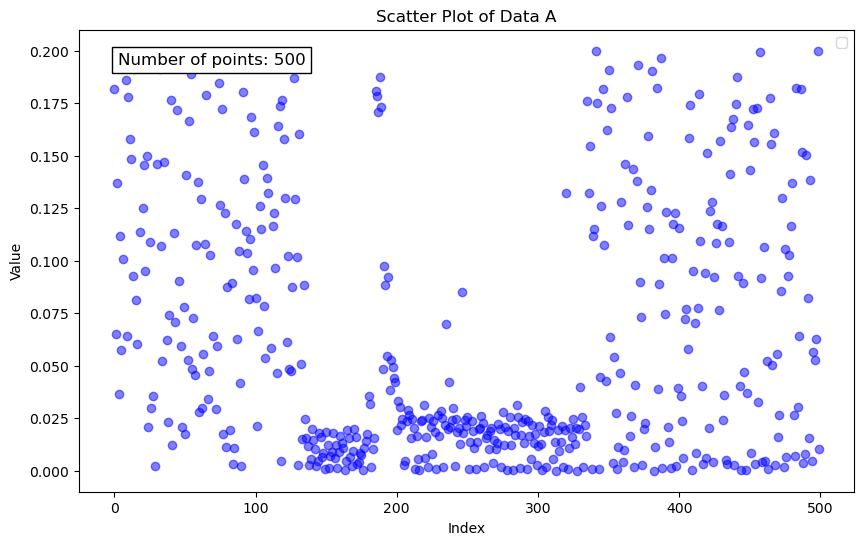

In [9]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


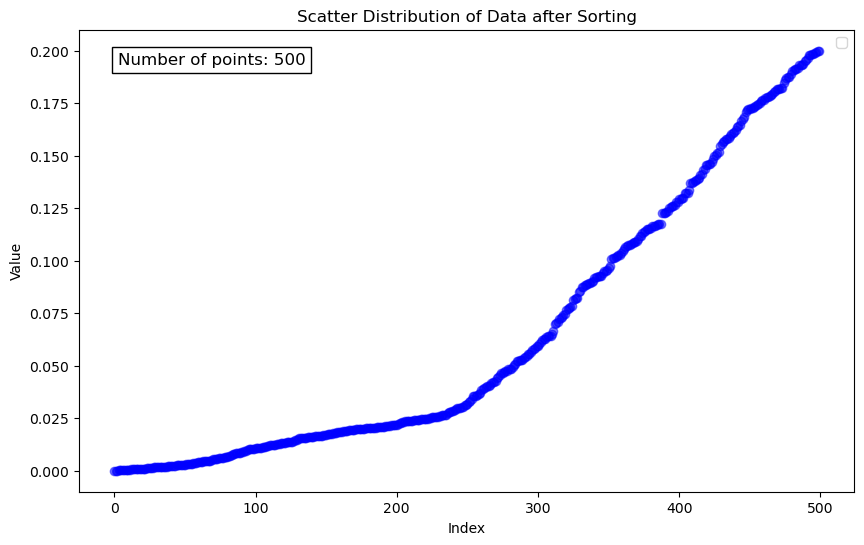

In [10]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.005507887856110372, 0.004386215955821868, 0.0054317962200206155, 0.004607131450632266, 0.005962776422397734, 0.006187066257912879, 0.006479116113161542, 0.00462684544987063, 0.005639457358861831, 0.006867971141770878]
Error u of fuhe active learning(LHS sampling): 5.569626e-03
[0.000465942229457094, 0.0003835870040047583, 0.0006080377089289516, 0.00039675930113849007, 0.0006188436241960674, 0.0005381430937711599, 0.0010043863576170945, 0.00041985132136466844, 0.0005087761817542141, 0.0005863955479563449]
MAE of fuhe active learning(LHS sampling): 5.530722e-04
[3.708153438347616e-06, 2.352032680786254e-06, 3.606128798791707e-06, 2.5946609760503085e-06, 4.34580478301551e-06, 4.678701487077273e-06, 5.133114401123099e-06, 2.6167981137099584e-06, 3.887322474724523e-06, 5.765112930246239e-06]
MSE of fuhe active learning(LHS sampling): 3.868783e-06
[3.1500125, 0.00027560696, 1.5880392, 7.594075, 2.2671978, 16.582224, 0.00015344589, 0.022141453, 20.828188, 0.0001579764]
Chaos of fuhe active

/tmp/ipykernel_1456591/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.005507887856110372, 0.004386215955821868, 0.0054317962200206155, 0.004607131450632266, 0.005962776422397734, 0.006187066257912879, 0.006479116113161542, 0.00462684544987063, 0.005639457358861831, 0.006867971141770878]
mean Error u: 5.569626e-03
Variance Error u: 6.292047e-07


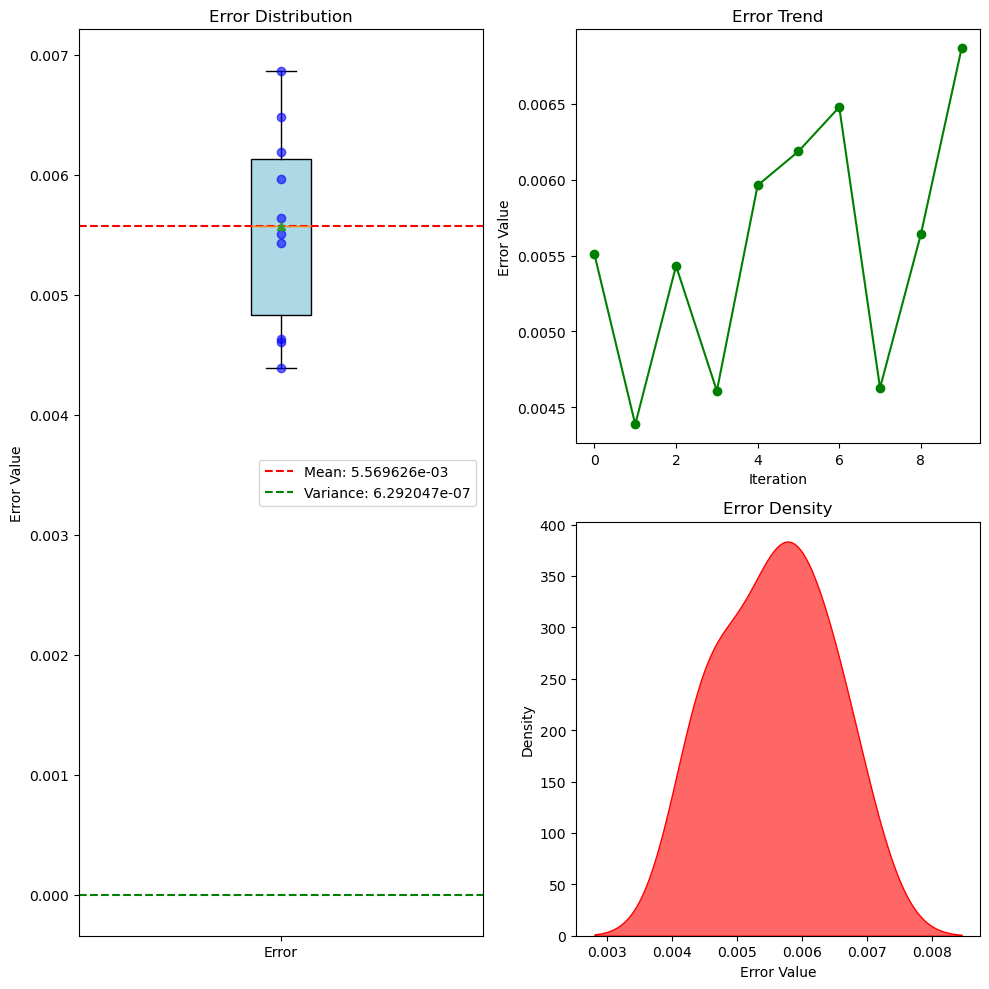

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.000465942229457094, 0.0003835870040047583, 0.0006080377089289516, 0.00039675930113849007, 0.0006188436241960674, 0.0005381430937711599, 0.0010043863576170945, 0.00041985132136466844, 0.0005087761817542141, 0.0005863955479563449]
mean MAE: 5.530722e-04
Variance MAE: 2.928254e-08


/tmp/ipykernel_1456591/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


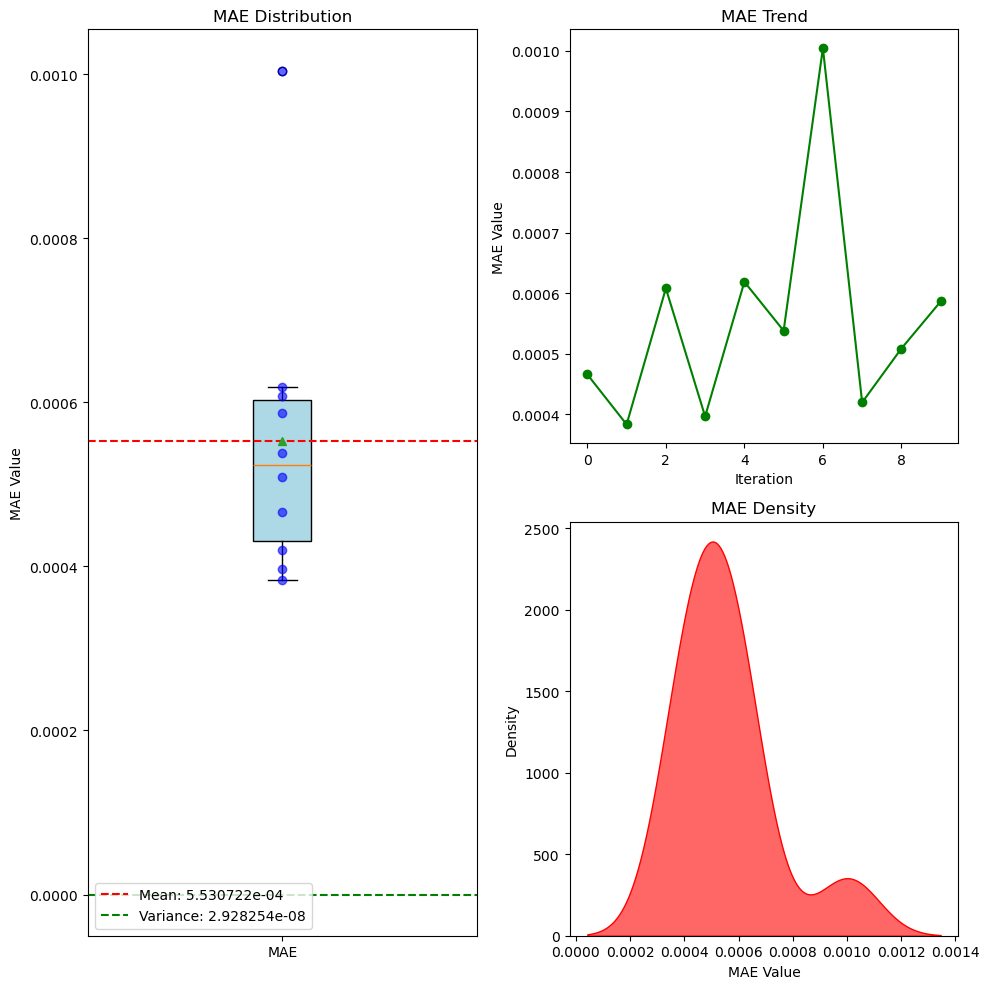

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.708153438347616e-06, 2.352032680786254e-06, 3.606128798791707e-06, 2.5946609760503085e-06, 4.34580478301551e-06, 4.678701487077273e-06, 5.133114401123099e-06, 2.6167981137099584e-06, 3.887322474724523e-06, 5.765112930246239e-06]
mean MSE: 3.868783e-06
Variance MSE: 1.166464e-12


/tmp/ipykernel_1456591/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


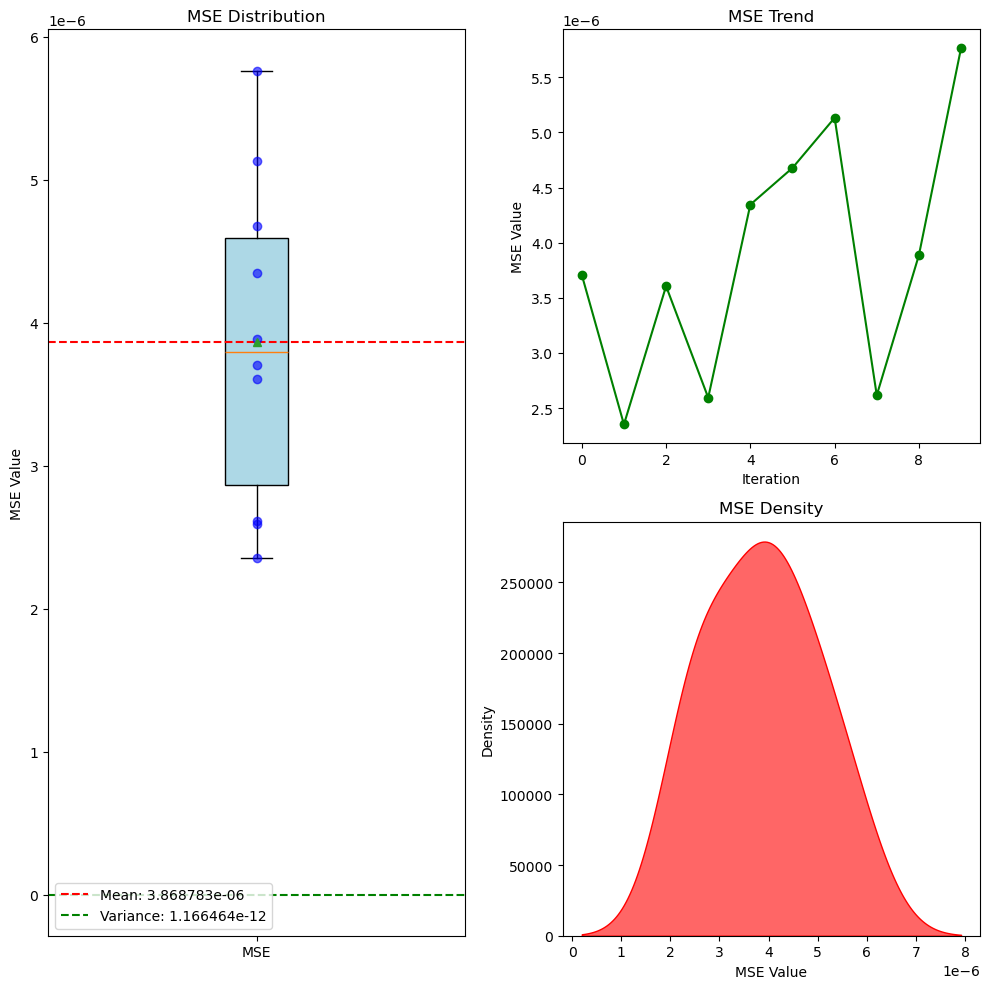

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.1500125, 0.00027560696, 1.5880392, 7.594075, 2.2671978, 16.582224, 0.00015344589, 0.022141453, 20.828188, 0.0001579764]
mean CHAOS: 5.203247e+00
Variance CHAOS: 5.133009e+01


/tmp/ipykernel_1456591/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


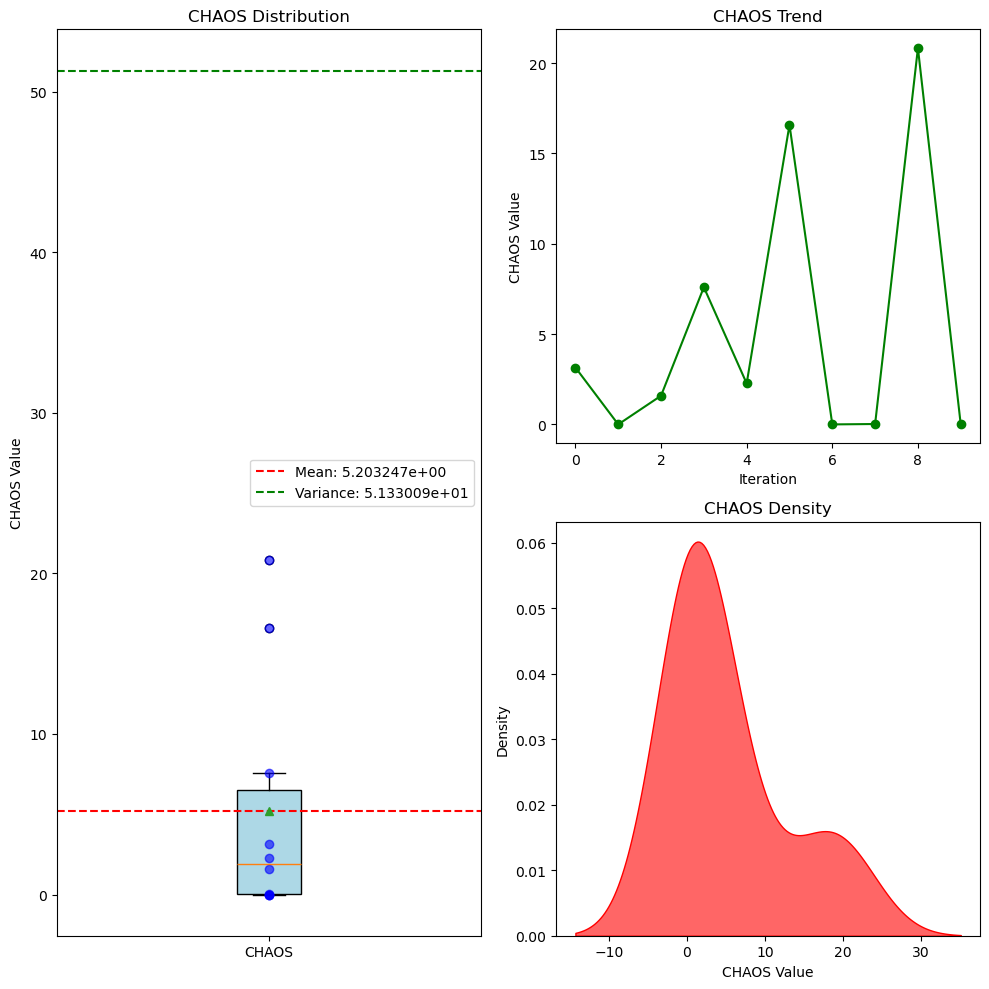

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0004725599, 0.00053834973, 0.00043653665, 0.00051356753, 0.0004378549, 0.00042312522, 0.00043626397, 0.0004602545, 0.00043649686, 0.0004504108]
mean RESIDUAL: 4.605420e-04
Variance RESIDUAL: 1.277147e-09


/tmp/ipykernel_1456591/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


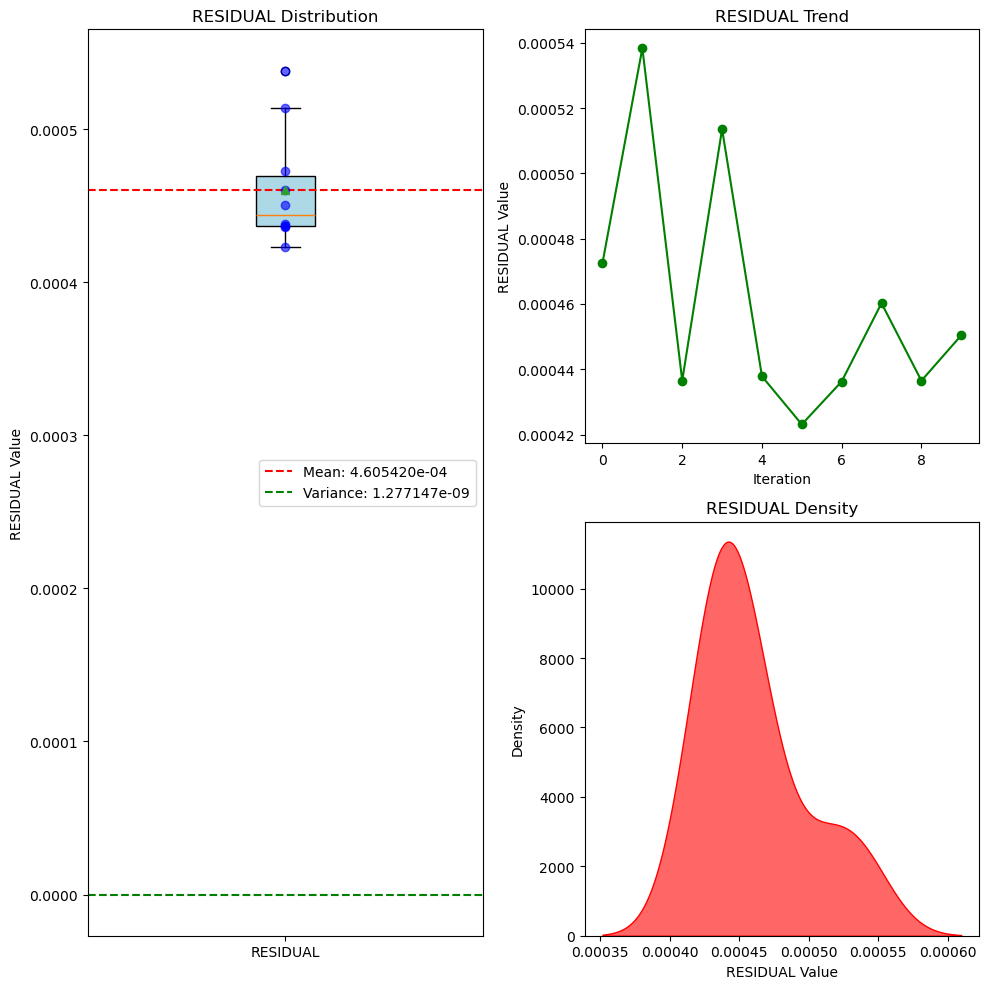

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.80451282e+03 1.72034912e+03 1.65058423e+03 ... 1.35134375e-02
 1.35109425e-02 1.35089038e-02]


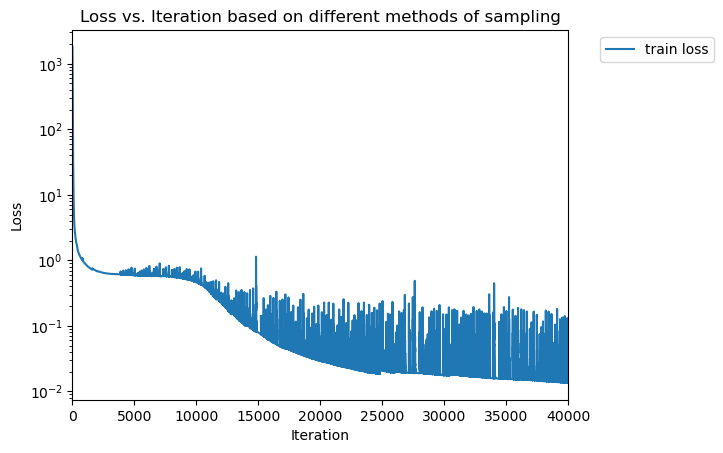

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.958635  0.010772  0.014932  0.014760  0.000236  0.000217  0.000312   
1  0.950019  0.012899  0.018145  0.017743  0.000310  0.000288  0.000416   
2  0.941871  0.014894  0.021187  0.020523  0.000393  0.000367  0.000533   
3  0.934107  0.016780  0.024087  0.023134  0.000487  0.000455  0.000662   
4  0.926668  0.018573  0.026869  0.025601  0.000588  0.000549  0.000802   

    state_8   state_9  state_10  state_11      state_12  
0  0.000115  0.000011  0.000004  0.000006  4.104030e-07  
1  0.000154  0.000014  0.000005  0.000008  4.894733e-07  
2  0.000198  0.000017  0.000006  0.000009  5.771348e-07  
3  0.000247  0.000021  0.000008  0.000012  6.746245e-07  
4  0.000301  0.000025  0.000009  0.000014  7.829465e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757828  0.053037  0.094719  0.068894  0.006640  0.004818  0.008606   
496  0.757826  0.053036  0.094719  0.068895  0.

Text(0, 0.5, 'Probability')

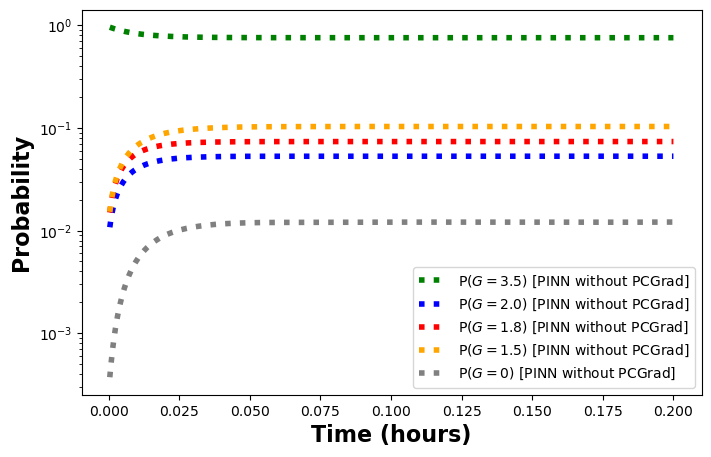

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

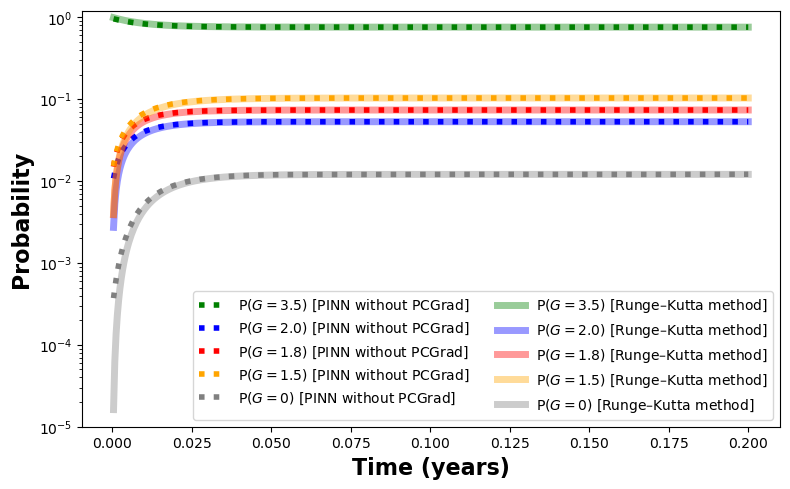

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 2.8825564651231184e-05
RMSE of between PINN without PCGrad and the analytical solution is 2.8825564651229493e-05


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.001685083407857319
RMSE of between PINN without PCGrad and the analytical solution is 0.0016850834078571846
